In [1]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.collections as mcollections
import matplotlib.colorbar as mcolorbar
from scipy.interpolate import griddata, LinearNDInterpolator, NearestNDInterpolator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from scipy.special import lambertw, comb, betainc
from scipy.optimize import minimize_scalar
import pandas as pd
import warnings
import os
from enum import Enum
from scipy.stats import binom
from tqdm import tqdm


FONT_SIZE = 14
FONT_FAMILY = "STIXGeneral"           # change to 'Roboto', 'serif', …
plt.rcParams["font.family"] = FONT_FAMILY
plt.rcParams["font.size"]   = FONT_SIZE
plt.rcParams["figure.figsize"] = 12, 10
NUM_PTS = 100

# Uncomment the next line if you have a LaTeX installation.
plt.rcParams['text.usetex'] = False


In [ ]:
# Parameters
kappa = 20
alpha = 1/3
beta = 1/3

# Analytical formula for $D_{\rm tr}$
def calculate_D_tr(C, D_inf, kappa):
    r"""Calculate $D_{\rm tr}$ using the analytical formula:
    
    \[
    D_{\rm tr} = \frac{1}{6} \sqrt{\frac{3}{2}\,\kappa\,C + 12\,D_{\rm inf}\,\sqrt{\frac{\kappa C}{6}}}
    + \frac{1}{2}\sqrt{\frac{\kappa C}{6}}
    \]
    """
    term1 = (1/6) * np.sqrt((3/2) * kappa * C + 12 * D_inf * np.sqrt(kappa * C/6))
    term2 = (1/2) * np.sqrt(kappa * C/6)
    return term1 + term2

# Asymptotic formulas for large $C$
def d_tr_asymptotic(C, kappa):
    r"""Asymptotic formula for $D_{\rm tr}$ when $C$ is large:
    
    \[
    D_{\rm tr} \sim \sqrt{\frac{\kappa C}{6}}
    \]
    """
    return np.sqrt(kappa * C/6)

def n_asymptotic(C, kappa):
    r"""Asymptotic formula for $N$ when $C$ is large:
    
    \[
    N \sim \sqrt{\frac{C}{6 \kappa}}
    \]
    """
    return np.sqrt(C/(6*kappa))

# Create a range of $C$ values on a logarithmic scale (from $10^{15}$ to $10^{32}$)
c_values = np.logspace(15, 32, 1000)

# Create a figure
plt.figure(figsize=(12, 8))

# Define $D_{\rm inf}$ values and create color gradients
d_inf_values = [1e6, 1e10, 1e14, 1e18, 1e22]
num_d_inf = len(d_inf_values)

# Create colormaps for $D_{\rm tr}$ (blue) and $N$ (red) with varying darkness
blues = plt.cm.Blues(np.linspace(0.3, 0.9, num_d_inf))
reds = plt.cm.Reds(np.linspace(0.3, 0.9, num_d_inf))

# Plot the asymptotic lines first (dashed)
plt.loglog(c_values, d_tr_asymptotic(c_values, kappa), 'b--', linewidth=2.5, 
           label=r'$D_{\rm tr}\sim\sqrt{\frac{\kappa C}{6}}$')
plt.loglog(c_values, n_asymptotic(c_values, kappa), 'r--', linewidth=2.5, 
           label=r'$N\sim\sqrt{\frac{C}{6\kappa}}$')

# Plot curves for each $D_{\rm inf}$ value
for i, d_inf in enumerate(d_inf_values):
    # Calculate $D_{\rm tr}$ and $N$
    d_tr_values = calculate_D_tr(c_values, d_inf, kappa)
    n_values = c_values / (6 * d_tr_values + 2 * d_inf)

    # For values where $N < 10^6$, set $D_{\rm tr}$ to NaN (so these points do not appear)
    d_tr_values[n_values < 1e6] = np.nan
    
    # Prepare labels in LaTeX format; we display the label only once per curve type
    label_dtr = (r'$D_{\rm tr}\ \left(D_{\rm inf} = '
                 + f'{d_inf:.0e}' + r'\right)$') if i == num_d_inf//2 else ""
    label_N = (r'$N\ \left(D_{\rm inf} = '
               + f'{d_inf:.0e}' + r'\right)$') if i == num_d_inf//2 else ""
    
    # Plot $D_{\rm tr}$ with a blue gradient
    plt.loglog(c_values, d_tr_values, '-', color=blues[i], linewidth=2, label=label_dtr)
    # Plot $N$ with a red gradient
    plt.loglog(c_values, n_values, '-', color=reds[i], linewidth=2, label=label_N)

# (Optional) Annotations for the asymptotic behavior (commented out)
"""
plt.annotate(r'$D_{\rm tr}\to\sqrt{\frac{\kappa C}{6}}$ for large $C$', 
             xy=(1e28, d_tr_asymptotic(1e28, kappa)), 
             xytext=(1e25, d_tr_asymptotic(1e25, kappa)*3),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.annotate(r'$N\to\sqrt{\frac{C}{6\kappa}}$ for large $C$', 
             xy=(1e28, n_asymptotic(1e28, kappa)), 
             xytext=(1e25, n_asymptotic(1e25, kappa)_0.3),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
"""

# Set the plot labels and title using LaTeX
plt.xlabel(r'$C$ (Total Compute)', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title(r'Total Compute Optimal $D_{\rm tr}$ and $N$ for Fixed $D_{\rm inf}$', fontsize=16)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Set y-axis minimum to $10^6$
plt.ylim(bottom=1e6)

# Add a colorbar for the blue curves ($D_{\rm tr}$)
sm_blue = plt.cm.ScalarMappable(cmap=plt.cm.Blues, 
                                norm=plt.Normalize(vmin=np.log10(d_inf_values[0]), 
                                                   vmax=np.log10(d_inf_values[-1])))
sm_blue.set_array([])
cbar = plt.colorbar(sm_blue, location='right', pad=0.01)
cbar.set_label(r'$\log_{10}(D_{\rm inf})$ for blue curves ($D_{\rm tr}$)', fontsize=12)

# Add a second colorbar for the red curves ($N$)
sm_optimal = plt.cm.ScalarMappable(cmap=plt.cm.optimals, 
                               norm=plt.Normalize(vmin=np.log10(d_inf_values[0]), 
                                                  vmax=np.log10(d_inf_values[-1])))
sm_red.set_array([])
cbar2 = plt.colorbar(sm_red, location='right', pad=0.05)
cbar2.set_label(r'$\log_{10}(D_{\rm inf})$ for red curves ($N$)', fontsize=12)
plt.figtext(0.5, 0.01, 
            r"Note: Regions where $N < 10^{6}$ are left blank",
            ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
# Create a combined legend
plt.legend(loc='upper left', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('dtr_n_plot.png', dpi=300)
plt.show()

In [ ]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.collections as mcollections
import matplotlib.colorbar as mcolorbar
from scipy.interpolate import griddata, LinearNDInterpolator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from scipy.special import lambertw, comb, betainc
from scipy.optimize import minimize_scalar
import pandas as pd
import warnings
import os
from enum import Enum
from scipy.stats import binom

FONT_SIZE = 14
FONT_FAMILY = "STIXGeneral"           # change to 'Roboto', 'serif', …
plt.rcParams["font.family"] = FONT_FAMILY
plt.rcParams["font.size"]   = FONT_SIZE
plt.rcParams["figure.figsize"] = 12, 10
NUM_PTS = 100
plt.rcParams['text.usetex'] = False

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
C_total = 1e26
I = 1e10

# Grid for surface plot
D_tr_vals = np.logspace(9, 14, 200)      # 1e9 to 1e13
Omega_vals = np.logspace(2, 6, 200)      # 1e2 to 1e6
D_tr, Omega = np.meshgrid(D_tr_vals, Omega_vals)

# Compute N
N = C_total / (6 * D_tr + 2 * I * Omega)

# 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Rotate the surface for better visibility
#ax.view_init(elev=60, azim=180)
surf = ax.plot_surface(np.log10(D_tr), np.log10(Omega), np.log10(N), edgecolor='none')
ax.set_xlabel('log10(D_tr)')
ax.set_ylabel('log10(Omega)')
ax.set_zlabel('log10(N)')
ax.set_title('Iso-compute Surface: N as function of D_tr and Ω')



# Constants
C_total = 1e29
I = 1e10

# Grid for surface plot
D_tr_vals = np.logspace(9, 14, 100)      # 1e9 to 1e13
Omega_vals = np.logspace(2, 6, 100)      # 1e2 to 1e6
D_tr, Omega = np.meshgrid(D_tr_vals, Omega_vals)

# Compute N
N = C_total / (6 * D_tr + 2 * I * Omega)

# Rotate the surface for better visibility
#ax.view_init(elev=60, azim=180)
surf2 = ax.plot_surface(np.log10(D_tr), np.log10(Omega), np.log10(N), edgecolor='none')
ax.set_xlabel('log10(D_tr)')
ax.set_ylabel('log10(Omega)')
ax.set_zlabel('log10(N)')
ax.set_title('Iso-compute Surface: N as function of D_tr and Ω')
plt.tight_layout()
plt.show()

# Cross-section 1: D_tr = 1e12, vary Omega
D_tr_fixed = 1e12
N1 = C_total / (6 * D_tr_fixed + 2 * I * Omega_vals)

plt.figure()
plt.plot(Omega_vals, N1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Ω (output tokens)')
plt.ylabel('N (parameters)')
plt.title('Cross-section at D_tr = 1e12')
plt.tight_layout()
plt.show()

# Cross-section 2: Ω = 1e4, vary D_tr
Omega_fixed = 1e4
N2 = C_total / (6 * D_tr_vals + 2 * I * Omega_fixed)

plt.figure()
plt.plot(D_tr_vals, N2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('D_tr (dataset size)')
plt.ylabel('N (parameters)')
plt.title('Cross-section at Ω = 1e4')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

# Define logarithmic grid for m and n
m_vals = np.logspace(2, 4, 20, dtype=int)  # from 10^2 to 10^4
n_vals = np.logspace(3, 5, 20, dtype=int)  # from 10^3 to 10^5
r_vals = [0.1]  # example r values

for r in r_vals:
    b_opt = np.zeros((len(m_vals), len(n_vals)))
    for i, m in enumerate(m_vals):
        for j, n in enumerate(n_vals):
            # Maximum b to keep shape2 > 0
            b_max = (n/(m-1))**2
            b_vals = np.logspace(0, np.log10(b_max), 200)
            shape2 = np.floor(n/np.sqrt(b_vals)) - m + 1
            valid = shape2 > 0
            f_vals = np.full_like(b_vals, np.nan)
            if np.any(valid):
                beta_vals = betainc(m, shape2[valid], r)
                f_vals[valid] = 1 - (1 - beta_vals)**b_vals[valid]
            # pick optimal b
            b_opt[i, j] = b_vals[np.nanargmax(f_vals)]
    # Plotting
    plt.figure()
    plt.pcolormesh(n_vals, m_vals, b_opt, shading='auto')
    plt.xscale('log')
    plt.yscale('log')
    plt.colorbar(label='Optimal b')
    plt.xlabel('n')
    plt.ylabel('m')
    plt.title(f'Optimal b across grid for r={r}')
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants (realistic values for a large LLM)
N = 1e10  # number of non-embedding parameters
n_layer = 96  # number of transformer layers
d_attn = 12288  # attention dimension
omega_ctx_0 = 200  # context length

# Omega_C range
omega_C = np.logspace(1, 6, 500)  # from 10 to 1e6 tokens

# First term: 2N * Omega_C
first_term = 2 * N * omega_C

# Second term: 2 * n_layer * d_attn * (omega_ctx_0 * Omega_C + Omega_C*(Omega_C - 1)/2)
second_term = 2 * n_layer * d_attn * (omega_ctx_0 * omega_C + (omega_C * (omega_C - 1)) / 2)

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(omega_C, first_term, label="2NΩ_C")
plt.loglog(omega_C, second_term, label="2n_layer d_attn (ω_ctx,0 Ω_C + Ω_C(Ω_C-1)/2)")
plt.xlabel("Ω_C (Output Tokens)")
plt.ylabel("Cost")
plt.title("Comparison of First vs Second Term as Function of Ω_C")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants (realistic values for a large LLM)
N = 1e10  # number of non-embedding parameters
n_layer = 96  # number of transformer layers
d_attn = 12288  # attention dimension
omega_ctx_0 = 200  # context length

# Omega_C range
omega_C = np.logspace(1, 6, 500)  # from 10 to 1e6 tokens

# First term: 2N * Omega_C
first_term = 2 * N * omega_C

# Second term: 2 * n_layer * d_attn * (omega_ctx_0 * Omega_C + Omega_C*(Omega_C - 1)/2)
second_term = 2 * n_layer * d_attn * (omega_ctx_0 * omega_C + (omega_C * (omega_C - 1)) / 2)

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(omega_C, first_term, label="2NΩ_C")
plt.loglog(omega_C, second_term, label="2n_layer d_attn (ω_ctx,0 Ω_C + Ω_C(Ω_C-1)/2)")


# Include ToT terms




plt.xlabel("Ω_C (Output Tokens)")
plt.ylabel("Cost")
plt.title("Comparison of First vs Second Term as Function of Ω_C")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc
from matplotlib.colors import LinearSegmentedColormap

# Update model parameters
N = 1e10  # number of non-embedding parameters
n_layer = 96  # number of transformer layers
d_attn = 12_288  # attention dimension
omega_prompt = 200  # prompt length
omega = 25  # number of tokens per skill

def omega_T_updated(omega_C,b):
    """Recompute Ω_T from Ω_C using updated parameters."""
    # Recompute constants
    A = 2 * N
    B = n_layer * d_attn
    k = 2 * omega_prompt - 1 + A / B
    D = b + (b - 1) / omega
    delta_over_B = D / B
    term1 = b * k + delta_over_B
    disc = term1**2 + 4 * b * (omega_C**2 + k * omega_C)
    return (-term1 + np.sqrt(disc)) / (2 * b)

# Define parameter combinations
b_values = [4, 16]
r_values = [0.001, 0.01, 0.1, 0.5]

# Create logarithmically spaced points
x_min, x_max = 2.5e1, 1e6
y_min, y_max = 2.5e1, 1e6
x_points = np.logspace(np.log10(x_min), np.log10(x_max),500)
y_points = np.logspace(np.log10(y_min), np.log10(y_max),500)

# Remove duplicates and sort
x_points = np.unique(x_points)
y_points = np.unique(y_points)
# sort the points
x_points.sort()
y_points.sort()

# Create proper meshgrid
X, Y = np.meshgrid(x_points, y_points)


def compute_success_probabilities(b, r):
    """Compute I_CoT and I_ToT for given parameters b and r"""
    # Initialize arrays with correct dimensions
    I_CoT = np.full_like(X, np.nan)
    I_ToT = np.full_like(X, np.nan)
    
    print(f"\nComputing probabilities for b={b}, r={r}")
    
    # Calculate beta functions
    for i in tqdm(range(len(y_points)), desc=f"b={b}, r={r}"):
        for j in range(len(x_points)):
            omega_C = X[i, j]  # x-axis = Omega_C
            m_omega = Y[i, j]  # y-axis = m*omega
            
            # Calculate m and check validity
            m = int(np.floor(m_omega / omega))
            if m < 1:
                continue
            
            # CoT calculation
            K_C = int(np.floor(omega_C / omega))
            if m > K_C:
                continue
            
            a = m
            b_param = K_C - m + 1
            if b_param > 0:
                I_CoT[i, j] = betainc(a, b_param, r)
            else:
                I_CoT[i, j] = 0.0
            
            # ToT calculation
            omega_T_val = omega_T_updated(omega_C, b)
            K_T = int(np.floor(omega_T_val / omega))
            a = m
            b_param = K_T - m + 1
            r_eff = 1 - (1 - r)**b
            if b_param > a:
                I_ToT[i, j] = betainc(a, b_param, r_eff)
            else:
                continue
    
    return I_CoT, I_ToT

# Compute all combinations and store results
results = {}
for b in b_values:
    for r in r_values:
        I_CoT, I_ToT = compute_success_probabilities(b, r)
        results[(b, r)] = (I_CoT, I_ToT)

# Initialize arrays with correct dimensions (rows=y values, columns=x values)
I_CoT = np.full_like(X, np.nan)
I_ToT = np.full_like(X, np.nan)

# Create side-by-side comparison plots
# Structure: Row 0 = CoT, Row 1 = ToT(b=4), Row 2 = ToT(b=16)
fig1, axes = plt.subplots(3, len(r_values), figsize=(15, 10))
fig1.suptitle('Success Probability Comparison: CoT vs ToT(1)', fontsize=16)

for j, r in enumerate(r_values):  # j is columns (r values)
    # Row 0: CoT (only depends on r, not b)
    I_CoT, _ = results[(b_values[0], r)]  # Get CoT from any b value (they're the same)
    ax_cot = axes[0, j]
    pcm1 = ax_cot.pcolormesh(X, Y, I_CoT, shading='auto', cmap='inferno', vmin=0, vmax=1)
    ax_cot.set_xscale('log')
    ax_cot.set_yscale('log')
    ax_cot.set_xlim(x_min, x_max)
    ax_cot.set_ylim(y_min, y_max)
    if j == 0:  # Only add y-label to leftmost plots
        ax_cot.set_ylabel(fr'$m \cdot \omega$ (Tokens Required)')
    ax_cot.set_title(f'CoT ($r={r}$)')
    # Add constraint line
    ax_cot.plot(x_points, x_points, c='orange', ls='--', alpha=0.7, linewidth=1)
    
    # Row 1: ToT with b=4
    _, I_ToT_4 = results[(4, r)]
    ax_tot_4 = axes[1, j]
    pcm2 = ax_tot_4.pcolormesh(X, Y, I_ToT_4, shading='auto', cmap='inferno', vmin=0, vmax=1)
    ax_tot_4.set_xscale('log')
    ax_tot_4.set_yscale('log')
    ax_tot_4.set_xlim(x_min, x_max)
    ax_tot_4.set_ylim(y_min, y_max)
    if j == 0:  # Only add y-label to leftmost plots
        ax_tot_4.set_ylabel(fr'$m \cdot \omega$ (Tokens Required)')
    ax_tot_4.set_title(fr'ToT(1) ($b=4$, $r={r}$)')
    # Add constraint line
    ax_tot_4.plot(x_points, x_points/np.sqrt(4), c='blue', ls='--', alpha=0.7, linewidth=1)
    
    # Row 2: ToT with b=16
    _, I_ToT_16 = results[(16, r)]
    ax_tot_16 = axes[2, j]
    pcm3 = ax_tot_16.pcolormesh(X, Y, I_ToT_16, shading='auto', cmap='inferno', vmin=0, vmax=1)
    ax_tot_16.set_xscale('log')
    ax_tot_16.set_yscale('log')
    ax_tot_16.set_xlim(x_min, x_max)
    ax_tot_16.set_ylim(y_min, y_max)
    ax_tot_16.set_xlabel(fr'$\Omega_C$ (Token Budget)')  # Bottom row gets x-labels
    if j == 0:  # Only add y-label to leftmost plots
        ax_tot_16.set_ylabel(fr'$m \cdot \omega$ (Tokens Required)')
    ax_tot_16.set_title(fr'ToT(1) ($b=16$, $r={r}$)')
    # Add constraint line
    ax_tot_16.plot(x_points, x_points/np.sqrt(16), c='blue', ls='--', alpha=0.7, linewidth=1)

# Add a single colorbar for the entire figure (following your fig2 approach)
fig1.subplots_adjust(right=0.92)
cbar_ax = fig1.add_axes([0.94, 0.15, 0.02, 0.7])
cbar = fig1.colorbar(pcm3, cax=cbar_ax)
cbar.set_label('Probability', rotation=270, labelpad=15)

legend_elements = [
    plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7,
               label=fr'CoT: $m \cdot \omega = \Omega_C$, ToT(1): $m \cdot \omega = \Omega_C / \sqrt{{b}}$')
]
fig1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02),
           ncol=1, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.08, right=0.92)
plt.show()

# Create comprehensive difference plot (2×3 layout)
fig2, axes = plt.subplots(len(b_values), len(r_values), figsize=(12, 6))
fig2.suptitle('Success Probability Difference: ToT(1) - CoT', fontsize=16)

plot_idx = 0
for j, b in enumerate(b_values):
    for i, r in enumerate(r_values):
        row = j
        col = i
        
        # Get precomputed results and compute differences
        I_CoT, I_ToT = results[(b, r)]
        
        # Compute difference
        I_diff = np.full_like(X, np.nan)
        for ii in range(len(y_points)):
            for jj in range(len(x_points)):
                if np.isnan(I_CoT[ii, jj]) and not np.isnan(I_ToT[ii, jj]):
                    I_diff[ii, jj] = I_ToT[ii, jj]
                elif not np.isnan(I_CoT[ii, jj]) and not np.isnan(I_ToT[ii, jj]):
                    I_diff[ii, jj] = I_ToT[ii, jj] - I_CoT[ii, jj]
                elif not np.isnan(I_CoT[ii, jj]) and np.isnan(I_ToT[ii, jj]):
                    I_diff[ii, jj] = -I_CoT[ii, jj]
                else:
                    I_diff[ii, jj] = np.nan
        
        ax = axes[row, col]
        # Define the colors for the colormap
        colors = ["orange", "white", "blue"]

        # Create the colormap
        cmap = LinearSegmentedColormap.from_list("orange_blue", colors)
        pcm = ax.pcolormesh(X, Y, I_diff, shading='nearest', cmap=cmap, 
                           vmin=-1, vmax=1)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        
        # Labels
        if row == 1:  # Bottom row
            ax.set_xlabel(fr'$\Omega_C$ (Token Budget)')
        if col == 0:  # Left column  
            ax.set_ylabel(fr'$m \cdot \omega$ (Tokens Required)')
        
        ax.set_title(f'$b={b}$, $r={r}$')
        
        # Add constraint lines
        ax.plot(x_points, x_points, '--', color='orange', alpha=0.6, linewidth=1.2)
        ax.plot(x_points, x_points/np.sqrt(b), '--', color='blue', alpha=0.6, 
               linewidth=1.2)

# Add a single colorbar for the entire figure
fig2.subplots_adjust(right=0.92)
cbar_ax = fig2.add_axes([0.94, 0.15, 0.02, 0.7])
cbar = fig2.colorbar(pcm, cax=cbar_ax)
cbar.set_label('Probability Difference', rotation=270, labelpad=20)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color='orange', linestyle='--', alpha=0.6, 
               label=fr'$m \cdot \omega = \Omega_C$'),
    plt.Line2D([0], [0], color='blue', linestyle='--', alpha=0.6,
               label=fr'$m \cdot \omega = \Omega_C / \sqrt{{b}}$')
]
fig2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
           ncol=2, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.12, right=0.92)
plt.show()

print("\\n" + "="*50)
print("ALL PLOTS GENERATED SUCCESSFULLY!")
print("="*50)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Plot
plt.figure(figsize=(8, 5))

# Model parameters
N = 1e10  # number of non-embedding parameters
n_layer = 96
d_attn = 12288
omega_prompt = 200
omega = 25
i=0
for b in [4,16,256]:
    # Recompute constants
    A = 2 * N
    B = n_layer * d_attn
    kappa = 2 * omega_prompt - 1 + A / B
    D = b + (b - 1) / omega
    delta_over_B = D / B

    # Define Ω_T(Ω_C) from quadratic form
    def omega_T_updated(omega_C, b):
        A = 2 * N
        B = n_layer * d_attn
        k = 2 * omega_prompt - 1 + A / B
        D = b + (b - 1) / omega
        delta_over_B = D / B
        term1 = b * k + delta_over_B
        disc = term1**2 + 4 * b * (omega_C**2 + k * omega_C)
        omega_T = (-term1 + np.sqrt(disc)) / (2 * b)
        # If the result is less than 1, set it to 0
        omega_T[ omega_T<1 ] = 0
        return omega_T

    # Attention cost functions
    def attention_cost_CoT(Omega_C):
        return 2 * n_layer * d_attn * (
            omega_prompt**2 + Omega_C * omega_prompt + Omega_C * (Omega_C - 1) / 2
        )

    def attention_cost_ToT(Omega_T, b):
        return 2 * n_layer * d_attn * (
            omega_prompt**2 + b * Omega_T * omega_prompt + b * Omega_T * (Omega_T - 1) / 2
        )

    # Additional cost for ToT
    def additional_cost_ToT(Omega_T, b):
        return b * Omega_T + (Omega_T / omega) * (b - 1)

    # Define a range of CoT token budgets
    Omega_C = np.logspace(0, np.log10(1e6), 400)
    Omega_T = omega_T_updated(Omega_C, b)

    # Total cost calculations
    C_inf_CoT = 2 * N * Omega_C + attention_cost_CoT(Omega_C)
    C_inf_ToT = (
        2 * N * Omega_T
        + attention_cost_ToT(Omega_T, b)
        + additional_cost_ToT(Omega_T, b)
    )

    # Rotate through colors with each iteration
    # Use inferno colormap for color cycling
    cmap = plt.get_cmap('Blues')
    color = cmap((i+2) / 4)  # Normalize i to the number of colors
    if i == 2:
        color = 'blue'
    i += 1
    if b == 1:
        label = 'CoT'
        plt.plot(C_inf_CoT, b * Omega_T, label=fr'$b \cdot \Omega_T$ (ToT(1), $b={b}$)', color = color, alpha=0.5)
    else:
        plt.plot(C_inf_CoT, b * Omega_T, color = color, label=fr'$b \cdot \Omega_T$ (ToT(1), $b={b}$)')
        plt.plot(C_inf_CoT, np.sqrt(b) * Omega_C, '--', color = color, alpha=0.5)

# Add legend label for '--' being asymptotic , label=fr'$b^{1/2} \cdot \Omega_C$ (Asymptotic ToT)' but not for any color in particular just grey --
plt.plot([], [], '--', label=fr'$\sqrt{{b}} \cdot \Omega_C$ (Asymptotic ToT(1))', color = 'grey', alpha=.7)

plt.plot(C_inf_CoT, Omega_C, '-', label=fr'$\Omega_C$ (CoT)', color = 'orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(fr'Inference Cost: $C_{{\mathrm{{inf}}}}^{{\mathrm{{param}}}} + C_{{\mathrm{{inf}}}}^{{\mathrm{{attention}}}} + C_{{\mathrm{{inf}}}}^{{\mathrm{{additional}}}}$')
plt.ylabel('Total Token Budget')
plt.title('Token Budget vs Inference Cost')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def plot_contour(accuracy_df):
    df = accuracy_df.copy()
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=[12, 8])
    
    # Extract data from dataframe
    C_tr_values = df['C_tr'].values
    C_inf_values = df['C_inf'].values
    accuracy_values = df['Accuracy'].values
    
    # Create a regular grid for interpolation in log space
    log_tr_min, log_tr_max = np.log10(C_tr_values.min()), np.log10(C_tr_values.max())
    log_inf_min, log_inf_max = np.log10(C_inf_values.min()), np.log10(C_inf_values.max())
    
    grid_size = 100
    log_tr_grid = np.linspace(log_tr_min, log_tr_max, grid_size)
    log_inf_grid = np.linspace(log_inf_min, log_inf_max, grid_size)
    log_tr_mesh, log_inf_mesh = np.meshgrid(log_tr_grid, log_inf_grid)
    
    # Points need to be in log space for better interpolation
    log_points = np.column_stack((np.log10(C_tr_values), np.log10(C_inf_values)))
    
    # Interpolate accuracy values onto the log grid
    grid_accuracy = griddata(log_points, accuracy_values, (log_tr_mesh, log_inf_mesh), method='linear')
    
    # Convert mesh back to linear scale for plotting
    tr_mesh = 10**log_tr_mesh
    inf_mesh = 10**log_inf_mesh
    
    # Create contour levels excluding values above 0.99
    min_acc = max(0, accuracy_values.min())
    max_acc = min(0.99, accuracy_values.max())  # Cap at 0.99
    levels = np.linspace(min_acc, max_acc, 10)
    
    # Define colormap for consistency
    cmap = plt.cm.viridis
    
    # Create colored contour lines with increased transparency
    contour_lines = ax.contour(tr_mesh, inf_mesh, grid_accuracy, levels=levels, 
                                cmap=cmap, linewidths=1.0, alpha=1)  # More transparent
    
    # Add scatter points with increased transparency
    scatter = ax.scatter(C_tr_values, C_inf_values, c=accuracy_values, cmap=cmap,
                        edgecolor='k', s=15, alpha=0.2, zorder=5)  # Smaller and more transparent
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Expected Accuracy')
    cbar.ax.set_yticks(levels)
    cbar.ax.set_yticklabels([f'{level:.2f}' for level in levels])
    
    # Create an interpolator for accuracy as a function of C_tr and C_inf
    accuracy_interp = LinearNDInterpolator(log_points, accuracy_values)

    # Set log scales
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Set axis labels and title
    ax.set_xlabel('Training Compute')
    ax.set_ylabel('Inference Compute per Task')
    
    # Manually draw grid lines with increased transparency
    ax.grid(False)
    
    # X-axis major grid lines
    for decade in range(int(log_tr_min), int(log_tr_max)+1):
        ax.axvline(x=10**decade, color='black', linestyle='-', linewidth=0.7, alpha=0.3, zorder=0)
    
    # Y-axis major grid lines
    for decade in range(int(log_inf_min), int(log_inf_max)+1):
        ax.axhline(y=10**decade, color='black', linestyle='-', linewidth=0.7, alpha=0.3, zorder=0)
    
    # X-axis minor grid lines
    for decade in range(int(log_tr_min), int(log_tr_max)+1):
        for i in [2, 3, 4, 5, 6, 7, 8, 9]:
            ax.axvline(x=i*10**decade, color='gray', linestyle=':', linewidth=0.7, alpha=0.3, zorder=0)
    
    # Y-axis minor grid lines
    for decade in range(int(log_inf_min), int(log_inf_max)+1):
        for i in [2, 3, 4, 5, 6, 7, 8, 9]:
            ax.axhline(y=i*10**decade, color='gray', linestyle=':', linewidth=0.7, alpha=0.3, zorder=0)
    
    # Configure axis ticks
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10))
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2,3,4,5,6,7,8,9]))
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2,3,4,5,6,7,8,9]))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    plt.tight_layout()
    plt.show()

In [ ]:
def L(N,D):
    alpha=.34
    beta=.28
    A=406.4
    B=410.7
    E=1.69
    return E+A*N**(-alpha)+B*D**(-beta)

def p(L_0,L):
    a=1
    b=5
    return a/(1+np.exp(-b*(L_0-L)))

def I_r(r,k,m):
    if m > k:
        return 0
    return betainc(m, k-m+1, r)

C_tr_vals=np.logspace(14,27,100)
kappa=20
omega=25
N=np.sqrt(C_tr_vals/(6*kappa))
D=kappa*N
plt.plot(6*N*D, L(N,D), label='L(N,D)')
#log axes
plt.xscale('log')

plt.title('L(N,D) vs C_tr=6ND')
plt.xlabel('C_tr=6ND')
plt.ylabel('L(N,D)')
plt.show()

l_min, l_max, delta_l0 = 1.0, 2.5, 0.2
m_min, m_max = 5, 10
l_vals = np.linspace(l_min, l_max, int((l_max-l_min)/delta_l0)+1)
m_vals = np.arange(m_min, m_max+1)

def phi(l, m):
    return 1.0 / (len(l_vals) * len(m_vals))

colors = plt.cm.viridis(np.linspace(0, 1, len(l_vals)))
for idx, L_0 in enumerate(l_vals):
    plt.plot(C_tr_vals, p(L_0, L(N,D)), color = colors[idx], label=f'L_0={L_0}')
    plt.plot(C_tr_vals,list([p(L_0, L(np.inf,np.inf))])*len(C_tr_vals), color = colors[idx], linestyle='--')#, label=f'Infinite Training Compute Limit for L_0={L_0}')
plt.xscale('log')
plt.legend()
plt.title('p(L_0,L) vs C_tr=6ND')
plt.xlabel('C_tr=6ND')
plt.ylabel('p(L_0,L)')
plt.show()

def steps_used(r, k, m):
    #mu=m/r
    #sigma = np.sqrt(m * (1 - r)) / r
    #z = (k - mu) / sigma if sigma > 0 else 0
    #Phi = 0.5 * (1 + erf(z / sqrt(2)))
    #varphi = exp(-z * z / 2) / sqrt(2 * pi)
    #expectation = mu * Phi + k * (1 - Phi) - sigma * varphi
    #if z < -1:
    #    return k
    #return expectation
    return min(m / r, k)


# Generate list of integer steps logarithmically spaced
k_vals = np.logspace(0, 8, num=100)
# Convert to integers and remove duplicates
k_vals = sorted(set(map(int, k_vals)))

rows = []
for C_tr in tqdm(C_tr_vals): # loop through training
    N = np.sqrt(C_tr/(6*kappa))
    D = kappa * N
    L_ND = L(N, D)
    for k in k_vals: # loop through inference
        token_budget = k * omega
        C_inf_budget = 2 * N * token_budget

        weighted_accuracy_list = []
        weighted_token_list = []
        for m in m_vals: # loop through steps
            for l0 in l_vals: # loop through difficulties
                p_L0 = p(l0, L_ND)
                weight = phi(l0, m)
                weighted_accuracy_list.append( I_r(p_L0, k, m) * weight )
                weighted_token_list.append( steps_used(p_L0,k,m) * omega * weight)
        
        accuracy = np.sum(weighted_accuracy_list)
        tokens = np.sum(weighted_token_list)
        C_inf = 2 * N * tokens
        rows.append( {"N": N,
                        "D": D,
                        "C_tr": C_tr,
                        "Token Budget": token_budget,
                        "C_inf Budget": C_inf_budget,
                        "Tokens": tokens,
                        "C_inf": C_inf,
                        "Accuracy": accuracy,
                    } )

accuracy_df = pd.DataFrame(rows)

plot_contour(accuracy_df)

In [ ]:
def L(N,D):
    alpha=.34
    beta=.28
    A=406.4
    B=410.7
    E=1.69
    return E+A*N**(-alpha)+B*D**(-beta)

def p(L_0,L):
    a=1
    b=5
    return a/(1+np.exp(-b*(L_0-L)))

def I_r(r,k,m):
    if m > k:
        return 0
    return betainc(m, k-m+1, r)

C_tr_vals=np.logspace(14,27,100)
omega=25

kappa=20
N=np.sqrt(C_tr_vals/(6*kappa))
D=kappa*N
plt.plot(6*N*D, L(N,D), label='L(N,D)')
#log axes
plt.xscale('log')

plt.title('L(N,D) vs C_tr=6ND')
plt.xlabel('C_tr=6ND')
plt.ylabel('L(N,D)')
plt.show()

l_min, l_max, delta_l0 = 1.0, 2.5, 0.2
m_min, m_max = 5, 10
l_vals = np.linspace(l_min, l_max, int((l_max-l_min)/delta_l0)+1)
m_vals = np.arange(m_min, m_max+1)

def phi(l, m):
    return 1.0 / (len(l_vals) * len(m_vals))

colors = plt.cm.viridis(np.linspace(0, 1, len(l_vals)))
for idx, L_0 in enumerate(l_vals):
    plt.plot(C_tr_vals, p(L_0, L(N,D)), color = colors[idx], label=f'L_0={L_0}')
    plt.plot(C_tr_vals,list([p(L_0, L(np.inf,np.inf))])*len(C_tr_vals), color = colors[idx], linestyle='--')#, label=f'Infinite Training Compute Limit for L_0={L_0}')
plt.xscale('log')
plt.legend()
plt.title('p(L_0,L) vs C_tr=6ND')
plt.xlabel('C_tr=6ND')
plt.ylabel('p(L_0,L)')
plt.show()

In [ ]:
def L(N,D):
    alpha=.34
    beta=.28
    A=406.4
    B=410.7
    E=1.69
    return E+A*N**(-alpha)+B*D**(-beta)

def p(L_0,L):
    a=1
    b=5
    return a/(1+np.exp(-b*(L_0-L)))

def I_r(r,k,m):
    if m > k:
        return 0
    k=int(k)
    m=int(m)
    return betainc(m, k-m+1, r)

omega=25

l_min, l_max, delta_l0 = .1, 4.0, 0.5
m_min, m_max = 1, 50
l_vals = np.linspace(l_min, l_max, int((l_max-l_min)/delta_l0)+1)
m_vals = np.arange(m_min, m_max+1)

def phi(l, m):
    return 1.0 / (len(l_vals) * len(m_vals))

def steps_used(r, k, m):
    return min(m / r, k)

# Generate list of integer steps logarithmically spaced
k_vals = np.logspace(0, 7, num=50)
# Convert to integers and remove duplicates
k_vals = sorted(set(map(int, k_vals)))

D_vals = np.logspace(7, 14, num=50)

N_vals = np.logspace(7, 14, num=50)

rows = []
for N in tqdm(N_vals): # loop through training
    for D in D_vals:
        L_ND = L(N, D)
        C_tr = 6 * N * D
        for k in k_vals: # loop through inference
            token_budget = k * omega
            C_inf_budget = 2 * N * token_budget

            weighted_accuracy_list = []
            weighted_token_list = []
            for m in m_vals: # loop through steps
                for l0 in l_vals: # loop through difficulties
                    p_L0 = p(l0, L_ND)
                    weight = phi(l0, m)
                    weighted_accuracy_list.append( I_r(p_L0, k, m) * weight )
                    weighted_token_list.append( steps_used(p_L0,k,m) * omega * weight)
            
            accuracy = np.sum(weighted_accuracy_list)
            tokens = np.sum(weighted_token_list)
            C_inf = 2 * N * tokens
            rows.append( {"N": N,
                            "D": D,
                            "C_tr": C_tr,
                            "Token Budget": token_budget,
                            "C_inf Budget": C_inf_budget,
                            "Tokens": tokens,
                            "C_inf": C_inf,
                            "Accuracy": accuracy,
                        } )

accuracy_df = pd.DataFrame(rows)

plot_contour(accuracy_df)

In [ ]:
# Plot 3d scatter of N,D,Tokens in df colored by Accuracy
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Rotate
ax.view_init(elev=20, azim=30)

ax.scatter(np.log10(accuracy_df['N']), np.log10(accuracy_df['D']), np.log10(accuracy_df['Tokens']), c=accuracy_df['Accuracy'], cmap='inferno', marker='o', alpha=0.1)
ax.set_xlabel('log(Parameters)')
ax.set_ylabel('log(Training Dataset Size)')
ax.set_zlabel('log(Inference Tokens)')
# Include color bar
cbar = fig.colorbar(ax.collections[0], ax=ax, label='Accuracy')
cbar.set_label('Accuracy')
ax.set_title('3D Scatter Plot of N, D, and Tokens Colored by Accuracy')
plt.show()

s=10,alpha=.1

In [ ]:
# TODO: 1) check with no pauses, 2) get scaling laws, 3) clean up desciptions and axes, etc and plot for longer time and do rotation rate

"""
Iso-Compute Animation
"""

# ════════════════════════════════════════════════════════════════════════
# 1. DATA & PARAMETERS
# ════════════════════════════════════════════════════════════════════════
import numpy as np, matplotlib.pyplot as plt, pathlib, tqdm, pandas as pd
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.interpolate import NearestNDInterpolator
from matplotlib import colors

I = 1e9; fps = 15; pause_s = 5; hold_f = rot_f = pause_s*fps
κ_fixed = 20; κ_inc_f = fps*15; Ω_inc_f = fps*15
surface_grid, opt_grid = 500, 500
view_elev, az0 = 25, 45
degrees_per_second = 10  # Set your desired rotation speed here
degrees_per_frame = degrees_per_second / fps
samp = 25
compute_range = (1e19, 3e24)
num_compute_surface_seconds = 15
drop_cloud_f = fps*5
draw_connector_secs = 5
# DEBUG SETTINGS - FIXED
debug = False

# Apply debug overrides PROPERLY
if debug:
    fps = 5  # Increased from 1 for smoother debug
    pause_s = 1
    κ_inc_f = 10  # Fixed small number, not fps*5
    Ω_inc_f = 10  # Fixed small number, not fps*5
    surface_grid = 500  # MUCH smaller! Was 500
    opt_grid = 250      # MUCH smaller! Was 500
    num_compute_surface_seconds = 1  # Fewer compute points
    drop_cloud_f = 5
    draw_connector_secs = 1

# Calculate derived values AFTER debug overrides
hold_f = rot_f = int(pause_s * fps)
connector_draw_frames = int(fps * draw_connector_secs)

assert isinstance(accuracy_df, pd.DataFrame)
logN = np.log10(accuracy_df['N'].values)
logD = np.log10(accuracy_df['D'].values)
logT = np.log10(accuracy_df['Tokens'].values)
acc  = accuracy_df['Accuracy'].values

cmap  = plt.cm.viridis
norm  = colors.Normalize(vmin=acc.min(), vmax=acc.max())
interp = NearestNDInterpolator(np.column_stack([logN,logD,logT]), acc)

ln_min, ln_max = logN.min(), logN.max()
ld_min, ld_max = logD.min(), logD.max()
lt_min, lt_max = logT.min(), logT.max()

sci = lambda x,p=1: f"{x:.{p}e}".replace('e+0','e').replace('e+','e')
L   = lambda N,D: 1.69 + 406.4*N**-0.34 + 410.7*D**-0.28
iso_compute = np.geomspace(*compute_range, int(fps * num_compute_surface_seconds))

# ════════════════════════════════════════════════════════════════════════
# 2. GEOMETRY BUILDERS
# ════════════════════════════════════════════════════════════════════════
ln_grid = np.linspace(ln_min, ln_max, surface_grid)
ld_grid = np.linspace(ld_min, ld_max, surface_grid)
logκ    = np.log10(κ_fixed)

def iso_surface_points(C):
    pts, col = [], []
    for ln in ln_grid:
        for ld in ld_grid:
            N,D = 10**ln, 10**ld
            Tok = (C-6*N*D)/(2*N*I)
            if Tok<=0: continue
            lt = np.log10(Tok)
            if lt_min<=lt<=lt_max:
                pts.append((ld,ln,lt)); col.append(interp([ln,ld,lt])[0])
    if not pts: return (np.empty(0),)*4
    pts = np.array(pts)
    return pts[:,0],pts[:,1],pts[:,2],np.array(col)

def _nan_pt(): return (np.nan, np.nan, np.nan)

def global_opt_point(C):
    best=-1; pt=None
    for ln in np.linspace(ln_min,ln_max,opt_grid):
        for ld in np.linspace(ld_min,ld_max,opt_grid):
            N,D=10**ln,10**ld; Tok=(C-6*N*D)/(2*N*I)
            if Tok<=0: continue
            lt=np.log10(Tok)
            if lt_min<=lt<=lt_max:
                a=interp([ln,ld,lt])[0]
                if a>best: best,pt=a,(ld,ln,lt)
    return pt if pt is not None else _nan_pt()

def kappa_opt_point(C, κ):
    best=-1;pt=None; logκ=np.log10(κ)
    for ln in np.linspace(ln_min,ln_max,opt_grid):
        N=10**ln; D=κ*N; Tok=(C-6*N*D)/(2*N*I)
        if Tok<=0: continue
        lt=np.log10(Tok)
        if lt_min<=lt<=lt_max:
            a=interp([ln,ln+logκ,lt])[0]
            if a>best: best,pt=a,(ln+logκ,ln,lt)
    return pt if pt is not None else _nan_pt()

def omega_opt_point(C, Ω):
    bestL=np.inf; pt=None
    for ln in np.linspace(ln_min,ln_max,opt_grid):
        N=10**ln
        if N>=C/(2*I*Ω): continue
        D=(C-2*N*I*Ω)/(6*N)
        if D<=0: continue
        val=L(N,D)
        if val<bestL: bestL,pt=val,(np.log10(D),ln,np.log10(Ω))
    return pt if pt is not None else _nan_pt()

# iso-line helpers (unchanged) skip if <2 pts ---------------------------

def iso_line_on_kappa_plane(C, κ):
    logκ=np.log10(κ); pts=[]
    for ln in np.linspace(ln_min,ln_max,opt_grid):
        ld=ln+logκ; N=10**ln; D=κ*N; Tok=(C-6*N*D)/(2*N*I)
        if Tok<=0: continue
        lt=np.log10(Tok)
        if lt_min<=lt<=lt_max: pts.append((ld,ln,lt))
    if len(pts)<2: return None,None
    pts=np.array(pts); seg=np.stack([pts[:-1],pts[1:]],axis=1)
    accs=[interp([ln,ld,lt])[0] for ld,ln,lt in pts[:-1]]
    return seg,cmap(norm(accs))

def iso_line_on_omega_plane(C, Ω):
    pts=[]
    for ln in np.linspace(ln_min,ln_max,opt_grid):
        N=10**ln
        # If outside bounds of axes skip
        if N>=C/(2*I*Ω): continue
        D=(C-2*N*I*Ω)/(6*N)
        if D<=0: continue
        if np.log10(N)>ln_max or np.log10(D)>ld_max or np.log10(N)<ln_min or np.log10(D)<ld_min: continue
        pts.append((np.log10(D),ln,np.log10(Ω)))
    if len(pts)<2: return None,None
    pts=np.array(pts); seg=np.stack([pts[:-1],pts[1:]],axis=1)
    accs=[interp([ln,ld,np.log10(Ω)])[0] for ld,ln,_ in pts[:-1]]
    return seg,cmap(norm(accs))

# plane-scatter helpers (now proper functions) ---------------------------

def kappa_plane_pts(κ, num_pts=120):
    ln,lt=np.meshgrid(np.linspace(ln_min,ln_max,num_pts), np.linspace(lt_min,lt_max,num_pts*2//3))
    ld=ln+np.log10(κ); m=(ld>=ld_min)&(ld<=ld_max)
    return ld[m].ravel(),ln[m].ravel(),lt[m].ravel()

def omega_plane_pts(lt_c):
    ld,ln=np.meshgrid(np.linspace(ld_min,ld_max,120), np.linspace(ln_min,ln_max,120))
    return ld.ravel(),ln.ravel(),np.full_like(ld,lt_c).ravel()

def draw_partial_connector(art, start_pt, end_pt, progress):
    """Draw a connector line from start_pt to end_pt with given progress (0-1)"""
    if progress <= 0:
        art.set_data([], [])
        art.set_3d_properties([])
        return
    
    # Interpolate along the line
    if progress >= 1:
        # Full line
        art.set_data([start_pt[0], end_pt[0]], [start_pt[1], end_pt[1]])
        art.set_3d_properties([start_pt[2], end_pt[2]])
    else:
        # Partial line - interpolate from start towards end
        current_end = [
            start_pt[i] + progress * (end_pt[i] - start_pt[i]) 
            for i in range(3)
        ]
        art.set_data([start_pt[0], current_end[0]], [start_pt[1], current_end[1]])
        art.set_3d_properties([start_pt[2], current_end[2]])

from scipy.signal import savgol_filter

def smooth_optimal_curve(optimal_pts, I, window=11, polyorder=3, eps=1e-12):
    """
    Smooth a 3-D log-space curve while preserving the iso-compute constraint:
        C_i = 6*10**(x0 + x1) + 2*I*10**(x1 + x2)  (fixed per point)
    Params:
      optimal_pts : (n,3) array of [log10(D_tr), log10(N), log10(Ω)]
      I           : float, inference‐token constant
      window      : int, odd Savitzky–Golay window length
      polyorder   : int, polynomial order (< window)
      eps         : float, floor to avoid log of non‐positive
    Returns:
      smoothed_pts: (n,3) array of smoothed log‐coords satisfying the constraint
    """
    if polyorder >= window:
        return optimal_pts

    pts = np.asarray(optimal_pts, float)
    if pts.shape[1] != 3:
        raise ValueError("expected optimal_pts.shape[1] == 3")
    x0, x1, x2 = pts.T

    # 1) freeze original compute budget per point
    C = 6 * 10**(x0 + x1) + 2 * I * 10**(x1 + x2)

    # 2) smooth only x0 and x1
    n = len(x0)
    w = min(window, n if n%2 else n-1)
    x0_s = savgol_filter(x0, w, polyorder, mode="interp")
    x1_s = savgol_filter(x1, w, polyorder, mode="interp")

    # 3) solve for x2_s to re‐satisfy C
    numer = C - 6 * 10**(x0_s + x1_s)
    numer = np.maximum(numer, eps)
    denom = 2 * I * 10**(x1_s)
    x2_s = np.log10(numer / denom)

    return np.column_stack([x0_s, x1_s, x2_s])

# ════════════════════════════════════════════════════════════════════════
# 3. PRE-COMPUTATION CACHE (unchanged apart from NaN guards)
# ════════════════════════════════════════════════════════════════════════
print("[cache] global optimal path …")
optimal_pts=np.array([global_opt_point(C) for C in tqdm.tqdm(iso_compute)])
# Smooth the optimal path
optimal_pts = smooth_optimal_curve(optimal_pts, I, window=len(optimal_pts)//10, polyorder=1)

# drop any rows that are all-nan (should not happen)
mask=~np.isnan(optimal_pts).any(axis=1)
optimal_pts=optimal_pts[mask]; iso_compute=iso_compute[mask]
optimal_acc=np.array([interp([ln,ld,lt])[0] for ld,ln,lt in optimal_pts])
opt_segs=np.stack([optimal_pts[:-1],optimal_pts[1:]],axis=1)
opt_cols=cmap(norm(optimal_acc[:-1]))

surf_x0,surf_y0,surf_z0,surf_c0=iso_surface_points(iso_compute[0])

print("[cache] κ=20 plane iso-lines & path …")
κ_plane_lines,κ_line_cols,chin_pts=[],[],[]
for C in iso_compute:
    seg,col=iso_line_on_kappa_plane(C,κ_fixed)
    κ_plane_lines.append(seg); κ_line_cols.append(col)
    chin_pts.append(kappa_opt_point(C,κ_fixed))
chin_pts=np.array(chin_pts)
# Smooth the optimal path
chin_pts = smooth_optimal_curve(chin_pts, I, window=len(chin_pts)//10, polyorder=1)

chin_acc=np.array([interp([ln,ld,lt])[0] if not np.isnan([ln,ld,lt]).any() else np.nan for ld,ln,lt in chin_pts])
chin_segs=np.stack([chin_pts[:-1],chin_pts[1:]],axis=1)
chin_cols=cmap(norm(np.nan_to_num(chin_acc[:-1], nan=acc.min())))
chin_conn_idx=np.linspace(0,len(optimal_pts)-1,samp,dtype=int)

print("[cache] κ-inc sweep …")
κ_inc_seq=np.logspace(np.log10(κ_fixed), np.log10(np.max(accuracy_df['D']/accuracy_df['N'])), κ_inc_f)
κ_inc_accs=[]
κ_inc_paths,κ_inc_cols=[],[]
for κ_val in tqdm.tqdm(κ_inc_seq):
    pts=np.array([kappa_opt_point(C,κ_val) for C in iso_compute])
    # Smooth optimal path
    pts = smooth_optimal_curve(pts, I, window=len(pts)//10, polyorder=1)
    accs=[interp([ln,ld,lt])[0] if not np.isnan([ln,ld,lt]).any() else acc.min() for ld,ln,lt in pts[:-1]]
    κ_inc_paths.append(pts)
    κ_inc_accs.append(accs)
    κ_inc_cols.append(cmap(norm(accs)))

print("[cache] Ω sweep …")

# Extract the token range actually used by the global optimal trajectory
optimal_tokens = optimal_pts[:, 2]  # Third column is lt (log tokens)
Ω_min = 10**optimal_tokens.min()   # Minimum tokens used in optimal path
Ω_max = 10**optimal_tokens.max()   # Maximum tokens used in optimal path

print(f"Ω sweep range: {Ω_min:.2e} to {Ω_max:.2e} tokens")
print(f"(vs full range: {10**lt_min:.2e} to {10**lt_max:.2e})")

# Sweep within the meaningful range
Ω_inc_seq = np.logspace(np.log10(Ω_min), np.log10(Ω_max), Ω_inc_f)
Ω_inc_accs = []
Ω_inc_paths, Ω_inc_cols, Ω_conn_lists = [], [], []

for Ω_val in tqdm.tqdm(Ω_inc_seq):
    pts = np.array([omega_opt_point(C, Ω_val) for C in iso_compute])
    # Smooth optimal path
    pts = smooth_optimal_curve(pts, I, window=len(pts)//10, polyorder=1)
    accs = [interp([ln, ld, lt])[0] if not np.isnan([ln, ld, lt]).any() else acc.min()
            for ld, ln, lt in pts[:-1]]
    Ω_inc_paths.append(pts)
    Ω_inc_accs.append(accs)
    Ω_inc_cols.append(cmap(norm(accs)))
    
    # connectors (global → Ω-opt) for sampled indices
    conns = []
    for ci in chin_conn_idx:
        if np.isnan(pts[ci]).any():
            conns.append(None)
        else:
            conns.append((optimal_pts[ci], pts[ci]))
    Ω_conn_lists.append(conns)


def omega_plane_pts_dynamic(lt_c):
    """Generate omega plane points - lt_c is already in log space"""
    # Use linspace because ld_min, ld_max, ln_min, ln_max are already logarithms!
    ld, ln = np.meshgrid(np.linspace(ld_min, ld_max, 120), 
                         np.linspace(ln_min, ln_max, 120))
    return ld.ravel(), ln.ravel(), np.full_like(ld, lt_c).ravel()

# Update the Ω_floor to be the minimum from optimal trajectory instead
Ω_floor = Ω_min
print(f"Updated Ω_floor to {Ω_floor:.2e} (from optimal trajectory)")

# ════════════════════════════════════════════════════════════════════════
# 4. TIMELINE (13‑step storyboard)
# ════════════════════════════════════════════════════════════════════════

connector_draw_frames = int(fps * draw_connector_secs)

# Now calculate total frames
blocks = [
    ('cloud_hold', hold_f), 
    ('cloud_rot', rot_f),
    ('iso_pause', hold_f),
    ('drop_cloud', drop_cloud_f),
    ('iso_sweep', len(iso_compute)),
    ('opt_hold', hold_f), 
    ('opt_rot', rot_f),
    ('kappa_pause', hold_f),
    ('kappa_line_sweep', len(iso_compute)),
    ('kappa_connectors_draw', connector_draw_frames),
    ('kappa_inc', κ_inc_f),
    ('omega_pause', hold_f),
    ('omega_line_sweep', len(iso_compute)),
    ('omega_connectors_draw', connector_draw_frames),
    ('omega_inc', Ω_inc_f),
    ('omega_end_hold', hold_f)
]
# Ensure all blocks are integers
blocks = [(lbl, int(n)) for lbl, n in blocks]

ends   = np.cumsum([n for _, n in blocks])
labels = [lbl for lbl, _ in blocks]
rot_flags = np.array([
    lbl.endswith('rot') or lbl in {
        'iso_sweep','kappa_line_sweep','kappa_inc','omega_line_sweep','omega_inc'
    }
    for lbl, n in blocks for _ in range(n)
])

rot_angles = np.zeros(ends[-1])
ang = az0
for i in range(ends[-1]):
    rot_angles[i] = ang
    if rot_flags[i]:
        ang += degrees_per_frame

# ════════════════════════════════════════════════════════════════════════
# 5. FIGURE & ARTISTS (minimal additions)
# ════════════════════════════════════════════════════════════════════════
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')
ax.set(
    xlabel=fr'$\log(\mathrm{{Training\ Dataset\ Size}})$',
    ylabel=fr'$\log(\mathrm{{Parameters}})$',
    zlabel=fr'$\log(\mathrm{{Inference\ Tokens}})$',
    xlim=(ld_min, ld_max), ylim=(ln_min, ln_max), zlim=(lt_min, lt_max)
)
ax.view_init(view_elev, az0)

cloud = ax.scatter([], [], [], s=6, cmap=cmap, norm=norm, alpha=.1, edgecolors='none')
surf  = ax.scatter([], [], [], c=[], cmap=cmap, norm=norm, s=4, alpha=.08, edgecolor='none')
traj  = Line3DCollection([], colors=[], linewidth=2);   ax.add_collection3d(traj)
κ_line= Line3DCollection([], colors=[], linewidth=1.2); ax.add_collection3d(κ_line)
chin  = Line3DCollection([], colors=[], linewidth=2);   ax.add_collection3d(chin)

κ_plane_scatter = ax.scatter([], [], [], c='black', s=1, alpha=.15)
Ω_plane_scatter = ax.scatter([], [], [], c='grey',  s=1, alpha=.08)

# connector groups
chin_connectors   = [ax.plot([], [], [], 'black', lw=.9, alpha=.55)[0] for _ in range(samp)]
κ_inc_connectors  = [ax.plot([], [], [], 'black', lw=.7, alpha=.45)[0] for _ in range(samp)]
Ω_connectors      = [ax.plot([], [], [], 'grey',  lw=.7, alpha=.50)[0] for _ in range(samp)]

info = ax.text2D(0, 0.95, '', transform=ax.transAxes, fontsize=10,
                 bbox=dict(boxstyle='round', fc='white', ec='0.6'))
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax,
             pad=0.2, label='Accuracy')

cloud_xyz = np.column_stack([logD, logN, logT]).T

_clear = lambda arts: [a.set_data([], []) or a.set_3d_properties([]) for a in arts]

# Base descriptions (constant text)
DESCRIPTIONS = {
    'data_exploration': "Model Accuracy Across Parameter Count, Training Dataset Size, and Inference Tokens",
    'constraint_surface': "Iso-Compute Budget Constraint Surface",
    'budget_equation': "Iso-Compute Budget Constraint Surface",
    'optimal_trajectory': "Optimal Resource Allocation Under Compute Constraints",
    'chinchilla_plane': "Chinchilla Pre-Trained Plane",
    'chinchilla_sweep': "Iso-Compute Trajectories Under Chinchilla Pre-Training Constraint",
    'chinchilla_deviation': "Deviation from Global Optimum Under Chinchilla Pre-Training Constraints",
    'dynamic_analysis_kappa': "Deviation of Global to Fixed Training Tokens to Parameter Ratio Optimal Allocation",
    'inference_plane': "Expected Inference Token Constraint Plane",
    'inference_sweep': "Iso-Compute Trajectories Under Expected Inference Token Constraints",
    'inference_deviation': "Deviation from Global Optimum Under Expected Inference Token Constraints",
    'dynamic_analysis_omega': "Deviation of Global to Fixed Inference Token Optimal Allocation",
}

# Mathematical expressions (variable parts)
def format_compute_budget(C_total, I_tokens):
    """Format the computational budget equation with current values."""
    return fr"$C_{{\mathrm{{total}}}} = 6N \cdot D_{{\mathrm{{tr}}}} + 2N \cdot I \cdot \Omega$ where $I = {sci(I_tokens, 0)}$ (Number of Tasks)"

def format_current_budget(C_value):
    """Format current computational budget value."""
    return fr"$C_{{\mathrm{{total}}}} = {sci(C_value)}$ FLOPs"

def format_data_efficiency_constraint(kappa_value):
    """Format the pre-training data efficiency constraint."""
    return fr"$\kappa = \frac{{D_{{\mathrm{{tr}}}}}}{{N}} = {sci(kappa_value, 1)}$ (Training Tokens per Parameter)"

def format_inference_constraint(omega_value):
    """Format the inference token constraint.""" 
    return fr"$\Omega = {sci(omega_value, 1)}$ (Expected Inference Tokens)"

# ════════════════════════════════════════════════════════════════════════
# 6. UPDATE FUNCTION
# ════════════════════════════════════════════════════════════════════════

def update(f):
    ax.view_init(view_elev, rot_angles[f])
    phase = labels[np.searchsorted(ends, f, 'right')]

    # ----- Phase dispatch -------------------------------------------------
    if phase in {'cloud_hold', 'cloud_rot'}:
        # Phase 1 & 2: Show only cloud (no surface yet)
        cloud._offsets3d = cloud_xyz; cloud.set_array(acc)
        surf._offsets3d = ([], [], []); surf.set_array(np.array([]))  # Clear surface
        traj.set_segments([]); κ_line.set_segments([]); chin.set_segments([])
        κ_plane_scatter._offsets3d = ([], [], [])
        Ω_plane_scatter._offsets3d = ([], [], [])
        _clear(chin_connectors + κ_inc_connectors + Ω_connectors)
        info.set_text(DESCRIPTIONS['data_exploration'])
        return

    if phase == 'iso_pause':
        # Phase 3: Show both cloud and surface
        cloud._offsets3d = cloud_xyz; cloud.set_array(acc)  # Keep cloud
        surf._offsets3d = (surf_x0, surf_y0, surf_z0); surf.set_array(surf_c0)  # Add surface
        traj.set_segments([]); κ_line.set_segments([]); chin.set_segments([])
        κ_plane_scatter._offsets3d = ([], [], [])
        Ω_plane_scatter._offsets3d = ([], [], [])
        _clear(chin_connectors + κ_inc_connectors + Ω_connectors)
        title = DESCRIPTIONS['constraint_surface']
        equation = format_compute_budget(None, I)  # Use global I value
        info.set_text(f"{title}\n{equation}")
        return

    if phase == 'drop_cloud':
        # Phase 4: Clear cloud, keep surface
        cloud._offsets3d = ([], [], []); cloud.set_array(np.array([]))  # Clear cloud
        surf._offsets3d = (surf_x0, surf_y0, surf_z0); surf.set_array(surf_c0)  # Keep surface
        traj.set_segments([]); κ_line.set_segments([]); chin.set_segments([])
        κ_plane_scatter._offsets3d = ([], [], [])
        Ω_plane_scatter._offsets3d = ([], [], [])
        _clear(chin_connectors + κ_inc_connectors + Ω_connectors)
        title = DESCRIPTIONS['constraint_surface'] 
        equation = format_compute_budget(None, I)
        info.set_text(f"{title}\n{equation}")
        return

    if phase == 'iso_sweep':
        idx = f - ends[labels.index('drop_cloud')]
        C = iso_compute[idx]
        x, y, z, c = iso_surface_points(C)
        surf._offsets3d = (x, y, z); surf.set_array(c)
        
        if idx > 0:
            traj.set_segments(opt_segs[:idx])
            traj.set_color(opt_cols[:idx])
            
        title = DESCRIPTIONS['budget_equation']
        budget = format_current_budget(C)
        info.set_text(f"{title}\n{budget}")
        return

    if phase in {'opt_hold', 'opt_rot'}:
        surf._offsets3d = ([], [], [])
        traj.set_segments(opt_segs)
        traj.set_color(opt_cols)
        traj.set_alpha(1.0)  # Full opacity for final trajectory
        info.set_text(DESCRIPTIONS['optimal_trajectory'])
        return

    if phase == 'kappa_pause':
        κ_plane_scatter._offsets3d = kappa_plane_pts(κ_fixed)
        title = DESCRIPTIONS['chinchilla_plane']
        constraint = format_data_efficiency_constraint(κ_fixed)
        info.set_text(f"{title}\n{constraint}")
        return

    if phase == 'kappa_line_sweep':
        idx = f - ends[labels.index('kappa_pause')]
        κ_plane_scatter._offsets3d = kappa_plane_pts(κ_fixed)
        seg, col = κ_plane_lines[idx], κ_line_cols[idx]
        if seg is not None:
            κ_line.set_segments(seg); κ_line.set_color(col)
        chin.set_segments(chin_segs[:idx]); chin.set_color(chin_cols[:idx])
        
        # Clear all connectors during the sweep (no progressive reveal)
        _clear(chin_connectors)
        
        title = DESCRIPTIONS['chinchilla_sweep']
        constraint = format_data_efficiency_constraint(κ_fixed)
        info.set_text(f"{title}\n{constraint}")
        return

    if phase == 'kappa_connectors_draw':
        # Keep everything from previous phase
        κ_plane_scatter._offsets3d = kappa_plane_pts(κ_fixed)
        chin.set_segments(chin_segs); chin.set_color(chin_cols)  # Full chin path
        
        # Clear the iso-compute line from the sweep phase
        κ_line.set_segments([]); κ_line.set_color([])
        
        # Animate connectors being drawn
        idx = f - ends[labels.index('kappa_line_sweep')]
        progress = idx / connector_draw_frames
        
        for j, art in enumerate(chin_connectors):
            if j < len(chin_conn_idx):
                ci = chin_conn_idx[j]
                if ci < len(optimal_pts) and ci < len(chin_pts) and not np.isnan(chin_pts[ci]).any():
                    # Stagger the drawing - each connector starts at different times
                    connector_progress = max(0, min(1, (progress * len(chin_connectors) - j) / 2))
                    draw_partial_connector(art, optimal_pts[ci], chin_pts[ci], connector_progress)
                else:
                    art.set_data([], []); art.set_3d_properties([])
            else:
                art.set_data([], []); art.set_3d_properties([])
        
        title = DESCRIPTIONS['chinchilla_deviation']
        constraint = format_data_efficiency_constraint(κ_fixed)
        info.set_text(f"{title}\n{constraint}")
        return

    if phase == 'kappa_inc':
        idx = f - ends[labels.index('kappa_connectors_draw')]
    
        # Clamp idx to valid range
        idx = min(idx, len(κ_inc_seq) - 1)
    
        κ_val = κ_inc_seq[idx]
        
        # Update the plane scatter points for current kappa
        κ_plane_scatter._offsets3d = kappa_plane_pts(κ_val)
        
        # Get current kappa-constrained optimal path
        pts = κ_inc_paths[idx]
        segs = np.stack([pts[:-1], pts[1:]], axis=1)
        
        # Update the curve on the plane (this is the current optimal given kappa constraint)
        κ_line.set_segments(segs); κ_line.set_color(κ_inc_cols[idx])
        
        # Update the chin curve to match current kappa-constrained path
        # (This replaces the old fixed-kappa curve with the current dynamic one)
        chin.set_segments(segs); chin.set_color(κ_inc_cols[idx])
        
        # Update connectors to connect global optimal to current kappa-constrained optimal
        for j, ci in enumerate(chin_conn_idx):
            if ci < len(optimal_pts) and ci < len(pts) and not np.isnan(pts[ci]).any():
                κ_inc_connectors[j].set_data([optimal_pts[ci,0], pts[ci,0]],
                                            [optimal_pts[ci,1], pts[ci,1]])
                κ_inc_connectors[j].set_3d_properties([optimal_pts[ci,2], pts[ci,2]])
            else:
                κ_inc_connectors[j].set_data([], []); κ_inc_connectors[j].set_3d_properties([])
        
        # Clear the old static connectors from previous phase
        _clear(chin_connectors)
        
        title = DESCRIPTIONS['dynamic_analysis_kappa']
        constraint = format_data_efficiency_constraint(κ_val)
        info.set_text(f"{title}\n{constraint}")
        return

    if phase == 'omega_pause':
        # Clear all kappa-related elements
        κ_plane_scatter._offsets3d = ([], [], [])
        κ_line.set_segments([]); κ_line.set_color([])  # Clear kappa curve
        chin.set_segments([]); chin.set_color([])      # Clear chin curve
        _clear(κ_inc_connectors)                       # Clear kappa connectors
        
        # Show omega plane
        Ω_plane_scatter._offsets3d = omega_plane_pts(np.log10(Ω_floor))
        
        # Keep the global optimal trajectory visible
        traj.set_segments(opt_segs); traj.set_color(opt_cols)
        
        title = DESCRIPTIONS['inference_plane']
        constraint = format_inference_constraint(Ω_floor)
        info.set_text(f"{title}\n{constraint}")
        return

    if phase == 'omega_line_sweep':
        idx = f - ends[labels.index('omega_pause')]
        
        # Keep omega plane visible
        Ω_plane_scatter._offsets3d = omega_plane_pts(np.log10(Ω_floor))
        
        # Get the iso-line for current compute value on omega plane
        seg, col = iso_line_on_omega_plane(iso_compute[idx], Ω_floor)
        if seg is not None:
            κ_line.set_segments(seg); κ_line.set_color(col)  # Reuse κ_line for omega curves
        
        # Build up the omega-constrained optimal path progressively
        # (Similar to how chin curve built up during kappa sweep)
        if idx > 0:
            omega_pts = Ω_inc_paths[0][:idx+1]  # Use first Ω value's path up to current idx
            if len(omega_pts) > 1:
                omega_segs = np.stack([omega_pts[:-1], omega_pts[1:]], axis=1)
                omega_colors = Ω_inc_cols[0][:len(omega_segs)]
                chin.set_segments(omega_segs); chin.set_color(omega_colors)
        
        # Clear connectors during sweep (similar to kappa approach)
        _clear(Ω_connectors)
        
        # Keep global optimal visible
        traj.set_segments(opt_segs); traj.set_color(opt_cols)
        
        title = DESCRIPTIONS['inference_sweep']
        constraint = format_inference_constraint(Ω_floor)
        info.set_text(f"{title}\n{constraint}")
        return

    if phase == 'omega_connectors_draw':
        # Similar logic for omega connectors
        Ω_plane_scatter._offsets3d = omega_plane_pts(np.log10(Ω_floor))
        
        # Clear the iso-compute line from the sweep phase
        κ_line.set_segments([]); κ_line.set_color([])
        
        idx = f - ends[labels.index('omega_line_sweep')]
        progress = idx / connector_draw_frames
        
        conns = Ω_conn_lists[0]  # Use first Ω value's connections
        for j, art in enumerate(Ω_connectors):
            if j < len(conns) and conns[j] is not None:
                g, o = conns[j]
                connector_progress = max(0, min(1, (progress * len(Ω_connectors) - j) / 2))
                draw_partial_connector(art, g, o, connector_progress)
            else:
                art.set_data([], []); art.set_3d_properties([])
        
        title = DESCRIPTIONS['inference_deviation']
        constraint = format_inference_constraint(Ω_floor)
        info.set_text(f"{title}\n{constraint}")
        return

    if phase == 'omega_inc':
        # Index from omega_connectors_draw, not omega_line_sweep
        idx = f - ends[labels.index('omega_connectors_draw')]
        
        # Clamp idx to valid range (prevent index out of bounds)
        idx = min(idx, len(Ω_inc_seq) - 1)
        
        Ω_val = Ω_inc_seq[idx]
        
        # Update the plane scatter points for current omega level
        Ω_plane_scatter._offsets3d = omega_plane_pts_dynamic(np.log10(Ω_val))
        
        # Get current omega-constrained optimal path
        pts = Ω_inc_paths[idx]
        segs = np.stack([pts[:-1], pts[1:]], axis=1)
        
        # Update the curve on the plane (reuse κ_line for omega curves)
        κ_line.set_segments(segs); κ_line.set_color(Ω_inc_cols[idx])
        
        # Update the chin curve to match current omega-constrained path
        chin.set_segments(segs); chin.set_color(Ω_inc_cols[idx])
        
        # Update connectors to connect global optimal to current omega-constrained optimal
        conns = Ω_conn_lists[idx]
        for j, art in enumerate(Ω_connectors):
            if j < len(conns) and conns[j] is not None:
                g, o = conns[j]  # global point, omega point
                art.set_data([g[0], o[0]], [g[1], o[1]])
                art.set_3d_properties([g[2], o[2]])
            else:
                art.set_data([], []); art.set_3d_properties([])
        
        # Keep global optimal visible for reference
        traj.set_segments(opt_segs); traj.set_color(opt_cols)
        
        title = DESCRIPTIONS['dynamic_analysis_omega']
        constraint = format_inference_constraint(Ω_val)
        info.set_text(f"{title}\n{constraint}")
        return

# ── Render & save -------------------------------------------------------------
frames = ends[-1]
anim = FuncAnimation(fig, update, frames=frames, blit=False, interval=1000 / fps)
out_path = pathlib.Path('iso_compute_sweep.gif')
anim.save(out_path, writer=PillowWriter(fps=fps), dpi=200)
print('✅ Animation saved →', out_path)

In [ ]:
# Figure-level parameters
fig_width, fig_height = 18, 20
title_height = 0.04  # Space reserved for main title
legend_height = 0.02  # Height of shared legend
legend_spacing = 0.01  # Space below legend

# Row heights (as fractions of remaining figure height)
row0_height = 0.30   # 3D plots row - CHANGE THIS to adjust Row 0
row1_height = 0.30   # Scaling laws row - CHANGE THIS to adjust Row 1  
row2_height = 0.15   # Efficiency row - CHANGE THIS to adjust Row 2

# Spacing between rows
row_spacing = 0.03   # Vertical space between rows

# Horizontal layout parameters
left_margin = 0.05   # Left edge margin
right_margin = 0.02  # Right edge margin
col_spacing = 0.05   # Space between main columns
cbar_width = 0.015   # REDUCED colorbar width 
cbar_spacing = 0.005  # Small space from right margin

# Row-specific parameters
# Row 1: Subplot heights within the row (as fractions of row height)
row1_subplot_ratios = [0.33, 0.33, 0.34]  # N, D, Ω plots (equal height)
row1_subplot_spacing = 0.025  # Spacing between stacked plots
row1_right_ratios = [0.5, 0.5]  # κ and inference plots
row1_right_spacing = 0.025  # Spacing between right column plots

# Row 2: Column width ratios
row2_col_ratios = [0.3, 0.4, 0.3]  # Left, middle, right column widths

# ════════════════════════════════════════════════════════════════════════
# CALCULATED POSITIONS - Don't change these, they auto-calculate
# ════════════════════════════════════════════════════════════════════════

# Calculate available height for content (excluding title and legend)
content_height = 1 - title_height - legend_height - legend_spacing

# Calculate row bottom positions (from top down)
row0_bottom = 1 - title_height - legend_height - legend_spacing - row0_height
row1_bottom = row0_bottom - row_spacing - row1_height +.015
row2_bottom = row1_bottom - row_spacing - row2_height


# Calculate available width for main content (excluding colorbar area)
available_width = 1 - left_margin - right_margin

# Row 0: Two equal columns (no colorbar between them now)
row0_col_width = (available_width - col_spacing) / 2
row0_left_col_left = left_margin
row0_right_col_left = row0_left_col_left + row0_col_width + col_spacing

# Colorbar positioned on the right side, aligned to right margin
cbar_left = 1 - right_margin - cbar_width + cbar_spacing - .035  # Right edge aligns with margin
cbar_height = row0_height * 0.6  # REDUCED height (60% of row height)
cbar_bottom = row0_bottom + (row0_height - cbar_height) / 2  # Center vertically in row


# Row 1: Two main columns
row1_col_width = (available_width - col_spacing) / 2
row1_left_col_left = left_margin
row1_right_col_left = row1_left_col_left + row1_col_width + col_spacing

# Row 2: Three columns with specified ratios
row2_total_spacing = col_spacing * 2  # Two gaps between three columns
row2_available_width = available_width - row2_total_spacing
row2_col_widths = [ratio * row2_available_width for ratio in row2_col_ratios]
row2_col_lefts = [left_margin]  # First column starts at left margin
for i in range(1, len(row2_col_widths)):
    row2_col_lefts.append(row2_col_lefts[i-1] + row2_col_widths[i-1] + col_spacing)

print("Layout Summary:")
print(f"Row 0 bottom: {row0_bottom:.3f}, height: {row0_height:.3f}")
print(f"Row 1 bottom: {row1_bottom:.3f}, height: {row1_height:.3f}")  
print(f"Row 2 bottom: {row2_bottom:.3f}, height: {row2_height:.3f}")
print(f"Column widths - Row 0: {row0_col_width:.3f}, Row 1: {row1_col_width:.3f}")
print(f"Row 2 column widths: {[f'{w:.3f}' for w in row2_col_widths]}")

# ════════════════════════════════════════════════════════════════════════
# CREATE FIGURE WITH PARAMETERIZED LAYOUT
# ════════════════════════════════════════════════════════════════════════

# Create figure
fig = plt.figure(figsize=(fig_width, fig_height))

# Set shared title
title_y = 1 - title_height/2  # Center title in reserved space
fig.suptitle('Global Optimal vs Chinchilla Pretraining: Theoretical Comparison', fontsize=18, y=title_y)

# Add shared legend at the top below title
legend_y = 1 - title_height - legend_height

legend_ax = fig.add_axes([0.15, legend_y, 0.7, legend_height])

# ════════════════════════════════════════════════════════════════════════
# ROW 0: 3D PLOTS
# ════════════════════════════════════════════════════════════════════════
a=.008
b=-13
# LEFT: Accuracy Distribution
ax_3d_left = fig.add_axes([row0_left_col_left+.03, row0_bottom, row0_col_width, row0_height+a], projection='3d')

# RIGHT: Optimal Resource Allocation  
ax_3d_right = fig.add_axes([row0_right_col_left-.055, row0_bottom, row0_col_width, row0_height+a], projection='3d')

# ════════════════════════════════════════════════════════════════════════
# ROW 1: SCALING LAWS AND RATIOS
# ════════════════════════════════════════════════════════════════════════

# Calculate subplot heights and positions for left column (3 stacked plots)
row1_subplot_total_spacing = row1_subplot_spacing * (len(row1_subplot_ratios) - 1)
row1_subplot_available_height = row1_height - row1_subplot_total_spacing
row1_subplot_heights = [ratio * row1_subplot_available_height for ratio in row1_subplot_ratios]

# Position from top down within Row 1
row1_subplot_bottoms = []
current_top = row1_bottom + row1_height
for height in row1_subplot_heights:
    current_bottom = current_top - height
    row1_subplot_bottoms.append(current_bottom)
    current_top = current_bottom - row1_subplot_spacing

# LEFT COLUMN: N vs C, D vs C, Ω vs C (stacked)
ax_N = fig.add_axes([row1_left_col_left, row1_subplot_bottoms[0], row1_col_width, row1_subplot_heights[0]])
ax_D = fig.add_axes([row1_left_col_left, row1_subplot_bottoms[1], row1_col_width, row1_subplot_heights[1]])  
ax_O = fig.add_axes([row1_left_col_left, row1_subplot_bottoms[2], row1_col_width, row1_subplot_heights[2]])

# Calculate subplot heights for right column (2 stacked plots)
row1_right_total_spacing = row1_right_spacing
row1_right_available_height = row1_height - row1_right_total_spacing  
row1_right_heights = [ratio * row1_right_available_height for ratio in row1_right_ratios]

# Position from top down for right column
row1_right_bottoms = []
current_top = row1_bottom + row1_height
for height in row1_right_heights:
    current_bottom = current_top - height
    row1_right_bottoms.append(current_bottom)
    current_top = current_bottom - row1_right_spacing

# RIGHT COLUMN: κ and Training vs Inference (stacked)
ax_kappa = fig.add_axes([row1_right_col_left, row1_right_bottoms[0], row1_col_width, row1_right_heights[0]])
ax_inf = fig.add_axes([row1_right_col_left, row1_right_bottoms[1], row1_col_width, row1_right_heights[1]])

# ════════════════════════════════════════════════════════════════════════  
# ROW 2: EFFICIENCY, ACCURACY, AND SCALING EXPONENTS
# ════════════════════════════════════════════════════════════════════════

# LEFT: Scaling Exponents Histogram
ax_hist = fig.add_axes([row2_col_lefts[0], row2_bottom, row2_col_widths[0], row2_height])

# MIDDLE: Accuracy Scaling with Twin Axis  
ax_acc = fig.add_axes([row2_col_lefts[1]-.01, row2_bottom, row2_col_widths[1], row2_height])

# RIGHT: Compute Efficiency
ax_eff = fig.add_axes([row2_col_lefts[2], row2_bottom, row2_col_widths[2], row2_height])

ax_3d_left.set_title('Accuracy Across Model Parameters, Training Dataset Size, and Inference Tokens', 
                     fontsize=12, pad=b, y=1.05)

# RIGHT 3D plot title - tighter and consistent height  
ax_3d_right.set_title('Optimal Resource Allocation Under Compute Constraints', 
                      fontsize=12, pad=b, y=1.05)

cmap = plt.get_cmap('inferno')
mid_color = cmap(.5)

legend_ax.axis('off')
legend_ax.plot([], [], DATA_LINE, color=GLOBAL_COLOR, lw=2, label='Global Optimal')
legend_ax.plot([], [], DATA_LINE, color=CHIN_COLOR, lw=2, label='Chinchilla Pretraining Constraint')
legend_ax.plot([], [], DECREASE_LINE, color=GREY_COLOR, lw=2, label='Accuracy Decrease')
legend_ax.plot([], [], FIT_LINE, color='gray', lw=1.5, label='Best Fit Lines')
legend_ax.scatter([], [], [], marker='s', color='orange', label=f'Chinchilla Plane')
legend_ax.scatter([], [], [], marker='s', color=mid_color, label=f'Iso-Compute Surface ({sci(C)} FLOPs)')
legend_ax.scatter([], [], [], marker='h', color='grey',label=f'{sci(iso_compute[0])} FLOPs')
legend_ax.scatter([], [], [], marker='o', color='grey',label=f'{sci(iso_compute[-1])} FLOPs')
legend_ax.legend(loc='center', ncol=4, fontsize=10)

opt_cols_new = cmap(norm(optimal_acc[:-1]))
chin_cols_new = cmap(norm(np.nan_to_num(chin_acc[:-1], nan=acc.min())))

# ════════════════════════════════════════════════════════════════════════
# ROW 0: 3D PLOTS
# ════════════════════════════════════════════════════════════════════════

# LEFT: Accuracy Distribution [left, bottom, width, height]
ax_3d_left.view_init(elev=25, azim=40)

ax_3d_left.scatter(np.log10(accuracy_df['D']), np.log10(accuracy_df['N']), np.log10(accuracy_df['Tokens']), 
           c=accuracy_df['Accuracy'], cmap=cmap, norm=norm, s=7, alpha=0.4, edgecolors='none')

ax_3d_left.set_xlabel(fr'$\log_{{10}}(\mathrm{{Training\ Dataset\ Size}})$', fontsize=12)
ax_3d_left.set_ylabel(fr'$\log_{{10}}(\mathrm{{Parameters}})$', fontsize=12)
ax_3d_left.set_zlabel(fr'$\log_{{10}}(\mathrm{{Inference\ Tokens}})$', fontsize=12)


# COLORBAR: Now positioned on the right side and smaller
cbar_ax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])

# Create colorbar with updated parameters
colorbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, 
                       shrink=0.8, aspect=15)  # Adjusted aspect ratio for smaller size
colorbar.set_label('Accuracy', fontsize=11)  # Slightly smaller font

# RIGHT: Optimal Resource Allocation
ax_3d_right.view_init(elev=23+10, azim=255)

x_min = min(optimal_pts[0,0], valid_chin_pts[0,0])-.5
x_max = max(optimal_pts[-1,0], valid_chin_pts[-1,0])+.5
y_min = min(optimal_pts[0,1], valid_chin_pts[0,1])-.5
y_max = max(optimal_pts[-1,1], valid_chin_pts[-1,1])+.5
z_min = min(optimal_pts[0,2], valid_chin_pts[0,2])-.5
z_max = max(optimal_pts[-1,2], valid_chin_pts[-1,2])+.5

# Set axes limits for better visibility
ax_3d_right.set_xlim([x_min, x_max])
ax_3d_right.set_ylim([y_min, y_max])
ax_3d_right.set_zlim([z_min, z_max])

compute_budgets = [iso_compute[len(iso_compute)//2]]
# Plot iso-compute surfaces
for i, C in enumerate(compute_budgets):
    x, y, z, c = iso_surface_points(C)
    if len(x) > 0:
        alpha = 0.05
        # Create mask to only plot points within the limits
        mask = (x >= x_min) & (x <= x_max) & \
            (y >= y_min) & (y <= y_max) & \
                (z >= z_min) & (z <= z_max)
        ax_3d_right.scatter(x[mask], y[mask], z[mask], c=c[mask], cmap=cmap, norm=norm, s=2, alpha=alpha)

# Plot chinchilla plane
chin_x, chin_y, chin_z = kappa_plane_pts(κ_fixed, num_pts=240)
# Create mask to only plot points within the limits
mask = (chin_x >= x_min) & (chin_x <= x_max) & \
       (chin_y >= y_min) & (chin_y <= y_max) & \
       (chin_z >= z_min) & (chin_z <= z_max)
ax_3d_right.scatter(chin_x[mask], chin_y[mask], chin_z[mask], c='orange', s=0.5, alpha=0.05)

# Plot optimal trajectory
line_collection = Line3DCollection(opt_segs, colors=opt_cols_new, linewidth=3, alpha=0.9)
ax_3d_right.add_collection3d(line_collection)

ax_3d_right.scatter(*optimal_pts[0], color='blue', s=50, marker='h')
ax_3d_right.scatter(*optimal_pts[-1], color='blue', s=50, marker='o')

# Plot chinchilla trajectory
chin_collection = Line3DCollection(valid_chin_segs, colors=chin_cols_new, 
                                    linewidth=2.5, alpha=0.8)
ax_3d_right.add_collection3d(chin_collection)

ax_3d_right.scatter(*valid_chin_pts[0], color='orange', s=40, marker='h')
ax_3d_right.scatter(*valid_chin_pts[-1], color='orange', s=40, marker='o')

# Add connectors
for j in range(len(chin_conn_idx)):
    if j % 2 == 0:
        ci = chin_conn_idx[j]
        if ci < len(optimal_pts) and ci < len(chin_pts) and not np.isnan(chin_pts[ci]).any():
            acc_diff = optimal_acc[ci] - chin_acc[ci]
            ax_3d_right.plot([optimal_pts[ci,0], chin_pts[ci,0]],
                    [optimal_pts[ci,1], chin_pts[ci,1]], 
                    [optimal_pts[ci,2], chin_pts[ci,2]], 
                    color=cmap(norm(acc_diff)), alpha=0.5, linewidth=1.5)

ax_3d_right.set_xlabel(fr'$\log_{{10}}(\mathrm{{Training\ Dataset\ Size}})$', fontsize=12)
ax_3d_right.set_ylabel(fr'$\log_{{10}}(\mathrm{{Parameters}})$', fontsize=12)
ax_3d_right.set_zlabel(fr'$\log_{{10}}(\mathrm{{Inference\ Tokens}})$', fontsize=12)

#legend1 = ax_3d_right.legend(loc='upper right', bbox_to_anchor=(0.85, 1), fontsize=10)

# ════════════════════════════════════════════════════════════════════════
# ROW 1: SCALING LAWS AND RATIOS
# ════════════════════════════════════════════════════════════════════════

# LEFT COLUMN: Scaling Laws (N, D, Ω vs C) - 3 stacked subplots
# Create fit text
global_N_fit_text = f"N ∝ C^{global_fits['N(C)'][1]:.3f} (R²={global_fits['N(C)'][2]:.3f})"
chin_N_fit_text = f"N ∝ C^{chin_fits['N(C)'][1]:.3f} (R²={chin_fits['N(C)'][2]:.3f})"
global_D_fit_text = f"D ∝ C^{global_fits['D(C)'][1]:.3f} (R²={global_fits['D(C)'][2]:.3f})"
chin_D_fit_text = f"D ∝ C^{chin_fits['D(C)'][1]:.3f} (R²={chin_fits['D(C)'][2]:.3f})"
global_O_fit_text = f"Ω ∝ C^{global_fits['Omega(C)'][1]:.3f} (R²={global_fits['Omega(C)'][2]:.3f})"
chin_O_fit_text = f"Ω ∝ C^{chin_fits['Omega(C)'][1]:.3f} (R²={chin_fits['Omega(C)'][2]:.3f})"

# N vs C subplot (top third)
ax_N.loglog(iso_compute, global_N, DATA_LINE, color=GLOBAL_COLOR, lw=2)
ax_N.loglog(iso_compute, chin_N, DATA_LINE, color=CHIN_COLOR, lw=2)

C_fit = np.geomspace(iso_compute.min(), iso_compute.max(), 100)
a, b, r2, _ = global_fits['N(C)']
if not np.isnan(a):
    ax_N.loglog(C_fit, a * C_fit**b, FIT_LINE, color=GLOBAL_COLOR, alpha=0.7, lw=1.5)
a, b, r2, _ = chin_fits['N(C)']
if not np.isnan(a):
    ax_N.loglog(C_fit, a * C_fit**b, FIT_LINE, color=CHIN_COLOR, alpha=0.7, lw=1.5)

ax_N.set_ylabel('Parameters (N)')
ax_N.grid(True, alpha=0.3)
ax_N.set_title('Parameter Scaling', fontsize=12)
ax_N.text(0.03, 0.97, global_N_fit_text, transform=ax_N.transAxes, 
         verticalalignment='top', fontsize=9, color=GLOBAL_COLOR,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
ax_N.text(0.03, 0.85, chin_N_fit_text, transform=ax_N.transAxes, 
         verticalalignment='top', fontsize=9, color=CHIN_COLOR,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# D vs C subplot (middle third)
ax_D.loglog(iso_compute, global_D, DATA_LINE, color=GLOBAL_COLOR, lw=2)
ax_D.loglog(iso_compute, chin_D, DATA_LINE, color=CHIN_COLOR, lw=2)

a, b, r2, _ = global_fits['D(C)']
if not np.isnan(a):
    ax_D.loglog(C_fit, a * C_fit**b, FIT_LINE, color=GLOBAL_COLOR, alpha=0.7, lw=1.5)
a, b, r2, _ = chin_fits['D(C)']
if not np.isnan(a):
    ax_D.loglog(C_fit, a * C_fit**b, FIT_LINE, color=CHIN_COLOR, alpha=0.7, lw=1.5)

ax_D.set_ylabel('Training Data (D)')
ax_D.grid(True, alpha=0.3)
ax_D.set_title('Data Scaling', fontsize=12)
ax_D.text(0.03, 0.97, global_D_fit_text, transform=ax_D.transAxes, 
         verticalalignment='top', fontsize=9, color=GLOBAL_COLOR,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
ax_D.text(0.03, 0.85, chin_D_fit_text, transform=ax_D.transAxes, 
         verticalalignment='top', fontsize=9, color=CHIN_COLOR,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Ω vs C subplot (bottom third)
ax_O.loglog(iso_compute, global_Omega, DATA_LINE, color=GLOBAL_COLOR, lw=2)
ax_O.loglog(iso_compute, chin_Omega, DATA_LINE, color=CHIN_COLOR, lw=2)

a, b, r2, _ = global_fits['Omega(C)']
if not np.isnan(a):
    ax_O.loglog(C_fit, a * C_fit**b, FIT_LINE, color=GLOBAL_COLOR, alpha=0.7, lw=1.5)
a, b, r2, _ = chin_fits['Omega(C)']
if not np.isnan(a):
    ax_O.loglog(C_fit, a * C_fit**b, FIT_LINE, color=CHIN_COLOR, alpha=0.7, lw=1.5)

ax_O.set_xlabel('Compute Budget (FLOPs)')
ax_O.set_ylabel('Inference Tokens (Ω)')
ax_O.grid(True, alpha=0.3)
ax_O.set_title('Inference Token Scaling', fontsize=12)
ax_O.text(0.03, 0.97, global_O_fit_text, transform=ax_O.transAxes, 
         verticalalignment='top', fontsize=9, color=GLOBAL_COLOR,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
ax_O.text(0.03, 0.85, chin_O_fit_text, transform=ax_O.transAxes, 
         verticalalignment='top', fontsize=9, color=CHIN_COLOR,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# RIGHT COLUMN: Data to Parameter Ratio & Training vs Inference - 2 stacked subplots

# κ = D/N subplot (top half)
ax_kappa.loglog(iso_compute, global_kappa, DATA_LINE, color=GLOBAL_COLOR, lw=2)
ax_kappa.loglog(iso_compute, chin_kappa, DATA_LINE, color=CHIN_COLOR, lw=2)

kappa_a, kappa_b, kappa_r2, _ = fit_power_law(iso_compute, global_kappa)
if not np.isnan(kappa_a):
    ax_kappa.loglog(C_fit, kappa_a * C_fit**kappa_b, FIT_LINE, color=GLOBAL_COLOR, alpha=0.7, lw=1.5)
    kappa_fit_text = f"κ ∝ C^{kappa_b:.3f} (R²={kappa_r2:.3f})"
    ax_kappa.text(0.03, 0.97, kappa_fit_text, transform=ax_kappa.transAxes, 
                 verticalalignment='top', fontsize=9, color=GLOBAL_COLOR,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax_kappa.set_ylabel('Training Tokens per Parameter')
ax_kappa.set_title('Optimal Data to Parameter Ratio vs Compute', fontsize=12)
ax_kappa.grid(True, alpha=0.3)

# Training vs Inference Compute Split (bottom half)

global_train_compute = 6 * global_N * global_D
global_inference_compute = 2 * global_N * I * global_Omega
global_inference_ratio = global_inference_compute / (global_train_compute + global_inference_compute)

chin_train_compute = 6 * chin_N * chin_D
chin_inference_compute = 2 * chin_N * I * chin_Omega
chin_inference_ratio = chin_inference_compute / (chin_train_compute + chin_inference_compute)

ax_inf.semilogx(iso_compute, global_inference_ratio * 100, DATA_LINE, color=GLOBAL_COLOR, lw=2)
ax_inf.semilogx(iso_compute, chin_inference_ratio * 100, DATA_LINE, color=CHIN_COLOR, lw=2)

ax_inf.set_xlabel('Compute Budget (FLOPs)')
ax_inf.set_ylabel('Inference Compute Fraction (%)')
ax_inf.set_title('Training vs Inference Compute Split', fontsize=12)
ax_inf.grid(True, alpha=0.3)

# ════════════════════════════════════════════════════════════════════════
# ROW 2: EFFICIENCY, ACCURACY, AND SCALING EXPONENTS (y=0.05 to 0.32, height=0.27)
# ════════════════════════════════════════════════════════════════════════

# LEFT: Compute Efficiency
global_c = np.array(efficiency_results['global_compute'])
chin_c = np.array(efficiency_results['chin_compute'])
chin_extra = (chin_c / global_c - 1) * 100

ax_eff.plot(efficiency_results['accuracy'], chin_extra, DATA_LINE, color=CHIN_COLOR, lw=2.5)
ax_eff.axhline(0, color=GLOBAL_COLOR, ls='-', alpha=0.8)

ax_eff.set_xlabel('Target Accuracy')
ax_eff.set_ylabel('Extra Compute Needed vs Global Optimal (%)')
ax_eff.set_title('Compute Inefficiency', fontsize=12)
ax_eff.grid(True, alpha=0.3)

# MIDDLE: Accuracy Scaling with Twin Axis
ax_acc.semilogx(iso_compute, optimal_acc, DATA_LINE, color=GLOBAL_COLOR, lw=2, label='Global Optimal')
ax_acc.semilogx(iso_compute, chin_acc, DATA_LINE, color=CHIN_COLOR, lw=2, label='Chinchilla')

ax_acc.set_xlabel('Compute Budget (FLOPs)')
ax_acc.set_ylabel('Accuracy', color='black')
ax_acc.set_title('Accuracy Scaling & Performance Gap', fontsize=12)
ax_acc.grid(True, alpha=0.3)

ax_gap = ax_acc.twinx()
chin_loss = (optimal_acc_trimmed - chin_acc_trimmed) * 100
ax_gap.semilogx(iso_compute_trimmed, chin_loss, DATA_LINE, color=GREY_COLOR, lw=2, label='Accuracy Decrease',alpha=0.7)

ax_gap.set_ylabel('Accuracy Decrease vs Global Optimal (%)', color=GREY_COLOR)
ax_gap.tick_params(axis='y', labelcolor=GREY_COLOR)

# RIGHT: Scaling Exponents Histogram

# Extract scaling exponents
variables = ['N', 'D', 'Ω']
global_exponents = [global_fits['N(C)'][1], global_fits['D(C)'][1], global_fits['Omega(C)'][1]]
chin_exponents = [chin_fits['N(C)'][1], chin_fits['D(C)'][1], chin_fits['Omega(C)'][1]]

# Create bar positions
x = np.arange(len(variables))
width = 0.35

# Create bars
bars1 = ax_hist.bar(x - width/2, global_exponents, width, color=GLOBAL_COLOR, alpha=0.8)
bars2 = ax_hist.bar(x + width/2, chin_exponents, width, color=CHIN_COLOR, alpha=0.8)

# Add value labels inside bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    
    # Add text inside bars
    ax_hist.text(bar1.get_x() + bar1.get_width()/2., height1/2,
                f'{height1:.3f}', ha='center', va='center', fontweight='bold', color='white', fontsize=10)
    ax_hist.text(bar2.get_x() + bar2.get_width()/2., height2/2,
                f'{height2:.3f}', ha='center', va='center', fontweight='bold', color='white', fontsize=10)

ax_hist.set_xlabel('Variables')
ax_hist.set_ylabel('Scaling Exponent')
ax_hist.set_title('Scaling Exponents', fontsize=12)
ax_hist.set_xticks(x)
ax_hist.set_xticklabels(variables)
ax_hist.grid(True, alpha=0.3, axis='y')

plt.savefig('comprehensive_analysis_flexible.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Flexible layout with precise positioning control
# Run this after existing code

compute_budgets = [iso_compute[len(iso_compute)//2]]





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

# Parameters
kappa = 20
omega = 25
m = 10
L0 = 1.5

alpha = 0.34
beta = 0.28
A = 406.4
B = 410.7
E = 1.69

# Loss and probability functions
def L_func(N, D):
    return E + A * N**(-alpha) + B * D**(-beta)

def p_func(L0, L):
    return 1 / (1 + np.exp(-(L0 - L)))
    

# Sweep training compute and inference steps
C_tr_vals = np.logspace(14, 26, 100)
N_vals = np.sqrt(C_tr_vals / (6 * kappa))
D_vals = kappa * N_vals

n_vals = np.logspace(0, 5, 100)

# Create grids
N_mesh, n_mesh = np.meshgrid(N_vals, n_vals, indexing='xy')
D_mesh = kappa * N_mesh
C_tr_mesh = 6 * N_mesh * D_mesh
C_inf_mesh = 2 * N_mesh * omega * n_mesh

# Compute loss, per-step success, and overall success
L_mesh = L_func(N_mesh, D_mesh)
p_mesh = p_func(L0, L_mesh)
R_mesh = betainc(m, n_mesh - m + 1, p_mesh)

# Plot contours
plt.figure(figsize=(8, 6))
contours = plt.contour(C_tr_mesh, C_inf_mesh, R_mesh, levels=[0.2, 0.5, 0.8, 0.95])
plt.xscale('log')
plt.yscale('log')
plt.clabel(contours, inline=True, fontsize=8)

plt.xlabel('Training Compute $C_{tr}$ (FLOPs)')
plt.ylabel('Inference Compute $C_{inf}$ (FLOPs)')
plt.title(f'Accuracy Contours for m={m}, $L_0$={L0}')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb, erf, sqrt, exp, pi

# Parameters
m = 5
r = 0.2
mu = m / r
sigma = np.sqrt(m * (1 - r)) / r

# Range of n values
n_vals = np.arange(0, 76)

# Containers for actual and approximate expectations
actual = []
approx = []

for n in n_vals:
    # Compute actual E[min(N, n)]
    if n < m:
        actual.append(n)
    else:
        # Negative-binomial PMF for k = m..n
        pmf = np.array([comb(k - 1, m - 1) * r**m * (1 - r)**(k - m) for k in range(m, n + 1)])
        cdf_n = pmf.sum()
        # E[T] = sum_{k=m}^n k * pmf(k) + n * P(N > n)
        ET = np.dot(np.arange(m, n + 1), pmf) + n * (1 - cdf_n)
        actual.append(ET)
    # Approximation formula
    z = (n - mu) / sigma if sigma > 0 else 0
    Phi = 0.5 * (1 + erf(z / sqrt(2)))
    phi = exp(-z * z / 2) / sqrt(2 * pi)
    approx_val = mu * Phi + n * (1 - Phi) - sigma * phi
    if approx_val < 0:
        approx_val = n
    approx.append(approx_val)

actual = np.array(actual)
approx = np.array(approx)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_vals, actual, color='blue', label='Exact Solution', alpha=0.8)
plt.plot(n_vals, approx, color='orange', label='Piecewise Linear-Gaussian Approximation', alpha=0.8)
plt.plot(n_vals[n_vals<=mu], n_vals[n_vals<=mu], linestyle='-', color='grey', label='Piecewise Linear Approximation',alpha=.8)
plt.plot(n_vals[n_vals>=mu], [mu]*len(n_vals[n_vals>=mu]), linestyle='-', color='grey', alpha=.8)
plt.plot([mu]*26, np.arange(0,26), color='grey', linestyle='-.', label='Asymptotic Expectation Threshold', alpha =.4)
plt.plot(n_vals[n_vals<26], mu*np.ones_like(n_vals[n_vals<26]), linestyle='-.', color='grey', alpha =.4)
plt.xlabel('Token Budget')
plt.ylabel('Expected Tokens Used')
plt.title(f'Expected Token Approximations\n(m={m}, r={r})')
plt.xlim(0, 75)
plt.ylim(0, 27)
plt.legend()
plt.tight_layout()
plt.show()

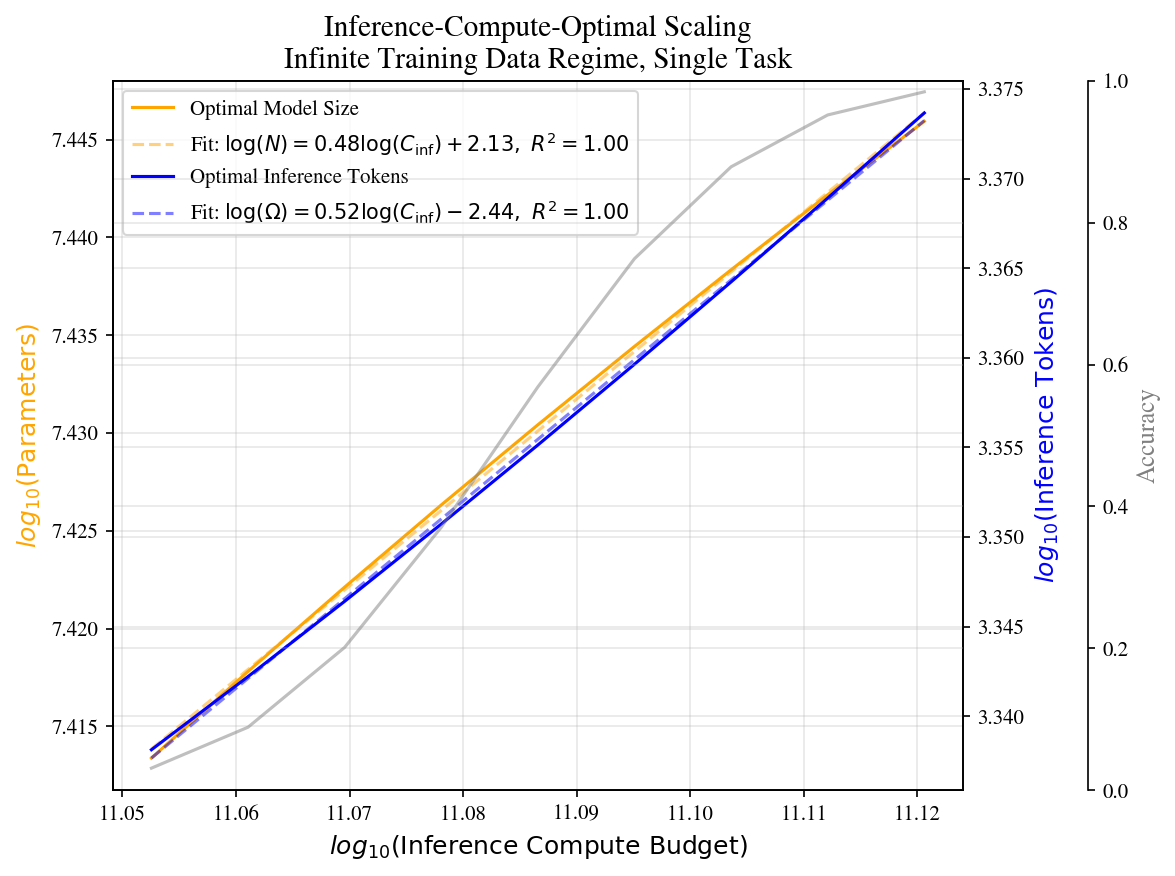

In [925]:
import numpy as np
from scipy.special import betainc
from scipy.optimize import minimize_scalar
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.special import expit  # numerically stable sigmoid

# Set professional plot style
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

PARAMETER_COLOR = 'orange'
TOKEN_COLOR = 'blue'
ACCURACY_COLOR = 'grey'
cmap = plt.get_cmap('inferno')

def sci(x, dec=1):
    """Format number in scientific notation with no '+' sign and no leading 0 in exponent (e.g., 1.3e4 instead of 1.3e+04)."""
    s = f"{x:.{dec}e}"
    base, exp = s.split("e")
    exp = exp.lstrip("+0") or "0"  # Remove '+' and leading zeros, default to "0"
    return f"{base}e{exp}"


def L_infiniteD(N, alpha=0.34, A=406.4, E=1.69):
    """L(∞,D) as a function of N (dataset size)."""
    return E + A * N**(-alpha)
    
def p(L0, L, a=1.0, b=20.0):
    """
    Probability proxy r = p(L0, L)  =  a · σ( b (L0 − L) )
    where σ is the logistic sigmoid 1/(1+e^{−x}).
    """
    return a * expit(b * (L0 - L))      # 0 < r < a

def I_r(r, k, m):
    """Incomplete beta function for probability calculation."""
    if m > k:
        return 0
    return betainc(m, k-m+1, r)

omega = 25  # Tokens per step

def objective(N, C, m, L0):
    """Objective function to maximize: I_r(p(L0, L_infiniteD(N)), C/(2*N), m)"""
    r = p(L0, L_infiniteD(N))
    k = C / (2 * N * omega)  # Number of tokens = C/(2*N*omega)
    prob = I_r(r, k, m)
    
    return prob

def find_optimal(C, m, L0):
    """
    Find the optimal setup that maximizes I_r given C, m, L0.
    
    Parameters:
    - C: Compute budget (can be scalar or array)
    - m: Number of skills required
    - L0: Skill level loss threshold
    
    Returns:
    - optimal_N: N value(s) that maximize the probability
    - optimal_tokens: Corresponding number of tokens
    - max_probability: Maximum probability achieved
    - results_C: Compute budgets corresponding to the results
    """
    
    # Handle both scalar and array inputs
    prob_low = 0.01
    prob_high = 0.99

    if np.isscalar(C):
        C = np.array([C])
    C_array = C
    results_C = []
    results_N = []
    results_prob = []

    for c in C_array:
        N_min = 1.0
        N_max = c / (2 * m * omega)
        if N_max < N_min:
            results_N.append(None)
            results_prob.append(0.0)
            results_C.append(c)
            continue
        
        # Use minimize_scalar with negated objective (since we want to maximize)
        # Using 'bounded' method for constrained optimization
        result = minimize_scalar(
            lambda N: -objective(N, c, m, L0),
            bounds=(N_min, N_max),
            method='bounded',
            options={'xatol': 0.0001}  # Tolerance for N (order of magnitude precision)
        )

        optimal_N      = result.x
        max_probability = -result.fun

        results_N.append(optimal_N)
        results_prob.append(max_probability)
        results_C.append(c)

        if max_probability > prob_high:
            break
    
    results_prob = np.array(results_prob)
    results_N = np.array(results_N)
    results_C = np.array(results_C)  # Now this is from the appended list, not C_array

    mask = (results_prob > prob_low) & (results_prob < prob_high)

    results_prob = results_prob[mask]
    results_N = results_N[mask]
    results_C = results_C[mask]

    # Compute results tokens as C/(2*N)
    results_tokens = results_C / (2 * results_N)

    # Return scalar if input was scalar
    return results_N, results_tokens, results_prob, results_C

# Parameters
m = 80  # number of skills required
L0 = 3.0  # skill level loss
C = np.logspace(8.5, 17, 1000)  # compute budgets

# Find optimal setup for each C
optimal_N_values, optimal_tokens_values, max_probabilities, C_valid = find_optimal(C, m, L0)
# Get log values for plotting
log_C_valid = np.log10(C_valid)
log_optimal_N_values = np.log10(optimal_N_values)
log_optimal_tokens_values = np.log10(optimal_tokens_values)


# Set up twin axes
fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()
ax3 = ax.twinx()

# Parameters
ax.plot(log_C_valid, log_optimal_N_values, '-', color=PARAMETER_COLOR, label='Optimal Model Size')
# Fit a line to the data
slope, intercept, r_value, p_value, std_err = linregress(log_C_valid, log_optimal_N_values)
r2_param = r_value**2
ax.plot(log_C_valid, intercept + slope * log_C_valid, '--', color=PARAMETER_COLOR, label=fr'Fit: $\log(N)={slope:.2f}\log(C_{{\mathrm{{inf}}}})+{intercept:.2f}, \ R^2={r2_param:.2f}$', alpha=0.5)
ax.set_ylabel(fr'$log_{{10}}(\mathrm{{Parameters}})$', color=PARAMETER_COLOR)

# Tokens
ax2.plot(log_C_valid, log_optimal_tokens_values, '-', color=TOKEN_COLOR, label='Optimal Inference Tokens')
# Fit a line to the data
slope, intercept, r_value, p_value, std_err = linregress(log_C_valid, log_optimal_tokens_values)
# Add in description the r2
r2_token = r_value**2
ax2.plot(log_C_valid, intercept + slope * log_C_valid, '--', color=TOKEN_COLOR, label=fr'Fit: $\log(\Omega)={slope:.2f}\log(C_{{\mathrm{{inf}}}}){intercept:.2f}, \ R^2={r2_token:.2f}$', alpha=0.5)
ax2.set_ylabel(fr'$log_{{10}}(\mathrm{{Inference\ Tokens}})$', color=TOKEN_COLOR)

# Accuracy
ax3.plot(log_C_valid, max_probabilities, '-', color=ACCURACY_COLOR, label='Accuracy', alpha=0.5)
ax3.set_ylabel('Accuracy', color=ACCURACY_COLOR)
ax3.set_ylim(0, 1)
# Offset the third axis
ax3.spines['right'].set_position(('outward', 60))
ax3.grid(False)

# Include both legends together
plt.xlabel(fr'$log_{{10}}(\mathrm{{Inference\ Compute\ Budget}})$')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines += lines2
labels += labels2
ax.legend(lines, labels, fontsize=10)
plt.title('Inference-Compute-Optimal Scaling\nInfinite Training Data Regime, Single Task')
ax.set_xlabel(fr'$log_{{10}}(\mathrm{{Inference\ Compute\ Budget}})$')
plt.grid(True)
plt.tight_layout()
plt.show()

In [967]:
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
import numpy as np
from scipy.stats import linregress

# Define ranges for the sweep
m_values = np.arange(1,101)
L0_values = np.linspace(3.0, 1.5, len(m_values)) # from high to low (decreasing L0 = harder)
C = np.logspace(8.5, 17, 1250) # Compute budget range

debug = False
if debug:
    m_values = np.logspace(0, 3, 4)
    L0_values = np.linspace(3.0, 1.5, 4) # from high to low (decreasing L0 = harder)
    # Compute budget range (using fewer points for speed)
    C = np.logspace(7, 17, 250)

print(f"Sweeping over {len(m_values)} m values and {len(L0_values)} L0 values")
print(f"m range: {m_values[0]} to {m_values[-1]}")
print(f"L0 range: {L0_values[0]:.1f} to {L0_values[-1]:.1f}")

# Create meshgrid for indexing
M_grid, L0_grid = np.meshgrid(m_values, L0_values)

# Initialize arrays to store slopes, intercepts, and R² values
token_slopes = np.full_like(M_grid, np.nan, dtype=float)
param_slopes = np.full_like(M_grid, np.nan, dtype=float)
token_intercepts = np.full_like(M_grid, np.nan, dtype=float)
param_intercepts = np.full_like(M_grid, np.nan, dtype=float)
token_r2 = np.full_like(M_grid, np.nan, dtype=float)
param_r2 = np.full_like(M_grid, np.nan, dtype=float)

def compute_cell(i, j, L0_val, m_val, C):
    try:
        Ns, Ts, probs, Cs_valid = find_optimal(C, m_val, L0_val)
        if len(Cs_valid) <= 5:
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        
        logC = np.log10(Cs_valid)
        logN = np.log10(Ns)
        logT = np.log10(Ts)
        
        p_slope, p_intercept, p_r, _, _ = linregress(logC, logN)
        t_slope, t_intercept, t_r, _, _ = linregress(logC, logT)
        
        # Calculate R² values
        p_r2 = p_r**2
        t_r2 = t_r**2
        
        # Apply threshold filter
        p_slope_out = p_slope if abs(p_r2) > 0.7 else np.nan
        t_slope_out = t_slope if abs(t_r2) > 0.7 else np.nan
        p_intercept_out = p_intercept if abs(p_r2) > 0.7 else np.nan
        t_intercept_out = t_intercept if abs(t_r2) > 0.7 else np.nan
        p_r2_out = p_r2 if abs(p_r2) > 0.7 else np.nan
        t_r2_out = t_r2 if abs(t_r2) > 0.7 else np.nan
        
        return p_slope_out, t_slope_out, p_intercept_out, t_intercept_out, p_r2_out, t_r2_out
    except:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

# ── Build the list of tasks ──
tasks = [
    (i, j, L0_values[i], m_values[j], C)
    for i in range(len(L0_values))
    for j in range(len(m_values))
]

# Pre-allocate your result arrays
param_slopes = np.full((len(L0_values), len(m_values)), np.nan)
token_slopes = np.full_like(param_slopes, np.nan)
param_intercepts = np.full_like(param_slopes, np.nan)
token_intercepts = np.full_like(param_slopes, np.nan)
param_r2 = np.full_like(param_slopes, np.nan)
token_r2 = np.full_like(param_slopes, np.nan)

# ── Run in parallel with a single tqdm bar ──
with tqdm_joblib(tqdm(total=len(tasks), desc="Computing cells")):
    results = Parallel(n_jobs=-1)(
        delayed(compute_cell)(i, j, L0_val, m_val, C)
        for (i, j, L0_val, m_val, C) in tasks
    )

# ── Unpack back into your grids ──
for idx, (i, j, *_) in enumerate(tasks):
    p_slope_out, t_slope_out, p_intercept_out, t_intercept_out, p_r2_out, t_r2_out = results[idx]
    param_slopes[i, j] = p_slope_out
    token_slopes[i, j] = t_slope_out
    param_intercepts[i, j] = p_intercept_out
    token_intercepts[i, j] = t_intercept_out
    param_r2[i, j] = p_r2_out
    token_r2[i, j] = t_r2_out

# Print some statistics
print("\nStatistics:")
print(f"Parameter slopes - Min: {np.nanmin(param_slopes):.3f}, Max: {np.nanmax(param_slopes):.3f}, Mean: {np.nanmean(param_slopes):.3f}")
print(f"Token slopes - Min: {np.nanmin(token_slopes):.3f}, Max: {np.nanmax(token_slopes):.3f}, Mean: {np.nanmean(token_slopes):.3f}")
print(f"Parameter intercepts - Min: {np.nanmin(param_intercepts):.3f}, Max: {np.nanmax(param_intercepts):.3f}, Mean: {np.nanmean(param_intercepts):.3f}")
print(f"Token intercepts - Min: {np.nanmin(token_intercepts):.3f}, Max: {np.nanmax(token_intercepts):.3f}, Mean: {np.nanmean(token_intercepts):.3f}")
print(f"Parameter R² - Min: {np.nanmin(param_r2):.3f}, Max: {np.nanmax(param_r2):.3f}, Median: {np.nanmedian(param_r2):.3f}")
print(f"Token R² - Min: {np.nanmin(token_r2):.3f}, Max: {np.nanmax(token_r2):.3f}, Median: {np.nanmedian(token_r2):.3f}")
print(f"Valid parameter fits: {np.sum(~np.isnan(param_slopes))}/{param_slopes.size}")
print(f"Valid token fits: {np.sum(~np.isnan(token_slopes))}/{token_slopes.size}")

Sweeping over 100 m values and 100 L0 values
m range: 1 to 100
L0 range: 3.0 to 1.5


Computing cells:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]


Statistics:
Parameter slopes - Min: 0.002, Max: 1.000, Mean: 0.367
Token slopes - Min: 0.245, Max: 1.000, Mean: 0.640
Parameter intercepts - Min: -1.699, Max: 10.092, Mean: 4.400
Token intercepts - Min: -10.422, Max: -0.474, Mean: -4.776
Parameter R² - Min: 0.724, Max: 1.000, Median: 0.998
Token R² - Min: 0.700, Max: 1.000, Median: 0.999
Valid parameter fits: 9980/10000
Valid token fits: 9871/10000


/var/folders/ck/wbxk_yds0659w169zr_j_3mw0000gn/T/ipykernel_32511/759449958.py:75: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, ax=ax, shrink=0.86)


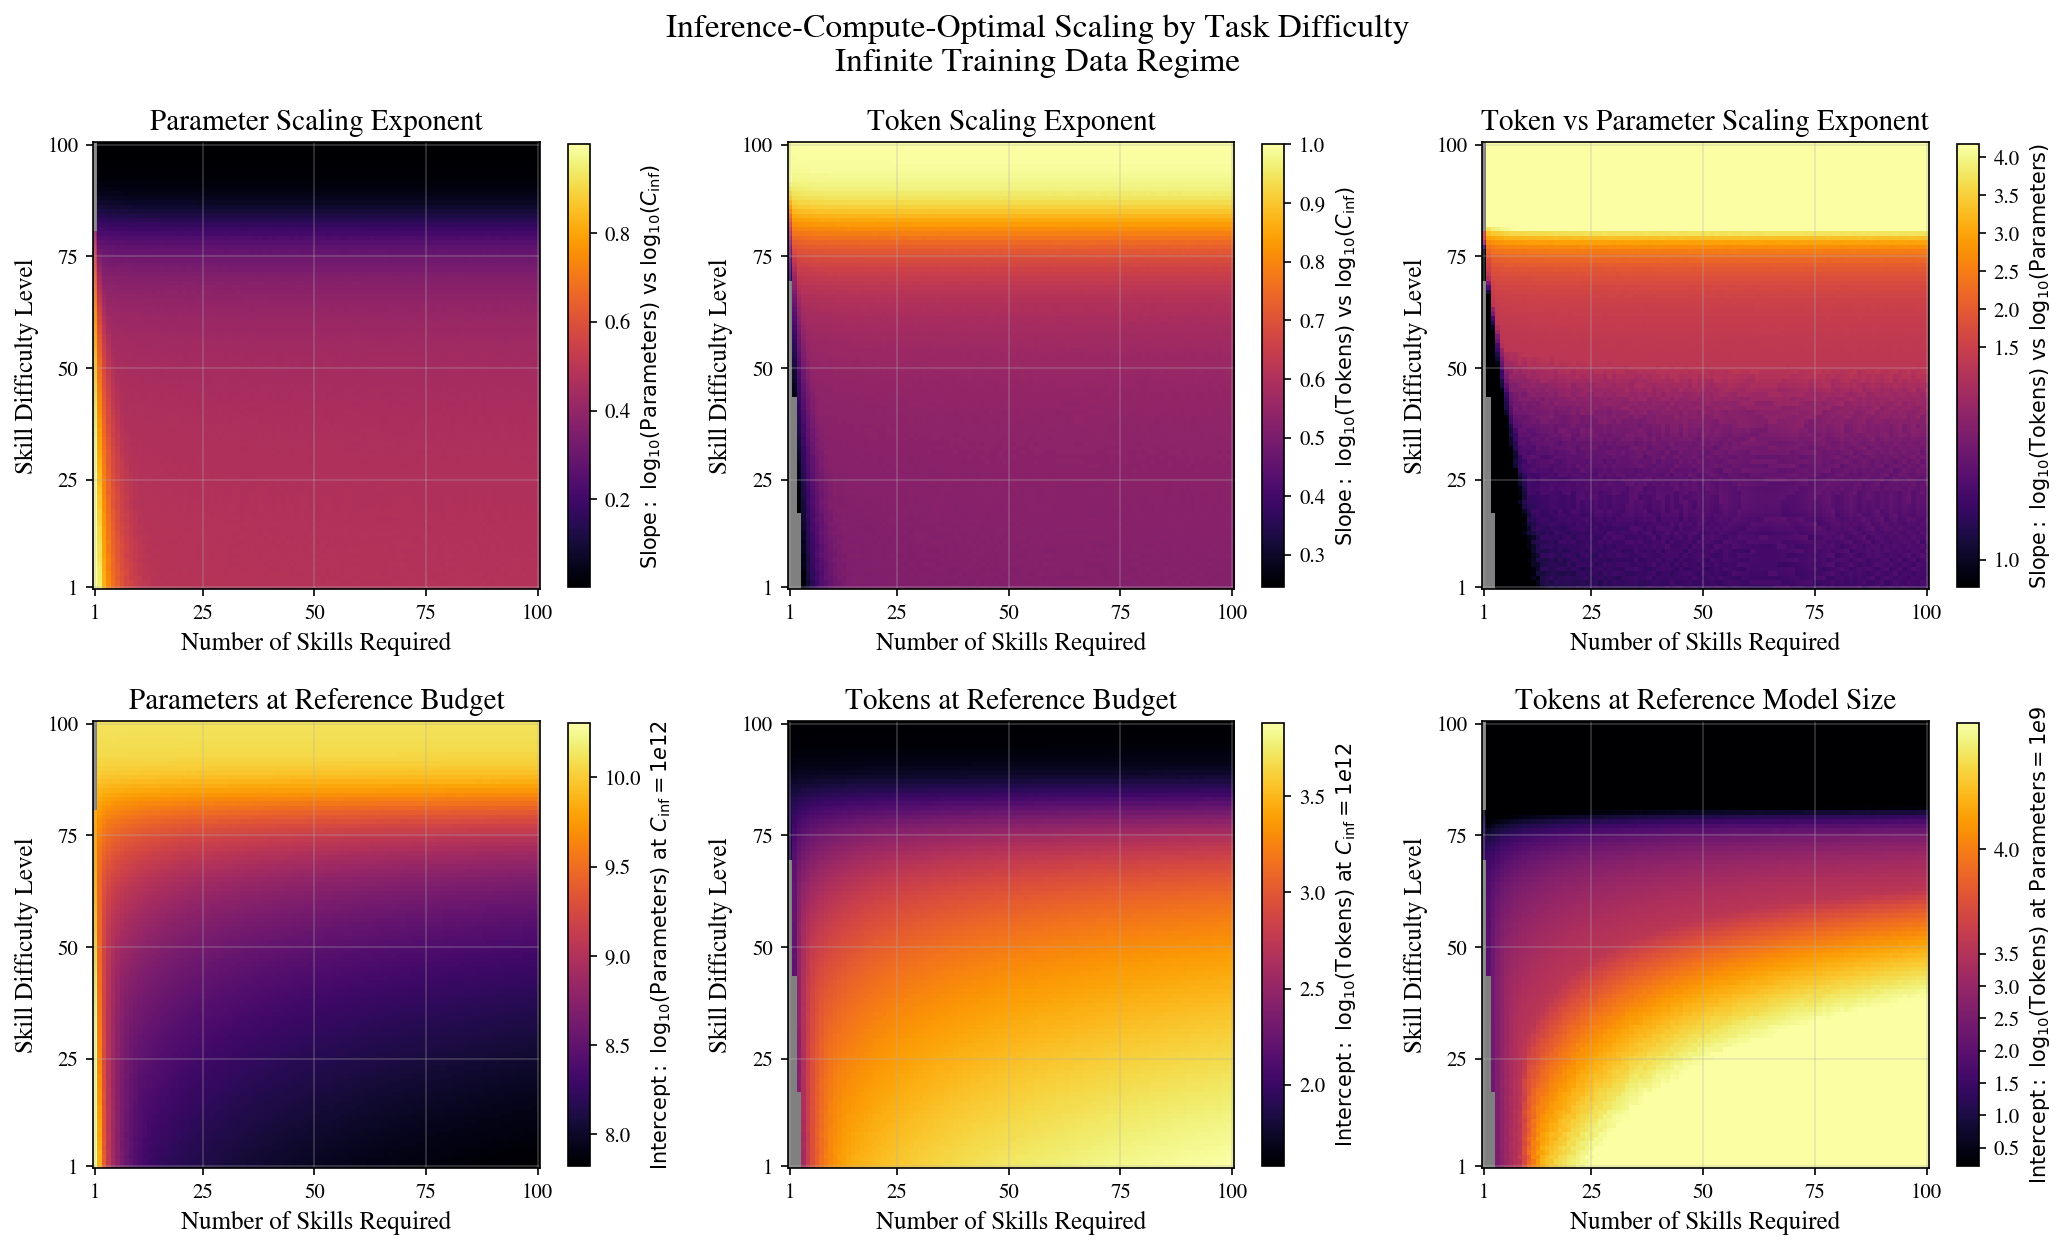

In [968]:
# ── Plotting 6 heatmaps ─────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(14,8.5))
titles = [
    "Parameter Scaling Exponent", "Token Scaling Exponent", "Token vs Parameter Scaling Exponent", "Parameters at Reference Budget",
    "Tokens at Reference Budget", "Tokens at Reference Model Size"
]
# ── Compute Token-vs-Param scaling (and intercept) ────────────────────────
# param_slopes = a,   param_intercepts = A
# token_slopes = b,   token_intercepts = B
with np.errstate(divide='ignore', invalid='ignore'):
    tn_slopes_map     = token_slopes     / param_slopes     # b/a
    tn_intercepts_map = token_intercepts - tn_slopes_map * param_intercepts  # B - (b/a)*A

C_ref    = 1e12
N_ref    = 1e9
colorbar_labels = [
    fr"$\mathrm{{Slope:\ }}\log_{{10}}(\mathrm{{Parameters}})\mathrm{{\ vs\ }}\log_{{10}}(C_{{\mathrm{{inf}}}})$",
    fr"$\mathrm{{Slope:\ }}\log_{{10}}(\mathrm{{Tokens}})\mathrm{{\ vs\ }}\log_{{10}}(C_{{\mathrm{{inf}}}})$",
    fr"$\mathrm{{Slope:\ }}\log_{{10}}(\mathrm{{Tokens}})\mathrm{{\ vs\ }}\log_{{10}}(\mathrm{{Parameters}})$",
    fr"$\mathrm{{Intercept:\ }}\log_{{10}}(\mathrm{{Parameters}})\mathrm{{\ at\ }}C_{{\mathrm{{inf}}}}={sci(C_ref,0)}$",
    fr"$\mathrm{{Intercept:\ }}\log_{{10}}(\mathrm{{Tokens}})\mathrm{{\ at\ }}C_{{\mathrm{{inf}}}}={sci(C_ref,0)}$",
    fr"$\mathrm{{Intercept:\ }}\log_{{10}}(\mathrm{{Tokens}})\mathrm{{\ at\ }}\mathrm{{Parameters}}={sci(N_ref,0)}$"
]
logC_ref = np.log10(C_ref)
logN_ref = np.log10(N_ref)
pred_N   = param_slopes     * logC_ref + param_intercepts
pred_T   = token_slopes     * logC_ref + token_intercepts
pred_TN  = tn_slopes_map * logN_ref + tn_intercepts_map
data  = [param_slopes, token_slopes, tn_slopes_map, pred_N, pred_T, pred_TN]

plt.suptitle("Inference-Compute-Optimal Scaling by Task Difficulty\nInfinite Training Data Regime", fontsize=16)
from matplotlib.colors import TwoSlopeNorm
cmap = plt.get_cmap('inferno').copy()
cmap.set_bad(color='grey')
import numpy.ma as ma
for ax, mat, title, cbar_label in zip(axes.ravel(), data, titles, colorbar_labels):
    masked = ma.masked_invalid(mat)

    if cbar_label == colorbar_labels[2]:
        # compute central value and robust vmin/vmax
        center = np.nanmedian(mat)
        vmin, vmax = np.nanpercentile(mat, [3, 80])
            # create a diverging norm centered on the mean
        norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

        # draw, passing in the norm
        im = ax.imshow(masked, origin='lower', cmap=cmap, norm=norm,
                    aspect='equal',
                    extent=[m_values[0]-0.5, m_values[-1]+0.5,
                            m_values[0]-0.5, m_values[-1]+0.5])
    elif cbar_label == colorbar_labels[5]:
        # compute central value and robust vmin/vmax
        center = np.nanmedian(mat)
        vmin, vmax = np.nanpercentile(mat, [20, 80])
            # create a diverging norm centered on the mean
        norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

        # draw, passing in the norm
        im = ax.imshow(masked, origin='lower', cmap=cmap, norm=norm,
                    aspect='equal',
                    extent=[m_values[0]-0.5, m_values[-1]+0.5,
                            m_values[0]-0.5, m_values[-1]+0.5])
    else:
        # draw, passing in the norm
        im = ax.imshow(masked, origin='lower', cmap=cmap,
                    aspect='equal',
                    extent=[m_values[0]-0.5, m_values[-1]+0.5,
                            m_values[0]-0.5, m_values[-1]+0.5])

    ax.set_xticks([1, 25, 50, 75, 100])
    ax.set_yticks([1, 25, 50, 75, 100])
    ax.set_title(title)
    ax.set_xlabel("Number of Skills Required")
    ax.set_ylabel("Skill Difficulty Level")
    cbar = plt.colorbar(im, ax=ax, shrink=0.86)
    cbar.set_label(cbar_label, fontsize=10)

plt.tight_layout()
plt.show()

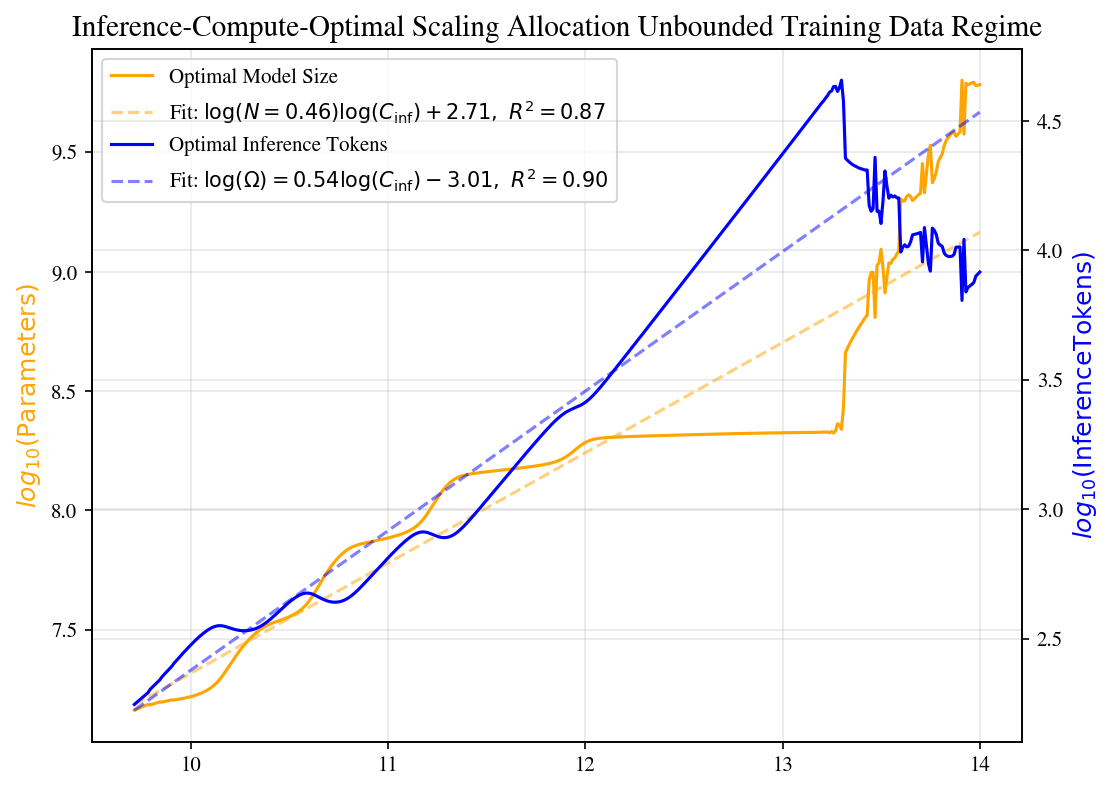

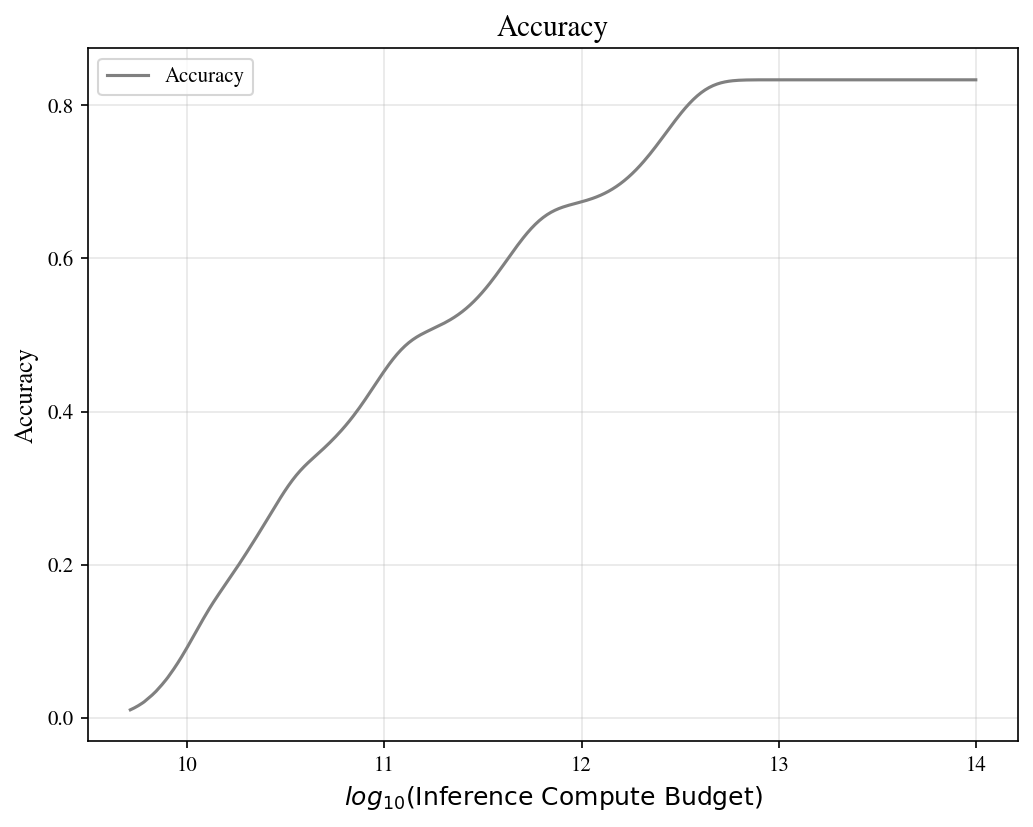

In [884]:
import numpy as np
from scipy.special import betainc
from scipy.optimize import minimize_scalar
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.special import expit  # numerically stable sigmoid

# Set professional plot style
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

PARAMETER_COLOR = 'orange'
TOKEN_COLOR = 'blue'
ACCURACY_COLOR = 'grey'
cmap = plt.get_cmap('inferno')

omega = 25  # Tokens per step

def sci(x, dec=1):
    """Format number in scientific notation with no '+' sign and no leading 0 in exponent (e.g., 1.3e4 instead of 1.3e+04)."""
    s = f"{x:.{dec}e}"
    base, exp = s.split("e")
    exp = exp.lstrip("+0") or "0"  # Remove '+' and leading zeros, default to "0"
    return f"{base}e{exp}"

def L_infiniteD(N, alpha=0.34, A=406.4, E=1.69):
    """L(∞,D) as a function of N (dataset size)."""
    return E + A * N**(-alpha)
    
def p(L0, L, a=1.0, b=5.0):
    """
    Probability proxy r = p(L0, L)  =  a · σ( b (L0 − L) )
    where σ is the logistic sigmoid 1/(1+e^{−x}).
    """
    return a * expit(b * (L0 - L))      # 0 < r < a

def I_r(r, k, m):
    """Incomplete beta function for probability calculation."""
    if m > k:
        return 0
    return betainc(m, k-m+1, r)

def phi(l, m):
    
    m_min, m_max = 1, 3
    m_vals = np.arange(m_min, m_max+1)
    l_min, l_max, delta_l0 = 2.0, 3.5, 0.4
    l_vals = np.linspace(l_max, l_min, int(np.ceil((l_max-l_min)/delta_l0)+1))
    if l < l_min or l > l_max:
        return 0
    if m < m_min or m > m_max:
        return 0
    return 1.0 / (len(l_vals) * len(m_vals))

def objective(N, C, m_difficulty, l_difficulty):
    """Objective function to maximize: I_r(p(L0, L_infiniteD(N)), C/(2*N), m)"""
    k = C / (2 * N * omega)  # Number of tokens = C/(2*N*omega)
    
    prob=0
    for l in l_vals:
        r = p(l-l_difficulty, L_infiniteD(N))
        for m in m_vals:
            prob += I_r(r, k, m+m_difficulty) * phi(l, m)
    
    return prob

def find_optimal(C, m_difficulty, l_difficulty):
    """
    Find the optimal setup that maximizes I_r given C, m, L0.
    
    Parameters:
    - C: Compute budget (can be scalar or array)
    - m: Number of skills required
    - L0: Skill level loss threshold
    
    Returns:
    - optimal_N: N value(s) that maximize the probability
    - optimal_tokens: Corresponding number of tokens
    - max_probability: Maximum probability achieved
    - results_C: Compute budgets corresponding to the results
    """
    
    # Handle both scalar and array inputs
    prob_low = 0.01
    prob_high = 0.99

    if np.isscalar(C):
        C = np.array([C])
    C_array = C
    results_C = []
    results_N = []
    results_prob = []

    for c in C_array:
        N_min = 1.0
        N_max = c / (2 * (m_min+m_difficulty) * omega)
        if N_max < N_min:
            results_N.append(None)
            results_prob.append(0.0)
            results_C.append(c)
            continue
        
        # Use minimize_scalar with negated objective (since we want to maximize)
        # Using 'bounded' method for constrained optimization
        result = minimize_scalar(
            lambda N: -objective(N, c, m_difficulty, l_difficulty),
            bounds=(N_min, N_max),
            method='bounded',
            options={'xatol': 0.0001}  # Tolerance for N (order of magnitude precision)
        )

        optimal_N      = result.x
        max_probability = -result.fun
        
        results_N.append(optimal_N)
        results_prob.append(max_probability)
        results_C.append(c)

        if max_probability > prob_high:
            break
    
    results_prob = np.array(results_prob)
    results_N = np.array(results_N)
    results_C = np.array(results_C)  # Now this is from the appended list, not C_array

    mask = (results_prob > prob_low) & (results_prob < prob_high)

    results_prob = results_prob[mask]
    results_N = results_N[mask]
    results_C = results_C[mask]

    # Compute results tokens as C/(2*N*omega)
    results_tokens = results_C / (2 * results_N)

    # Return scalar if input was scalar
    return results_N, results_tokens, results_prob, results_C

# Parameters
m_difficulty = 0
l_difficulty = 0
C = np.logspace(9, 14, 500)  # compute budgets

# Find optimal setup for each C
optimal_N_values, optimal_tokens_values, max_probabilities, C_valid = find_optimal(C, m_difficulty, l_difficulty)
# Get log values for plotting
log_C_valid = np.log10(C_valid)
log_optimal_N_values = np.log10(optimal_N_values)
log_optimal_tokens_values = np.log10(optimal_tokens_values)

# Set up twin axes
fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()

# Parameters
ax.plot(log_C_valid, log_optimal_N_values, '-', color=PARAMETER_COLOR, label='Optimal Model Size')
# Fit a line to the data
slope, intercept, r_value, p_value, std_err = linregress(log_C_valid, log_optimal_N_values)
r2_param = r_value**2
ax.plot(log_C_valid, intercept + slope * log_C_valid, '--', color=PARAMETER_COLOR, label=fr'Fit: $\log(N={slope:.2f})\log(C_{{\mathrm{{inf}}}})+{intercept:.2f}, \ R^2={r2_param:.2f}$', alpha=0.5)
ax.set_ylabel(fr'$log_{{10}}(\mathrm{{Parameters}})$', color=PARAMETER_COLOR)

# Tokens
ax2.plot(log_C_valid, log_optimal_tokens_values, '-', color=TOKEN_COLOR, label='Optimal Inference Tokens')
# Fit a line to the data
slope, intercept, r_value, p_value, std_err = linregress(log_C_valid, log_optimal_tokens_values)
# Add in description the r2
r2_token = r_value**2
ax2.plot(log_C_valid, intercept + slope * log_C_valid, '--', color=TOKEN_COLOR, label=fr'Fit: $\log(\Omega)={slope:.2f}\log(C_{{\mathrm{{inf}}}}){intercept:.2f}, \ R^2={r2_token:.2f}$', alpha=0.5)
ax2.set_ylabel(fr'$log_{{10}}(\mathrm{{Inference Tokens}})$', color=TOKEN_COLOR)

# Include both legends together
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines += lines2
labels += labels2
ax.legend(lines, labels, fontsize=10)
plt.xlabel(fr'$log_{{10}}(\mathrm{{Inference\ Compute\ Budget}})$')
plt.title('Inference-Compute-Optimal Scaling Allocation Unbounded Training Data Regime')
plt.grid(True)
plt.show()

# Plotting the accuracy across compute budgets
fig = plt.subplots(figsize=(8, 6))
plt.plot(log_C_valid, max_probabilities, '-', color=ACCURACY_COLOR, label='Accuracy')
plt.xlabel(fr'$log_{{10}}(\mathrm{{Inference\ Compute\ Budget}})$')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

23 22

Fitting Llama-3-8B...
Initial parameters: α=0.340, β=2.400, A=1.000
Optimized parameters: α=0.388, β=2.715, A=1.000
Error reduction: 0.087719 → 0.020805 (76.3% improvement)

Fitting Gemma-2B...
Initial parameters: α=0.380, β=5.500, A=0.980
Optimized parameters: α=0.361, β=4.649, A=1.000
Error reduction: 0.016606 → 0.008281 (50.1% improvement)

Fitting Pythia-2.8B...
Initial parameters: α=0.320, β=18.000, A=0.930
Optimized parameters: α=0.322, β=18.000, A=0.934
Error reduction: 0.001038 → 0.000565 (45.6% improvement)

Fitting Llama-3-8B-Instruct...
Initial parameters: α=0.340, β=2.400, A=1.000
Optimized parameters: α=0.380, β=1.134, A=1.000
Error reduction: 0.248730 → 0.002135 (99.1% improvement)

Fitting Llama-3-70B-Instruct...
Initial parameters: α=0.380, β=5.500, A=0.980
Optimized parameters: α=0.409, β=0.488, A=1.000
Error reduction: 2.260244 → 0.001945 (99.9% improvement)


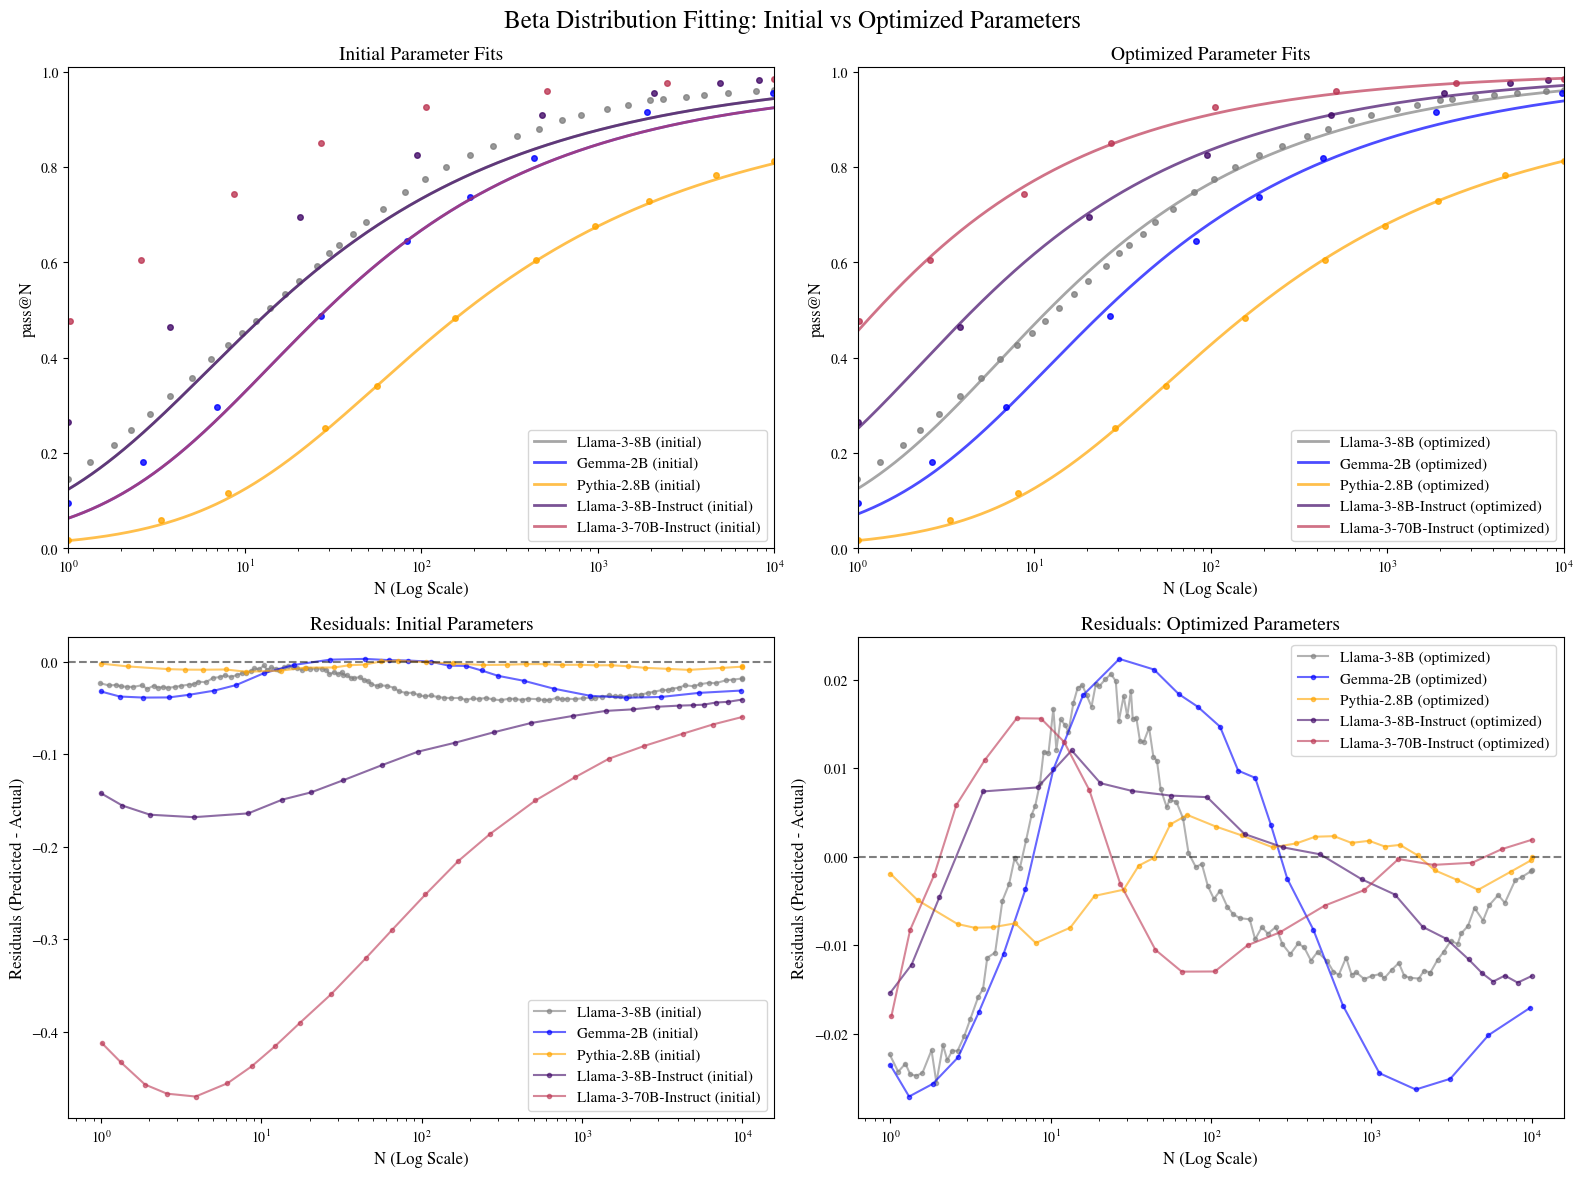


PARAMETER OPTIMIZATION SUMMARY
Model           Parameter  Initial    Optimized    Change    
--------------------------------------------------------------------------------
Llama-3-8B      α          0.340      0.388        +0.048
............... β          2.400      2.715        +0.315
............... A          1.000      1.000        +0.000
--------------------------------------------------------------------------------
Gemma-2B        α          0.380      0.361        -0.019
............... β          5.500      4.649        -0.851
............... A          0.980      1.000        +0.020
--------------------------------------------------------------------------------
Pythia-2.8B     α          0.320      0.322        +0.002
............... β          18.000     18.000       -0.000
............... A          0.930      0.934        +0.004
--------------------------------------------------------------------------------
Llama-3-8B-Instruct α          0.340      0.380        +0.04

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta as beta_fn
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Set professional plot style
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

PRIMARY_COLOR = 'blue' # Gemma-2B
SECONDARY_COLOR = 'orange' # Pythia-2.8B
TERTIARY_COLOR = 'grey' # Llama-3-8B

# Get more colors from the inferno colormap
cmap = plt.get_cmap('inferno').copy()
COLOR4 = cmap(0.2)  # Llama-3-8B-Instruct
COLOR5 = cmap(0.35)  # Llama-3-8B-Instruct Majority
COLOR6 = cmap(0.5)  # Llama-3-70B-Instruct
COLOR7 = cmap(0.6)  # Llama-3-70B-Instruct Majority

def pass_at_n_theoretical(N, alpha, beta, A):
    """Theoretical pass@N formula using Beta function"""
    try:
        return A * (1 - beta_fn(alpha, beta + N) / beta_fn(alpha, beta))
    except:
        return np.full_like(N, 0.0)

def objective_function(params, N_data, passN_data):
    """Objective function to minimize - sum of squared errors"""
    alpha, beta, A = params
    
    # Add constraints to keep parameters in reasonable ranges
    if alpha <= 0 or beta <= 0 or A <= 0 or A > 1:
        return 1e10
    
    predicted = pass_at_n_theoretical(N_data, alpha, beta, A)
    residuals = predicted - passN_data
    return np.sum(residuals**2)

def fit_parameters(N_data, passN_data, initial_params, model_name):
    """Fit Beta distribution parameters to empirical data"""
    print(f"\nFitting {model_name}...")
    print(f"Initial parameters: α={initial_params[0]:.3f}, β={initial_params[1]:.3f}, A={initial_params[2]:.3f}")
    
    # Set bounds for parameters
    bounds = [(0.01, 2.0),    # alpha bounds
              (0.1, 50.0),    # beta bounds  
              (0.1, 1.0)]     # A bounds
    
    # Optimize
    result = minimize(objective_function, 
                     initial_params,
                     args=(N_data, passN_data),
                     method='L-BFGS-B',
                     bounds=bounds)
    
    if result.success:
        alpha_opt, beta_opt, A_opt = result.x
        initial_error = objective_function(initial_params, N_data, passN_data)
        final_error = result.fun
        
        print(f"Optimized parameters: α={alpha_opt:.3f}, β={beta_opt:.3f}, A={A_opt:.3f}")
        print(f"Error reduction: {initial_error:.6f} → {final_error:.6f} ({(1-final_error/initial_error)*100:.1f}% improvement)")
        
        return result.x, True
    else:
        print(f"Optimization failed: {result.message}")
        return initial_params, False

# Load data
llama8B_passN = np.loadtxt('llama8BpassN.csv', delimiter=',', skiprows=1)
llama8B_passN = llama8B_passN[llama8B_passN[:, 0].argsort()]

pythia28B_passN = np.loadtxt('pythia28B.csv', delimiter=',', skiprows=1) 
pythia28B_passN = pythia28B_passN[pythia28B_passN[:, 0].argsort()]

gemma2B_passN = np.loadtxt('gemma2B.csv', delimiter=',', skiprows=1)
gemma2B_passN = gemma2B_passN[gemma2B_passN[:, 0].argsort()]

llama8BInstruct_passN = np.loadtxt('llama38Binstruct_oracle.csv', delimiter=',', skiprows=1)
llama8BInstruct_passN = llama8BInstruct_passN[llama8BInstruct_passN[:, 0].argsort()]

llama70BInstruct_passN = np.loadtxt('llama370Binstruct_oracle.csv', delimiter=',', skiprows=1)
llama70BInstruct_passN = llama70BInstruct_passN[llama70BInstruct_passN[:, 0].argsort()]
print(len(llama8BInstruct_passN), len(llama70BInstruct_passN))

# Initial parameters: (alpha, beta, A, label, color, data)
model_configs = [
    (0.34, 2.4, 1.0, 'Llama-3-8B', TERTIARY_COLOR, llama8B_passN),
    (0.38, 5.5, 0.98, 'Gemma-2B', PRIMARY_COLOR, gemma2B_passN), 
    (0.32, 18.0, 0.93, 'Pythia-2.8B', SECONDARY_COLOR, pythia28B_passN),
    (0.34, 2.4, 1.0, 'Llama-3-8B-Instruct', COLOR4, llama8BInstruct_passN),
    (0.38, 5.5, 0.98, 'Llama-3-70B-Instruct', COLOR6, llama70BInstruct_passN),
]

# Fit parameters for each model
fitted_configs = []
for alpha_init, beta_init, A_init, model_name, color, data in model_configs:
    N_data, passN_data = data[:, 0], data[:, 1]
    initial_params = [alpha_init, beta_init, A_init]
    
    fitted_params, success = fit_parameters(N_data, passN_data, initial_params, model_name)
    fitted_configs.append((fitted_params, model_name, color, data, initial_params))

# Create comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Beta Distribution Fitting: Initial vs Optimized Parameters', fontsize=18)

# Plot 1: Original fits
N_range = np.logspace(0, 4, 1000)
for alpha, beta, A, label, color, data in model_configs:
    passN_theory = pass_at_n_theoretical(N_range, alpha, beta, A)
    ax1.plot(N_range, passN_theory, '-', color=color, alpha=0.7, linewidth=2, 
             label=f'{label} (initial)')
    ax1.plot(data[::3, 0], data[::3, 1], 'o', color=color, markersize=4, alpha=0.8)

ax1.set_xscale('log')
ax1.set_xlabel('N (Log Scale)')
ax1.set_ylabel('pass@N')
ax1.set_title('Initial Parameter Fits')
ax1.set_xlim(1, 10000)
ax1.set_ylim(0, 1.01)
ax1.legend()

# Plot 2: Optimized fits  
for (fitted_params, model_name, color, data, _) in fitted_configs:
    alpha_opt, beta_opt, A_opt = fitted_params
    passN_theory = pass_at_n_theoretical(N_range, alpha_opt, beta_opt, A_opt)
    ax2.plot(N_range, passN_theory, '-', color=color, alpha=0.7, linewidth=2,
             label=f'{model_name} (optimized)')
    ax2.plot(data[::3, 0], data[::3, 1], 'o', color=color, markersize=4, alpha=0.8)

ax2.set_xscale('log')
ax2.set_xlabel('N (Log Scale)') 
ax2.set_ylabel('pass@N')
ax2.set_title('Optimized Parameter Fits')
ax2.set_xlim(1, 10000)
ax2.set_ylim(0, 1.01)
ax2.legend()

# Plot 3: Residuals comparison
for i, ((fitted_params, model_name, color, data, initial_params)) in enumerate(fitted_configs):
    N_data, passN_data = data[:, 0], data[:, 1]
    
    # Initial residuals
    initial_pred = pass_at_n_theoretical(N_data, *initial_params)
    initial_residuals = initial_pred - passN_data
    
    # Optimized residuals  
    opt_pred = pass_at_n_theoretical(N_data, *fitted_params)
    opt_residuals = opt_pred - passN_data
    
    ax3.plot(N_data, initial_residuals, 'o-', color=color, alpha=0.6, 
             label=f'{model_name} (initial)', markersize=3)
    ax4.plot(N_data, opt_residuals, 'o-', color=color, alpha=0.6,
             label=f'{model_name} (optimized)', markersize=3)

ax3.set_xscale('log')
ax3.set_xlabel('N (Log Scale)')
ax3.set_ylabel('Residuals (Predicted - Actual)')
ax3.set_title('Residuals: Initial Parameters')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.legend()

ax4.set_xscale('log') 
ax4.set_xlabel('N (Log Scale)')
ax4.set_ylabel('Residuals (Predicted - Actual)')
ax4.set_title('Residuals: Optimized Parameters')
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.legend()

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("PARAMETER OPTIMIZATION SUMMARY")
print("="*80)
print(f"{'Model':<15} {'Parameter':<10} {'Initial':<10} {'Optimized':<12} {'Change':<10}")
print("-"*80)

for (fitted_params, model_name, _, _, initial_params) in fitted_configs:
    alpha_init, beta_init, A_init = initial_params
    alpha_opt, beta_opt, A_opt = fitted_params
    
    print(f"{model_name:<15} {'α':<10} {alpha_init:<10.3f} {alpha_opt:<12.3f} {alpha_opt-alpha_init:+.3f}")
    print(f"{'':.<15} {'β':<10} {beta_init:<10.3f} {beta_opt:<12.3f} {beta_opt-beta_init:+.3f}")  
    print(f"{'':.<15} {'A':<10} {A_init:<10.3f} {A_opt:<12.3f} {A_opt-A_init:+.3f}")
    print("-"*80)

In [597]:
from scipy.special import betaincinv
import numpy as np
from scipy.optimize import brentq
import numpy as np
from scipy.special import beta as beta_fn
from math import factorial
from itertools import product

def compute_c_star(P_inf, A, alpha, beta):
    """
    Compute c* (the maximum relative error weight) given:
      - P_inf:  the observed asymptotic plateau P_{MV@∞}
      - A:      the scaling factor mathcal{A}
      - alpha:  the Beta distribution alpha parameter
      - beta:   the Beta distribution beta parameter
    Returns:
      c* = r_c / (1 - r_c), where r_c = I^{-1}(Δ; alpha, beta)
      and Δ = 1 - P_inf / A
    """
    Delta = 1 - P_inf / A
    if not (0 <= Delta <= 1):
        raise ValueError(f"Δ must lie in [0, 1], but got Δ = {Delta:.4f}")
    r_c = betaincinv(alpha, beta, Delta)
    return r_c / (1 - r_c)

def solve_lambda_from_c_star(c_star, M):
    """
    Given c* and number of total categories M (1 success + M-1 errors),
    find the geometric decay λ ∈ (0,1) that satisfies
      c* = (1 - λ) / (1 - λ^(M-1)).
    """
    f = lambda λ: (1 - λ) / (1 - λ**(M-1)) - c_star
    return brentq(f, 1e-8, 1 - 1e-8)

def geometric_weights(M, lambda_):
    """
    Compute the normalized geometric weights c_j for j=1..M-1:
      c_j = (1 - λ) * λ^(j-1) / (1 - λ^(M-1))
    Returns a 1D array of length M-1.
    """
    j = np.arange(1, M)
    norm = (1 - lambda_) / (1 - lambda_**(M-1))
    return norm * lambda_**(j - 1)

def compute_c_star(P_inf, A, alpha, beta):
    """
    Compute c* (the maximum relative error weight) given:
      - P_inf:  the observed asymptotic plateau P_{MV@∞}
      - A:      the scaling factor mathcal{A}
      - alpha:  the Beta distribution alpha parameter
      - beta:   the Beta distribution beta parameter

    Returns:
      c* = r_c / (1 - r_c), where r_c = I^{-1}(Δ; alpha, beta)
      and Δ = 1 - P_inf / A
    """
    # Compute Δ = 1 - P_inf/A
    Delta = 1 - P_inf / A
    
    # Validate Δ
    if not (0 <= Delta <= 1):
        raise ValueError(f"Δ must lie in [0, 1], but got Δ = {Delta:.4f}")
    
    # Invert the regularized incomplete beta to find r_c
    r_c = betaincinv(alpha, beta, Delta)
    
    # Compute c*
    c_star = r_c / (1 - r_c)
    return c_star

#TODO: if solving closed form switch to Plurality vote for consistency
def compute_P_MV_N(N, A, alpha, beta, c_vals):
    """
    Compute P_{MV@N} explicitly via the finite sum:
    
      P_{MV@N}
      = A * sum_{n_s=1..N} [ B(alpha+n_s, beta+N-n_s) / B(alpha, beta) ]
        * sum_{n_1+...+n_{M-1}=N-n_s, n_j<n_s}
          [ N!/(n_s! n_1!...n_{M-1}!) * prod_j c_j^{n_j} ]
    
    Parameters:
    - N: int, number of draws
    - A: float, scaling factor mathcal{A}
    - alpha, beta: floats, Beta distribution parameters
    - c_vals: array-like of length M-1, relative error weights c_j summing to 1
    
    Returns:
    - P_MV_N: float
    """
    M_minus1 = len(c_vals)
    total = 0.0
    
    # Precompute factorials up to N
    fact = [factorial(i) for i in range(N+1)]
    
    for n_s in range(1, N+1):
        tot_err = N - n_s
        # Beta ratio term
        beta_ratio = beta_fn(alpha + n_s, beta + tot_err) / beta_fn(alpha, beta)
        
        inner_sum = 0.0
        # Iterate over all error-count vectors (n_1,...,n_{M-1})
        # Each n_j ranges from 0 to n_s-1
        for n_j in product(range(n_s+1), repeat=M_minus1):
            if sum(n_j) != tot_err:
                continue
            # Multinomial coefficient
            coeff = fact[N] / (fact[n_s] * np.prod([fact[n] for n in n_j]))
            # Weight from c_j
            weight = np.prod([c_vals[j]**n_j[j] for j in range(M_minus1)])
            inner_sum += coeff * weight
        
        total += A * beta_ratio * inner_sum
    
    return total

def estimate_P_MV_N_mc_old(N, A, alpha, beta, c_vals, num_samples=100, random_seed=None):
    """
    Monte Carlo estimate of P_{MV@N} with correct multinomial sampling per-trial.
    Fixed shape handling by explicitly constructing the probs matrix.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
        
    # Draw r samples
    r_samples = np.random.beta(alpha, beta, size=num_samples)
    M_minus1 = len(c_vals)
    M = 1 + M_minus1
    
    # Build full probability matrix: shape (num_samples, M)
    probs = np.empty((num_samples, M))
    probs[:, 0] = r_samples                       # success probability
    probs[:, 1:] = (1 - r_samples)[:, None] * c_vals[None, :]
    
    # For each trial, sample multinomial counts
    counts = np.array([np.random.multinomial(N, p) for p in probs])

    # Determine successes (majority vote correct)
    correct = counts[:, 0] > counts[:, 1:].max(axis=1)
  
    mean_est = A * correct.mean()
    std_err  = A * np.sqrt(correct.mean() * (1 - correct.mean()) / num_samples)
    
    return mean_est, std_err

def estimate_P_MV_N_mc(N, A, alpha, beta, c_vals, num_samples=100, random_seed=None):
    """
    Monte Carlo estimate of P_{MV@N} with correct multinomial sampling per-trial,
    plus uniform-random tie-breaking among top answers.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # 1) Draw per-trial r’s
    r_samples = np.random.beta(alpha, beta, size=num_samples)

    # 2) Build full prob matrix over (correct + M-1 wrong) answers
    M_minus1 = len(c_vals)
    M = 1 + M_minus1
    probs = np.empty((num_samples, M))
    probs[:, 0] = r_samples
    probs[:, 1:] = (1 - r_samples)[:, None] * c_vals[None, :]

    # 3) Multinomial draws of N votes per trial
    counts = np.array([np.random.multinomial(N, p) for p in probs])

    # 4) Strict‐majority wins
    wrong_max = counts[:, 1:].max(axis=1)
    wins = counts[:, 0] > wrong_max

    # 5) Tie‐cases: correct votes == max(wrong votes)
    ties = counts[:, 0] == wrong_max

    #    how many wrong answers tie for that top count?
    num_wrong_tied = (counts[:, 1:] == wrong_max[:, None]).sum(axis=1)
    total_tied = 1 + num_wrong_tied  # include the correct answer

    # 6) Break ties uniformly at random
    toss = np.random.rand(num_samples)
    wins[ties] = toss[ties] < (1.0 / total_tied[ties])

    # 7) Estimate
    mean_est = A * wins.mean()
    std_err  = A * np.sqrt(wins.mean() * (1 - wins.mean()) / num_samples)

    return mean_est, std_err

N_values = np.logspace(0, 4, 100, dtype=int)
# Eliminate duplicates
N_values = np.unique(N_values)
#mv_theory = []
mv_theory_mc_8 = []
mv_theory_mc_70 = []

# Load empirical data
majority_vote_data = np.loadtxt('llama38Binstruct_maj.csv', delimiter=',', skiprows=1)
N_empirical = majority_vote_data[:, 0]
mv_empirical = majority_vote_data[:, 1]
# Store results in results_38BInstruct_maj
results_38BInstruct_maj = { 'N_emp': N_empirical, 'mv_emp': mv_empirical,
                            'N_theory': N_values, 'mv_theory_MC': mv_theory_mc_8, 'N_values_sub': None, 'mv_theory': mv_theory_mc_8, 'M': 5, 'lambda': None}

# Load empirical data
majority_vote_data = np.loadtxt('llama370Binstruct_maj.csv', delimiter=',', skiprows=1)
N_empirical = majority_vote_data[:, 0]
mv_empirical = majority_vote_data[:, 1]
# Store results in results_380BInstruct_maj
results_370BInstruct_maj = { 'N_emp': N_empirical, 'mv_emp': mv_empirical,
                            'N_theory': N_values, 'mv_theory_MC': mv_theory_mc_70, 'N_values_sub': None, 'mv_theory': mv_theory_mc_8, 'M': 4, 'lambda': None}


# Note M>=1+1/lambda
for (fitted_params, model_name, color, data, _) in fitted_configs:
    if 'Llama-3-8B-Instruct' == model_name:
      M=11
      alpha, beta, mathcal_A = fitted_params
      P_inf = results_38BInstruct_maj['mv_emp'].max()
      print(P_inf)
      c_star_value = compute_c_star(P_inf, mathcal_A, alpha, beta)
      print(f"Estimated c* for {model_name}: {c_star_value:.4f} given P_inf = {P_inf:.4f}, A = {mathcal_A:.4f}, α = {alpha:.4f}, β = {beta:.4f}")
      lambda_est = solve_lambda_from_c_star(c_star_value, M)
      results_38BInstruct_maj['M'] = M
      results_38BInstruct_maj['lambda'] = lambda_est
      c_vals = geometric_weights(M, lambda_=lambda_est)
      for N in N_values:
          #mv_theory.append( compute_P_MV_N(N, mathcal_A, alpha, beta, c_vals) )
          mv_theory_mc_8.append( estimate_P_MV_N_mc(N, mathcal_A, alpha, beta, c_vals, num_samples=100000) )
      results_38BInstruct_maj['mv_theory'] = mv_theory_mc_8
      results_370BInstruct_maj['mv_theory_MC'] = mv_theory_mc_70
    elif 'Llama-3-70B-Instruct' == model_name:
      M=9
      alpha, beta, mathcal_A = fitted_params
      P_inf = results_370BInstruct_maj['mv_emp'].max()
      print(f"P_inf for {model_name} = {P_inf:.4f}")
      c_star_value = compute_c_star(P_inf, mathcal_A, alpha, beta)
      print(f"Estimated c* for {model_name}: {c_star_value:.4f} given P_inf = {P_inf:.4f}, A = {mathcal_A:.4f}, α = {alpha:.4f}, β = {beta:.4f}")
      lambda_est = solve_lambda_from_c_star(c_star_value, M)
      results_370BInstruct_maj['M'] = M
      results_370BInstruct_maj['lambda'] = lambda_est
      c_vals = geometric_weights(M, lambda_=lambda_est)
      for N in N_values:
          #mv_theory.append( compute_P_MV_N(N, mathcal_A, alpha, beta, c_vals) )
          mv_theory_mc_70.append( estimate_P_MV_N_mc(N, mathcal_A, alpha, beta, c_vals, num_samples=100000) )
      results_370BInstruct_maj['mv_theory'] = mv_theory_mc_70
      results_370BInstruct_maj['mv_theory_MC'] = mv_theory_mc_70


0.41540785498489424
Estimated c* for Llama-3-8B-Instruct: 0.2683 given P_inf = 0.4154, A = 1.0000, α = 0.3797, β = 1.1336
P_inf for Llama-3-70B-Instruct = 0.5779
Estimated c* for Llama-3-70B-Instruct: 0.4113 given P_inf = 0.5779, A = 1.0000, α = 0.4089, β = 0.4882


In [596]:
def find_optimal_M(fitted_params, empirical_N, empirical_mv, model_name, M_range=range(4, 15)):
    """
    Find the optimal M value that minimizes error between theoretical and empirical data
    subject to constraint M > 1/lambda + 1
    """
    alpha, beta, mathcal_A = fitted_params
    P_inf = empirical_mv.max()
    c_star_value = compute_c_star(P_inf, mathcal_A, alpha, beta)
    
    best_M = None
    best_error = float('inf')
    best_lambda = None
    valid_results = []
    
    print(f"\nOptimizing M for {model_name}")
    print(f"c* = {c_star_value:.4f}")
    print("-" * 60)
    
    for M in M_range:
        try:
            # Solve for lambda given this M
            lambda_est = solve_lambda_from_c_star(c_star_value, M)
            
            # Check constraint: M >= 1/lambda + 1
            constraint_value = 1/lambda_est + 1
            if M < constraint_value:
                print(f"M={M:2d}: λ={lambda_est:.4f}, constraint=1/λ+1={constraint_value:.2f} - INVALID (M ≤ 1/λ+1)")
                continue
                
            # Compute theoretical predictions for empirical N values
            c_vals = geometric_weights(M, lambda_=lambda_est)
            theoretical_mv = []
            
            for N in empirical_N:
                # Use Monte Carlo estimation for faster computation
                mv_pred, _ = estimate_P_MV_N_mc(int(N), mathcal_A, alpha, beta, c_vals, num_samples=10000)
                theoretical_mv.append(mv_pred)
            
            theoretical_mv = np.array(theoretical_mv)
            
            # Compute error metric (you can change this)
            # Using Mean Squared Error
            mse = np.mean((theoretical_mv - empirical_mv)**2)
            
            # Using Mean Absolute Percentage Error  
            mape = np.mean(np.abs((theoretical_mv - empirical_mv) / empirical_mv)) * 100
            
            print(f"M={M:2d}: λ={lambda_est:.4f}, constraint={constraint_value:.2f}, MSE={mse:.6f}, MAPE={mape:.2f}%")
            
            valid_results.append({
                'M': M,
                'lambda': lambda_est,
                'mse': mse,
                'mape': mape,
                'theoretical_mv': theoretical_mv
            })
            
            # Update best result (using MSE as criterion, change if needed)
            if mse < best_error:
                best_error = mse
                best_M = M
                best_lambda = lambda_est
                
        except Exception as e:
            print(f"M={M:2d}: Error - {str(e)}")
            continue
    
    print("-" * 60)
    print(f"Best M = {best_M}, λ = {best_lambda:.4f}, MSE = {best_error:.6f}")
    
    return best_M, best_lambda, valid_results

# Modified version of your main loop
def optimize_models(fitted_configs):
    results_38BInstruct_maj['M_optimal'] = None
    results_370BInstruct_maj['M_optimal'] = None
    
    for (fitted_params, model_name, color, data, _) in fitted_configs:
        if 'Llama-3-8B-Instruct' == model_name:
            best_M, best_lambda, valid_results = find_optimal_M(
                fitted_params, 
                results_38BInstruct_maj['N_emp'], 
                results_38BInstruct_maj['mv_emp'],
                model_name
            )
            
            results_38BInstruct_maj['M_optimal'] = best_M
            results_38BInstruct_maj['lambda'] = best_lambda
            results_38BInstruct_maj['optimization_results'] = valid_results
            
            # Recompute with optimal M
            alpha, beta, mathcal_A = fitted_params
            c_vals = geometric_weights(best_M, lambda_=best_lambda)
            mv_theory_mc_8_optimal = []
            
            for N in N_values:
                mv_pred, _ = estimate_P_MV_N_mc(N, mathcal_A, alpha, beta, c_vals, num_samples=10000)
                mv_theory_mc_8_optimal.append(mv_pred)
            
            results_38BInstruct_maj['mv_theory'] = mv_theory_mc_8_optimal
            
        elif 'Llama-3-70B-Instruct' == model_name:
            best_M, best_lambda, valid_results = find_optimal_M(
                fitted_params,
                results_370BInstruct_maj['N_emp'], 
                results_370BInstruct_maj['mv_emp'],
                model_name
            )
            
            results_370BInstruct_maj['M_optimal'] = best_M
            results_370BInstruct_maj['lambda'] = best_lambda
            results_370BInstruct_maj['optimization_results'] = valid_results
            
            # Recompute with optimal M
            alpha, beta, mathcal_A = fitted_params
            c_vals = geometric_weights(best_M, lambda_=best_lambda)
            mv_theory_mc_70_optimal = []
            
            for N in N_values:
                mv_pred, _ = estimate_P_MV_N_mc(N, mathcal_A, alpha, beta, c_vals, num_samples=10000)
                mv_theory_mc_70_optimal.append(mv_pred)
            
            results_370BInstruct_maj['mv_theory'] = mv_theory_mc_70_optimal
            results_370BInstruct_maj['mv_theory_MC'] = mv_theory_mc_70_optimal

# Usage (once you provide fitted_configs):
optimize_models(fitted_configs)


Optimizing M for Llama-3-8B-Instruct
c* = 0.2683
------------------------------------------------------------
M= 3: Error - f(a) and f(b) must have different signs
M= 4: Error - f(a) and f(b) must have different signs
M= 5: λ=0.9532, constraint=2.05, MSE=0.000385, MAPE=4.77%
M= 6: λ=0.8526, constraint=2.17, MSE=0.000192, MAPE=3.07%
M= 7: λ=0.8044, constraint=2.24, MSE=0.000144, MAPE=2.75%
M= 8: λ=0.7780, constraint=2.29, MSE=0.000093, MAPE=2.19%
M= 9: λ=0.7623, constraint=2.31, MSE=0.000088, MAPE=2.35%
M=10: λ=0.7525, constraint=2.33, MSE=0.000120, MAPE=2.74%
M=11: λ=0.7461, constraint=2.34, MSE=0.000107, MAPE=2.44%
M=12: λ=0.7418, constraint=2.35, MSE=0.000060, MAPE=1.75%
M=13: λ=0.7388, constraint=2.35, MSE=0.000058, MAPE=1.76%
M=14: λ=0.7368, constraint=2.36, MSE=0.000068, MAPE=1.80%
M=15: λ=0.7354, constraint=2.36, MSE=0.000099, MAPE=2.19%
M=16: λ=0.7344, constraint=2.36, MSE=0.000085, MAPE=2.19%
M=17: λ=0.7336, constraint=2.36, MSE=0.000089, MAPE=2.26%
M=18: λ=0.7331, constraint=

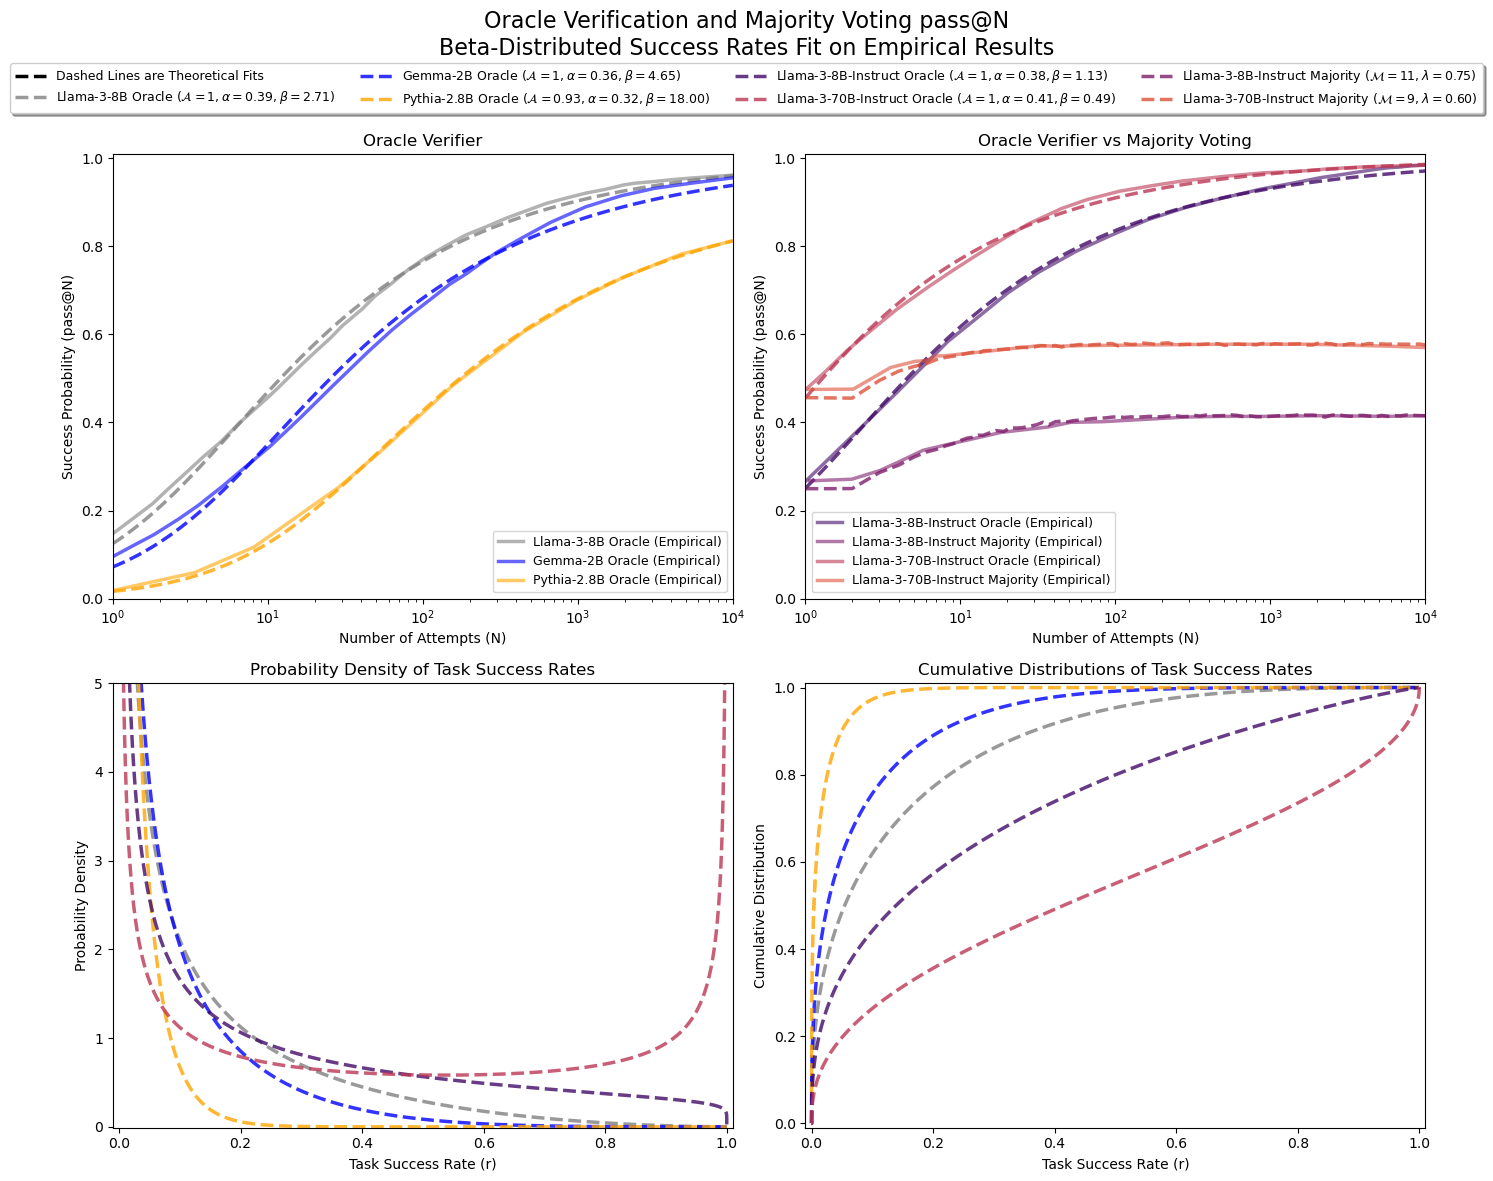

In [782]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import beta as beta_fn, betainc

# Set up 4 horizontal subplots
fig, ((ax2, ax4), (ax3, ax1)) = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)
plt.suptitle('Oracle Verification and Majority Voting pass@N\nBeta-Distributed Success Rates Fit on Empirical Results', fontsize=16)

r = np.linspace(0, 1, 100000)

# PDF Plot (3rd position)
for (fitted_params, model_name, color, data, _) in fitted_configs:
    alpha, beta, mathcal_A = fitted_params
    label = fr"{model_name} $(\mathcal{{A}}={mathcal_A:.2f}, \alpha={alpha:.2f}, \beta={beta:.2f})$"
    pdf = mathcal_A * r**(alpha - 1) * (1 - r)**(beta - 1) / beta_fn(alpha, beta)
    ax3.plot(r, pdf, '--', color=color, alpha=0.8, linewidth=2.5)

ax3.set_title("Probability Density of Task Success Rates")
ax3.set_xlabel('Task Success Rate (r)')
ax3.set_ylabel('Probability Density')
ax3.set_xlim(-.01, 1.01)
ax3.set_ylim(-0.01, 5)

# CDF Plot (4th position)
for (fitted_params, model_name, color, data, _) in fitted_configs:
    alpha, beta, mathcal_A = fitted_params
    cdf = (1 - mathcal_A) + mathcal_A * betainc(alpha, beta, r)
    label = fr"{model_name} $(\mathcal{{A}}={mathcal_A:.2f}, \alpha={alpha:.2f}, \beta={beta:.2f})$"
    ax1.step(r, cdf, '--', where='post', color=color, alpha=0.8, linewidth=2.5)

ax1.set_title("Cumulative Distributions of Task Success Rates")
ax1.set_xlabel('Task Success Rate (r)')
ax1.set_ylabel('Cumulative Distribution')
ax1.set_xlim(-0.01, 1.01)
ax1.set_ylim(-0.01, 1.01)

# pass@N Plot (1st position)
N = np.logspace(0, 4, 100)
for (fitted_params, model_name, color, data, _) in fitted_configs:
    alpha, beta, mathcal_A = fitted_params
    label = fr"{model_name} $(\mathcal{{A}}={mathcal_A:.2f}, \alpha={alpha:.2f}, \beta={beta:.2f})$"
    if 'Instruct' in label:
        continue
    passN = mathcal_A * (1 - beta_fn(alpha, beta + N) / beta_fn(alpha, beta))
    ax2.plot(N, passN, '--', color=color, alpha=0.8, linewidth=2.5)
    if 'Llama-3-8B' in label:
        ax2.plot(llama8B_passN[:, 0][::3], llama8B_passN[:, 1][::3], '-', color=TERTIARY_COLOR, label='Llama-3-8B Oracle (Empirical)', linewidth=2.5, alpha=0.6)
    elif 'Pythia' in label:
        ax2.plot(pythia28B_passN[:, 0][::3], pythia28B_passN[:, 1][::3], '-', color=SECONDARY_COLOR, label='Pythia-2.8B Oracle (Empirical)', linewidth=2.5, alpha=0.6)
    elif 'Gemma' in label:
        ax2.plot(gemma2B_passN[:, 0], gemma2B_passN[:, 1], '-', color=PRIMARY_COLOR, label='Gemma-2B Oracle (Empirical)', linewidth=2.5, alpha=0.6)

ax2.set_title("Oracle Verifier")
ax2.set_xscale('log')
ax2.set_xlabel('Number of Attempts (N)')
ax2.set_ylabel('Success Probability (pass@N)')
ax2.set_xlim(1, 10000)
ax2.set_ylim(0, 1.01)
ax2.legend(fontsize=9, loc='lower right')

# Instruct-only pass@N (2nd position) - FIXED DUPLICATE LABELS HERE
for (fitted_params, model_name, color, data, _) in fitted_configs:
    alpha, beta, mathcal_A = fitted_params
    label = fr"{model_name} Oracle $(\mathcal{{A}}={mathcal_A:.2f}, \alpha={alpha:.2f}, \beta={beta:.2f})$"
    if 'Instruct' not in label:
        continue
    passN = mathcal_A * (1 - beta_fn(alpha, beta + N) / beta_fn(alpha, beta))
    ax4.plot(N, passN, '--', color=color, alpha=0.8, linewidth=2.5)
    
    if 'Llama-3-8B-Instruct' in label:
        ax4.plot(llama8BInstruct_passN[:, 0], llama8BInstruct_passN[:, 1], '-', color=COLOR4, label='Llama-3-8B-Instruct Oracle (Empirical)', linewidth=2.5, alpha=0.6)
        # Plot majority voting for Llama-3-8B-Instruct
        M = results_38BInstruct_maj['M']
        lambda_est = results_38BInstruct_maj['lambda']
        # Only put parameters in the theoretical line label
        ax4.plot(results_38BInstruct_maj['N_theory'], np.array(results_38BInstruct_maj['mv_theory'])[:,0], '--', color=COLOR5, 
                linewidth=2.5, alpha=0.8)
        # Simpler label for empirical line
        ax4.plot(results_38BInstruct_maj['N_emp'], results_38BInstruct_maj['mv_emp'], '-', color=COLOR5, 
                label='Llama-3-8B-Instruct Majority (Empirical)', linewidth=2.5, alpha=0.6)
                
    elif 'Llama-3-70B-Instruct' in label:
        ax4.plot(llama70BInstruct_passN[:, 0], llama70BInstruct_passN[:, 1], '-', color=COLOR6, label='Llama-3-70B-Instruct Oracle (Empirical)', linewidth=2.5, alpha=0.6)
        # Plot majority voting for Llama-3-70B-Instruct
        M = results_370BInstruct_maj['M']
        lambda_est = results_370BInstruct_maj['lambda']
        # Only put parameters in the theoretical line label
        ax4.plot(results_370BInstruct_maj['N_theory'], np.array(results_370BInstruct_maj['mv_theory'])[:,0], '--', color=COLOR7,
                linewidth=2.5, alpha=0.8)
        # Simpler label for empirical line
        ax4.plot(results_370BInstruct_maj['N_emp'], results_370BInstruct_maj['mv_emp'], '-', color=COLOR7, 
                label='Llama-3-70B-Instruct Majority (Empirical)', linewidth=2.5, alpha=0.6)

legend_elements = []

legend_elements.append(plt.Line2D([0], [0], color='k', linestyle='--', linewidth=2.5, alpha=1.0, label='Dashed Lines are Theoretical Fits'))

# Add model legend entries (with parameters shown in PDF/CDF plots)
for (fitted_params, model_name, color, data, _) in fitted_configs:  # Limit to avoid duplicates
    if 'Instruct' in model_name:
        continue
    alpha, beta, mathcal_A = fitted_params
    if mathcal_A < 1:
        legend_elements.append(plt.Line2D([0], [0], color=color, linestyle='--', linewidth=2.5, alpha=0.8,
                                    label=fr"{model_name} Oracle $(\mathcal{{A}}={mathcal_A:.2f}, \alpha={alpha:.2f}, \beta={beta:.2f})$"))
    else:
        legend_elements.append(plt.Line2D([0], [0], color=color, linestyle='--', linewidth=2.5, alpha=0.8,
                                    label=fr"{model_name} Oracle $(\mathcal{{A}}={mathcal_A:.0f}, \alpha={alpha:.2f}, \beta={beta:.2f})$"))
    
#legend_elements.append(plt.Line2D([0], [0], color='white', linestyle='', alpha=0, label=''))
    

for (fitted_params, model_name, color, data, _) in fitted_configs:  # Limit to avoid duplicates
    if 'Instruct' not in model_name:
        continue
    alpha, beta, mathcal_A = fitted_params
    if mathcal_A < 1:
        legend_elements.append(plt.Line2D([0], [0], color=color, linestyle='--', linewidth=2.5, alpha=0.8,
                                    label=fr"{model_name} Oracle $(\mathcal{{A}}={mathcal_A:.2f}, \alpha={alpha:.2f}, \beta={beta:.2f})$"))
    else:
        legend_elements.append(plt.Line2D([0], [0], color=color, linestyle='--', linewidth=2.5, alpha=0.8,
                                    label=fr"{model_name} Oracle $(\mathcal{{A}}={mathcal_A:.0f}, \alpha={alpha:.2f}, \beta={beta:.2f})$"))

# Add legend element for Majority with M and lambda
legend_elements.append(plt.Line2D([0], [0], color=COLOR5, linestyle='--', linewidth=2.5, alpha=0.8, 
                                    label=fr'Llama-3-8B-Instruct Majority ($\mathcal{{M}}={results_38BInstruct_maj["M"]}, \lambda={results_38BInstruct_maj["lambda"]:.2f})$'))
legend_elements.append(plt.Line2D([0], [0], color=COLOR7, linestyle='--', linewidth=2.5, alpha=0.8,
                                    label=fr'Llama-3-70B-Instruct Majority ($\mathcal{{M}}={results_370BInstruct_maj["M"]}, \lambda={results_370BInstruct_maj["lambda"]:.2f})$'))
fig.tight_layout(rect=[0, 0, 1, 0.93])
# Create the legend at the top of the figure with better positioning
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.941), 
          ncol=4, fontsize=9, frameon=True, fancybox=True, shadow=True, 
          columnspacing=2.0, handlelength=2.5)

fig.subplots_adjust(top=.86)

ax4.set_title("Oracle Verifier vs Majority Voting")
ax4.set_xscale('log')
ax4.set_xlabel('Number of Attempts (N)')
ax4.set_ylabel('Success Probability (pass@N)')
ax4.set_xlim(1, 10000)
ax4.set_ylim(0, 1.01)
ax4.legend(fontsize=9)

plt.show()

In [647]:
# print all model name, mathcal_A, alpha, beta
for (fitted_params, model_name, _, _, _) in fitted_configs:
    alpha, beta, mathcal_A = fitted_params
    print(f"{model_name}: A={mathcal_A:.2f}, α={alpha:.2f}, β={beta:.2f}")

Llama-3-8B: A=1.00, α=0.39, β=2.71
Gemma-2B: A=1.00, α=0.36, β=4.65
Pythia-2.8B: A=0.93, α=0.32, β=18.00
Llama-3-8B-Instruct: A=1.00, α=0.38, β=1.13
Llama-3-70B-Instruct: A=1.00, α=0.41, β=0.49


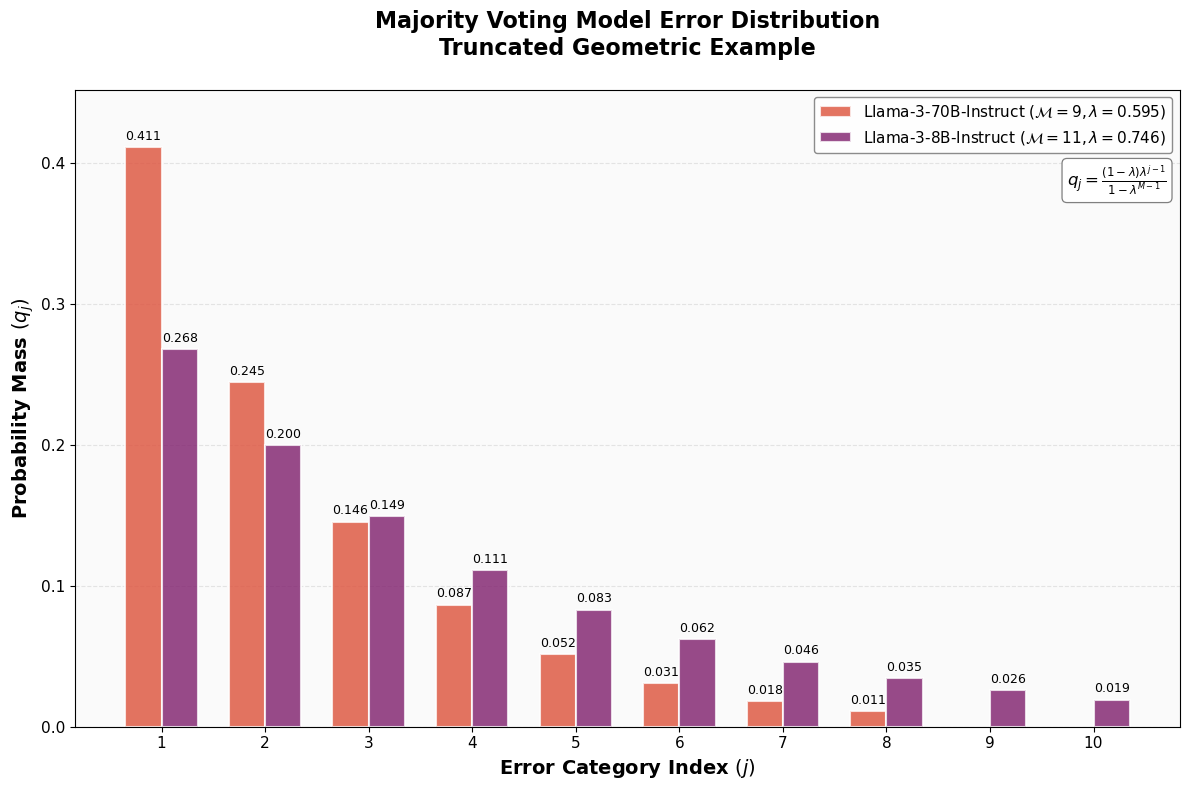

In [779]:
import matplotlib.pyplot as plt
import numpy as np

def create_pretty_pmf_plot():
    """
    Create a beautiful PMF plot for geometric error weights
    """
    
    # Calculate geometric weights
    q = geometric_weights(results_370BInstruct_maj['M'], results_370BInstruct_maj['lambda'])
    q2 = geometric_weights(results_38BInstruct_maj['M'], results_38BInstruct_maj['lambda'])
    
    # Create error category indices
    error_categories_70B = np.arange(1, len(q) + 1)
    error_categories_8B = np.arange(1, len(q2) + 1)
    
    # Create the plot with larger figure size
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Bar width for grouped bars
    width = 0.35
    
    # Adjust x positions for grouped bars
    max_categories = max(len(q), len(q2))
    x_base = np.arange(1, max_categories + 1)
    
    # Plot bars for both models
    bars1 = ax.bar(x_base[:len(q)] - width/2, q, width, 
                   color=COLOR7, alpha=0.8, 
                   label=fr'Llama-3-70B-Instruct $(\mathcal{{M}}={results_370BInstruct_maj["M"]}, \lambda={results_370BInstruct_maj["lambda"]:.3f})$',
                   edgecolor='white', linewidth=1.5)
    
    bars2 = ax.bar(x_base[:len(q2)] + width/2, q2, width,
                   color=COLOR5, alpha=0.8,
                   label=fr'Llama-3-8B-Instruct $(\mathcal{{M}}={results_38BInstruct_maj["M"]}, \lambda={results_38BInstruct_maj["lambda"]:.3f})$',
                   edgecolor='white', linewidth=1.5)
    
    # Customize the plot
    ax.set_xlabel(r'Error Category Index $(j)$', fontsize=14, fontweight='bold')
    ax.set_ylabel(r'Probability Mass $(q_j)$', fontsize=14, fontweight='bold')
    ax.set_title('Majority Voting Model Error Distribution\nTruncated Geometric Example\n', 
                 fontsize=16, fontweight='bold')
    
    # Set x-axis ticks and labels
    ax.set_xticks(x_base[:max_categories])
    ax.set_xticklabels([f'{i}' for i in range(1, max_categories + 1)])
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.set_axisbelow(True)
    
    # Customize legend
    legend = ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=False, 
                      loc='upper right', framealpha=0.9)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    
    # Add value annotations on all bars (not just first 5)
    def add_value_labels(bars, values):
        for bar, value in zip(bars, values):
            height = bar.get_height()
            if height >= 0.001:  # Lower threshold to label more bars
                ax.annotate(fr'{value:.3f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom',
                           fontsize=9, alpha=1)
    
    # Add annotations for all significant bars
    add_value_labels(bars1, q)
    add_value_labels(bars2, q2)
    
    # Improve tick formatting
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Add subtle background color
    ax.set_facecolor('#fafafa')
    
    # Set y-axis to start from 0
    ax.set_ylim(0, max(max(q), max(q2)) * 1.1)
    
    # Add explanatory text with clean white background
    textstr = r'$q_j = \frac{{(1-\lambda)\lambda^{{j-1}}}}{{1-\lambda^{{M-1}}}}$'

    props = dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='gray', linewidth=.9)
    ax.text(.943, 0.884, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props, horizontalalignment='center')
    
    # Tight layout to prevent label cutoff
    plt.tight_layout()
    
    return fig, ax

# Create the main plot
fig, ax = create_pretty_pmf_plot()
plt.show()

# If you prefer side-by-side comparison:
# fig_sub, axes_sub = create_subplot_pmf_plot()
# plt.show() + '\nHigher j = less likely error category'

Finding optimal M value for Llama-3-70B-Instruct...
Testing different M values...
Testing M = 5...
M = 5: Failed - expected a sequence of integers or a single integer, got '0.5779'
Testing M = 6...
M = 6: Failed - expected a sequence of integers or a single integer, got '0.5779'
Testing M = 7...
M = 7: Failed - expected a sequence of integers or a single integer, got '0.5779'
Testing M = 8...
M = 8: Failed - expected a sequence of integers or a single integer, got '0.5779'
Testing M = 9...
M = 9: Failed - expected a sequence of integers or a single integer, got '0.5779'
Testing M = 10...
M = 10: Failed - expected a sequence of integers or a single integer, got '0.5779'
Testing M = 15...
M = 15: Failed - expected a sequence of integers or a single integer, got '0.5779'
Testing M = 20...
M = 20: Failed - expected a sequence of integers or a single integer, got '0.5779'
Testing M = 30...
M = 30: Failed - expected a sequence of integers or a single integer, got '0.5779'
Testing M = 50...
M

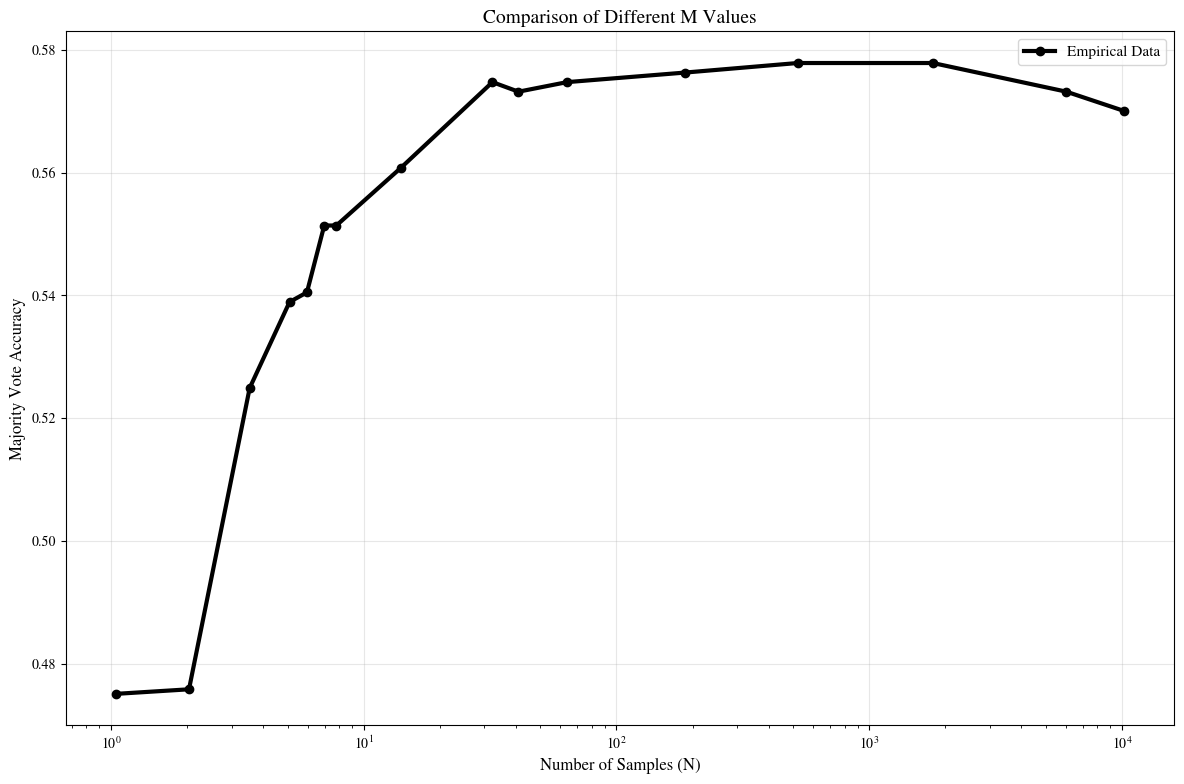


Recommended M value: 5


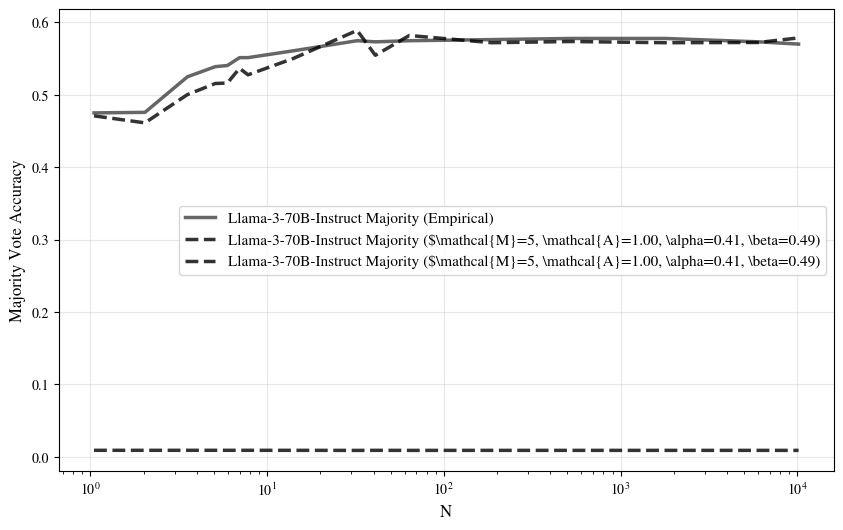

Finding optimal M value for Llama-3-8B-Instruct...
Testing different M values...
Testing M = 5...
M = 5: Failed - expected a sequence of integers or a single integer, got '0.4154'
Testing M = 6...
M = 6: Failed - expected a sequence of integers or a single integer, got '0.4154'
Testing M = 7...
M = 7: Failed - expected a sequence of integers or a single integer, got '0.4154'
Testing M = 8...
M = 8: Failed - expected a sequence of integers or a single integer, got '0.4154'
Testing M = 9...
M = 9: Failed - expected a sequence of integers or a single integer, got '0.4154'
Testing M = 10...
M = 10: Failed - expected a sequence of integers or a single integer, got '0.4154'
Testing M = 15...
M = 15: Failed - expected a sequence of integers or a single integer, got '0.4154'
Testing M = 20...
M = 20: Failed - expected a sequence of integers or a single integer, got '0.4154'
Testing M = 30...
M = 30: Failed - expected a sequence of integers or a single integer, got '0.4154'
Testing M = 50...
M 

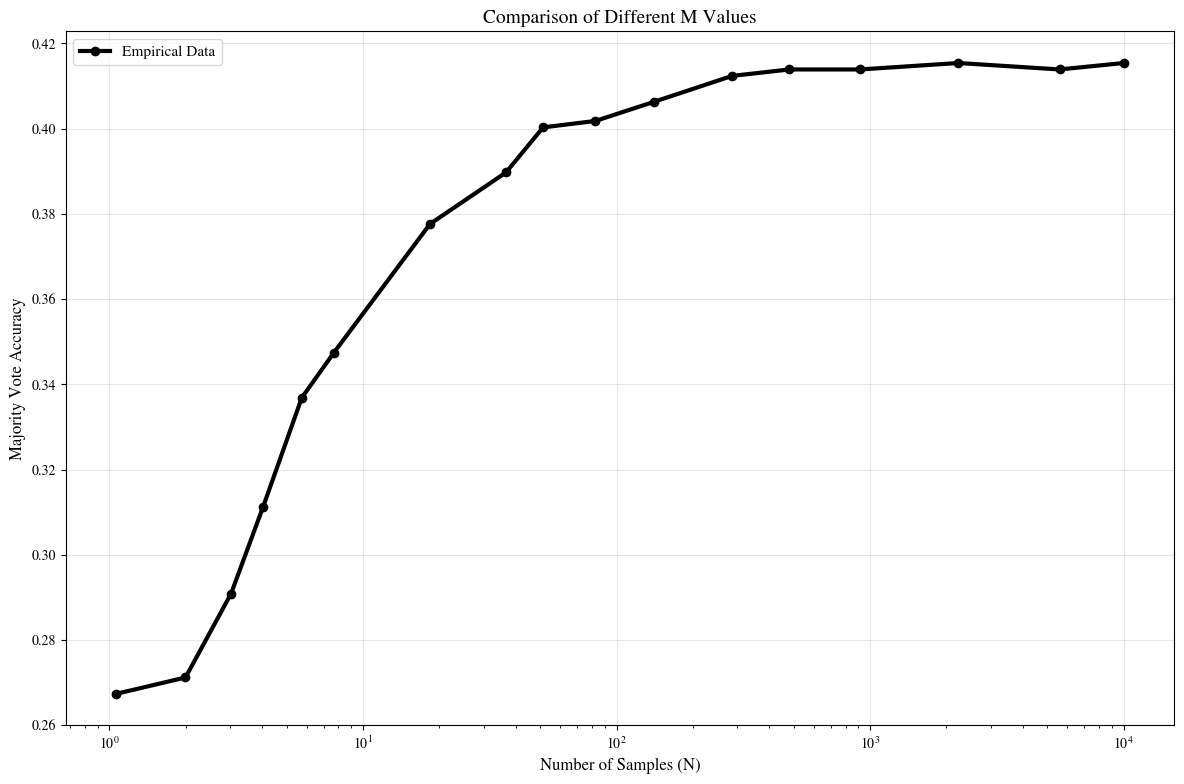


Recommended M value: 5


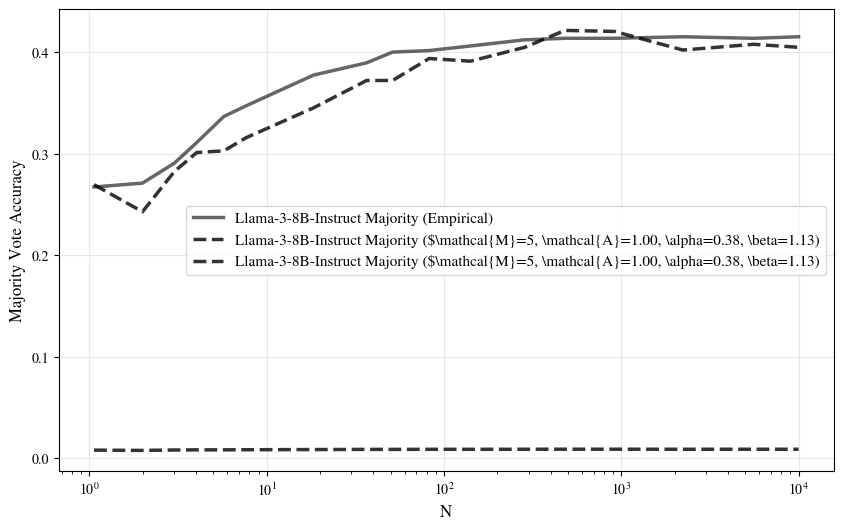


SUMMARY:
Optimal M value: 5
Final MSE: inf
This means your model effectively behaves as if it has ~5 categories


In [569]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.special import betaincinv
from scipy.optimize import brentq

def compute_c_star(P_inf, A, alpha, beta):
    """Compute c* from observed plateau"""
    Delta = 1 - P_inf / A
    if not (0 <= Delta <= 1):
        raise ValueError(f"Δ must lie in [0, 1], but got Δ = {Delta:.4f}")
    r_c = betaincinv(alpha, beta, Delta)
    return r_c / (1 - r_c)

def solve_lambda_from_c_star(c_star, M):
    """Find λ given c* and M"""
    f = lambda λ: (1 - λ) / (1 - λ**(M-1)) - c_star
    return brentq(f, 1e-8, 1 - 1e-8)

def geometric_weights(M, lambda_):
    """Generate geometric weights"""
    j = np.arange(1, M)
    norm = (1 - lambda_) / (1 - lambda_**(M-1))
    return norm * lambda_**(j - 1)

def compute_theoretical_curve(N_values, M, A, alpha, beta, P_inf):
    """Compute theoretical MV curve for given M"""
    try:
        c_star = compute_c_star(P_inf, A, alpha, beta)
        lambda_est = solve_lambda_from_c_star(c_star, M)
        c_vals = geometric_weights(M, lambda_est)
        
        theory_values = []
        for N in N_values:
            mv_est = estimate_P_MV_N_mc(N, A, alpha, beta, c_vals, num_samples=3000)
            theory_values.append(mv_est)
        
        return np.array(theory_values)
    except:
        # Return high error if computation fails
        return np.full(len(N_values), np.inf)

def objective_function(M, N_emp, mv_emp, A, alpha, beta, P_inf):
    """Objective function to minimize: MSE between theory and empirical"""
    if M < 2:
        return np.inf
    
    M = int(round(M))
    theory_values = estimate_P_MV_N_mc(N_emp, M, A, alpha, beta, P_inf)
    
    if np.any(np.isinf(theory_values)):
        return np.inf
    
    # Mean Squared Error
    mse = np.mean((theory_values - mv_emp)**2)
    return mse

def find_best_M(N_emp, mv_emp, A, alpha, beta, P_inf, M_range=None):
    """Find the best M value by grid search or optimization"""
    
    if M_range is None:
        M_range = [5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 100, 200, 500, 1000]
    
    results = []
    
    print("Testing different M values...")
    for M in M_range:
        print(f"Testing M = {M}...")
        try:
            mse = objective_function(M, N_emp, mv_emp, A, alpha, beta, P_inf)
            results.append((M, mse))
            print(f"M = {M}: MSE = {mse:.6f}")
        except Exception as e:
            print(f"M = {M}: Failed - {str(e)}")
            results.append((M, np.inf))
    
    # Find best M
    results.sort(key=lambda x: x[1])
    best_M, best_mse = results[0]
    
    print(f"\nBest M = {best_M} with MSE = {best_mse:.6f}")
    
    # Print top 5 results
    print("\nTop 5 results:")
    for i, (M, mse) in enumerate(results[:5]):
        print(f"{i+1}. M = {M}: MSE = {mse:.6f}")
    
    return best_M, results

def plot_best_fit_comparison(N_emp, mv_emp, A, alpha, beta, P_inf, M_candidates=None):
    """Plot comparison of different M values"""
    
    if M_candidates is None:
        M_candidates = [3, 5, 10, 20, 50, 100]
    
    plt.figure(figsize=(12, 8))
    
    # Plot empirical data
    plt.plot(N_emp, mv_emp, 'o-', color='black', linewidth=3, 
             label='Empirical Data', markersize=6)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(M_candidates)))
    
    # Plot theoretical curves for different M values
    for i, M in enumerate(M_candidates):
        try:
            theory_values = compute_theoretical_curve(N_emp, M, A, alpha, beta, P_inf)
            mse = np.mean((theory_values - mv_emp)**2)
            
            plt.plot(N_emp, theory_values, '--', color=colors[i], linewidth=2,
                     label=f'M = {M} (MSE = {mse:.4f})', alpha=0.8)
        except Exception as e:
            print(f"Failed to compute for M = {M}: {e}")
    
    plt.xscale('log')
    plt.xlabel('Number of Samples (N)')
    plt.ylabel('Majority Vote Accuracy')
    plt.title('Comparison of Different M Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage with your Llama-3-70B-Instruct data:

# Your fitted parameters
alpha_fitted = 0.4089
beta_fitted = 0.4882
mathcal_A = 1.0000
P_inf = 0.5779

# Your empirical data
N_emp = results_370BInstruct_maj['N_emp']
mv_emp = results_370BInstruct_maj['mv_emp']

# Find best M value
print("Finding optimal M value for Llama-3-70B-Instruct...")
best_M, all_results = find_best_M(N_emp, mv_emp, mathcal_A, alpha_fitted, beta_fitted, P_inf)

# Plot comparison of different M values
plot_best_fit_comparison(N_emp, mv_emp, mathcal_A, alpha_fitted, beta_fitted, P_inf, 
                        M_candidates=[5, 6, 7, 8, 9, best_M])

print(f"\nRecommended M value: {best_M}")

# Generate final theoretical curve with best M
best_theory = compute_theoretical_curve(N_emp, best_M, mathcal_A, alpha_fitted, beta_fitted, P_inf)

# Create your updated plot
COLOR7 = 'k'  # Replace with your actual color
plt.figure(figsize=(10, 6))
plt.plot(N_emp, mv_emp, '-', color=COLOR7, 
         label='Llama-3-70B-Instruct Majority (Empirical)', linewidth=2.5, alpha=0.6)
plt.plot(N_emp, best_theory, '--', color=COLOR7, label=fr'Llama-3-70B-Instruct Majority ($\mathcal{{M}}={best_M}, \mathcal{{A}}={mathcal_A:.2f}, \alpha={alpha_fitted:.2f}, \beta={beta_fitted:.2f})', linewidth=2.5, alpha=0.8)
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Majority Vote Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Usage with your Llama-3-8B-Instruct data:
# fit parameters
# P_inf = 0.4154, A = 1.0000, α = 0.3797, β = 1.1336
alpha_fitted = 0.3797
beta_fitted = 1.1336
mathcal_A = 1.0000
P_inf = 0.4154

# Your empirical data
N_emp = results_38BInstruct_maj['N_emp']
mv_emp = results_38BInstruct_maj['mv_emp']

# Find best M value
print("Finding optimal M value for Llama-3-8B-Instruct...")
best_M, all_results = find_best_M(N_emp, mv_emp, mathcal_A, alpha_fitted, beta_fitted, P_inf)

# Plot comparison of different M values
plot_best_fit_comparison(N_emp, mv_emp, mathcal_A, alpha_fitted, beta_fitted, P_inf, 
                        M_candidates=[5, 6, 7, 8, 9, 10, 11, 12, best_M])

print(f"\nRecommended M value: {best_M}")

# Generate final theoretical curve with best M
best_theory = compute_theoretical_curve(N_emp, best_M, mathcal_A, alpha_fitted, beta_fitted, P_inf)

# Create your updated plot
COLOR7 = 'k'  # Replace with your actual color
plt.figure(figsize=(10, 6))
plt.plot(N_emp, mv_emp, '-', color=COLOR7, 
         label='Llama-3-8B-Instruct Majority (Empirical)', linewidth=2.5, alpha=0.6)
plt.plot(N_emp, best_theory, '--', color=COLOR7, label=fr'Llama-3-8B-Instruct Majority ($\mathcal{{M}}={best_M}, \mathcal{{A}}={mathcal_A:.2f}, \alpha={alpha_fitted:.2f}, \beta={beta_fitted:.2f})', linewidth=2.5, alpha=0.8)
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Majority Vote Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary
print(f"\nSUMMARY:")
print(f"Optimal M value: {best_M}")
print(f"Final MSE: {all_results[0][1]:.6f}")
print(f"This means your model effectively behaves as if it has ~{best_M} categories")

Target c* = 0.4113

Testing Geometric distribution...
  M=3: Failed - f(a) and f(b) must have different signs
  M=5: MSE=0.000325, c*_actual=0.4113
  M=8: MSE=0.000489, c*_actual=0.4113
  M=10: MSE=0.000509, c*_actual=0.4113
  M=15: MSE=0.000438, c*_actual=0.4113
  M=20: MSE=0.000478, c*_actual=0.4113
  M=30: MSE=0.000454, c*_actual=0.4113
  M=50: MSE=0.000454, c*_actual=0.4113
  Best: M=5, MSE=0.000325

Testing Power Law distribution...
  M=3: MSE=0.000824, c*_actual=0.5173
  M=5: MSE=0.000267, c*_actual=0.4113
  M=8: MSE=0.000738, c*_actual=0.4113
  M=10: MSE=0.000870, c*_actual=0.4113
  M=15: MSE=0.000783, c*_actual=0.4113
  M=20: MSE=0.000896, c*_actual=0.4113
  M=30: MSE=0.000882, c*_actual=0.4113
  M=50: MSE=0.001034, c*_actual=0.4113
  Best: M=5, MSE=0.000267

Testing Exponential distribution...
  M=3: MSE=0.000827, c*_actual=0.5025
  M=5: MSE=0.000325, c*_actual=0.4113
  M=8: MSE=0.000489, c*_actual=0.4113
  M=10: MSE=0.000509, c*_actual=0.4113
  M=15: MSE=0.000437, c*_actual=0

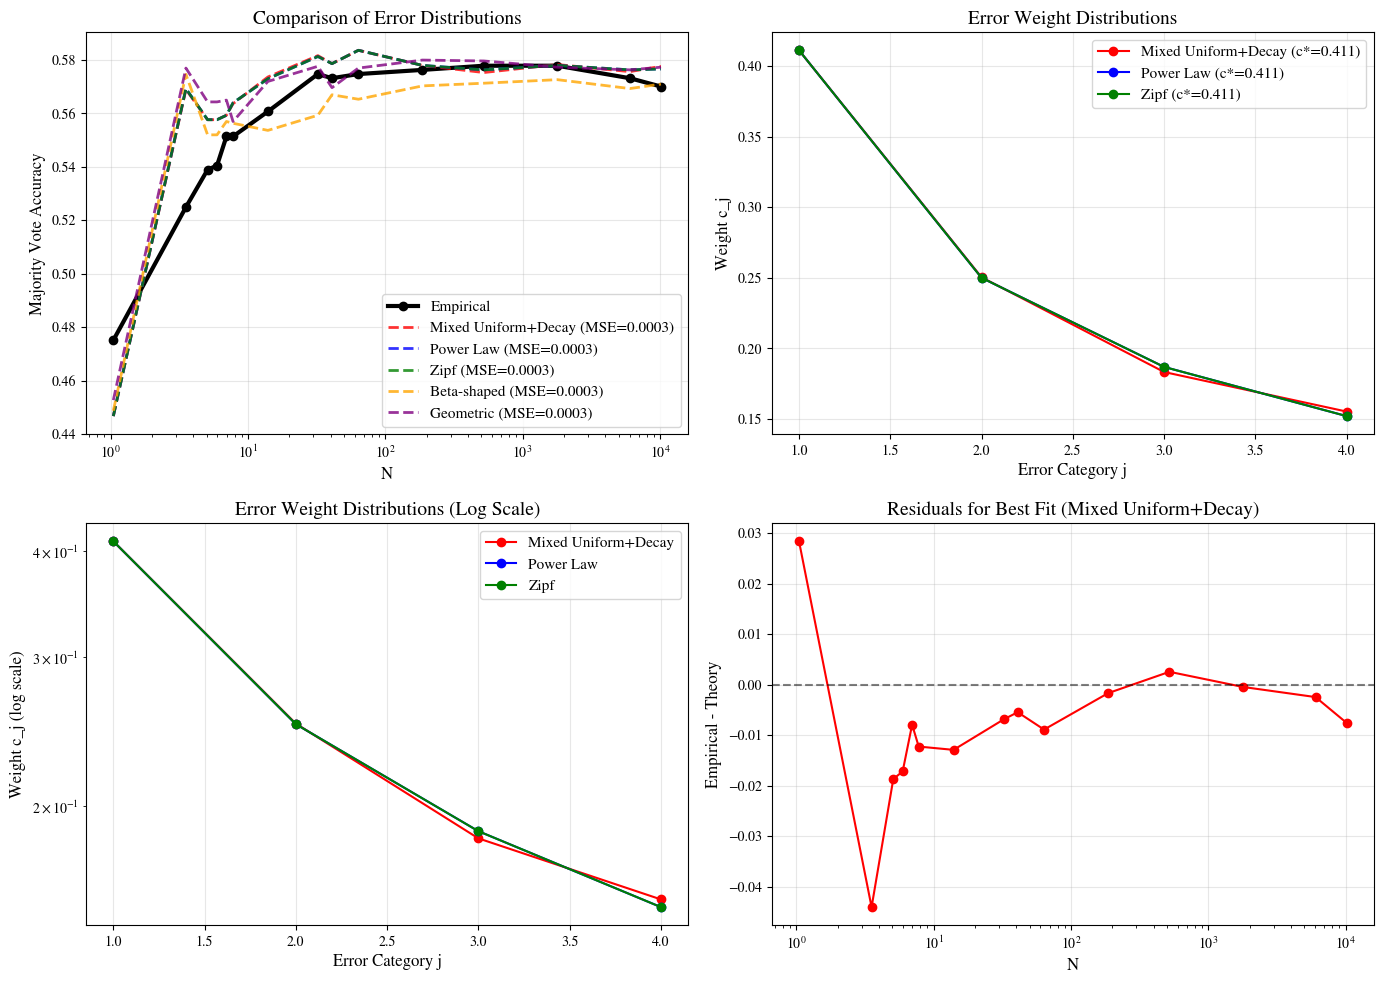

Best distribution: Mixed Uniform+Decay
Best parameters: {'uniform_frac': 0.5402631824843692, 'decay_rate': 0.8735241804074337, 'M': 5, 'weights': array([0.41126255, 0.25037178, 0.18320347, 0.1551622 ])}
Target c* = 0.2683

Testing Geometric distribution...
  M=3: Failed - f(a) and f(b) must have different signs
  M=5: MSE=0.000307, c*_actual=0.2683
  M=8: MSE=0.001078, c*_actual=0.2683
  M=10: MSE=0.000995, c*_actual=0.2683
  M=15: MSE=0.001248, c*_actual=0.2683
  M=20: MSE=0.001018, c*_actual=0.2683
  M=30: MSE=0.001327, c*_actual=0.2683
  M=50: MSE=0.001305, c*_actual=0.2683
  Best: M=5, MSE=0.000307

Testing Power Law distribution...
  M=3: MSE=0.007739, c*_actual=0.5173
  M=5: MSE=0.000309, c*_actual=0.2703
  M=8: MSE=0.001032, c*_actual=0.2683
  M=10: MSE=0.001473, c*_actual=0.2683
  M=15: MSE=0.001772, c*_actual=0.2683
  M=20: MSE=0.002155, c*_actual=0.2683
  M=30: MSE=0.002381, c*_actual=0.2683
  M=50: MSE=0.002522, c*_actual=0.2683
  Best: M=5, MSE=0.000309

Testing Exponential

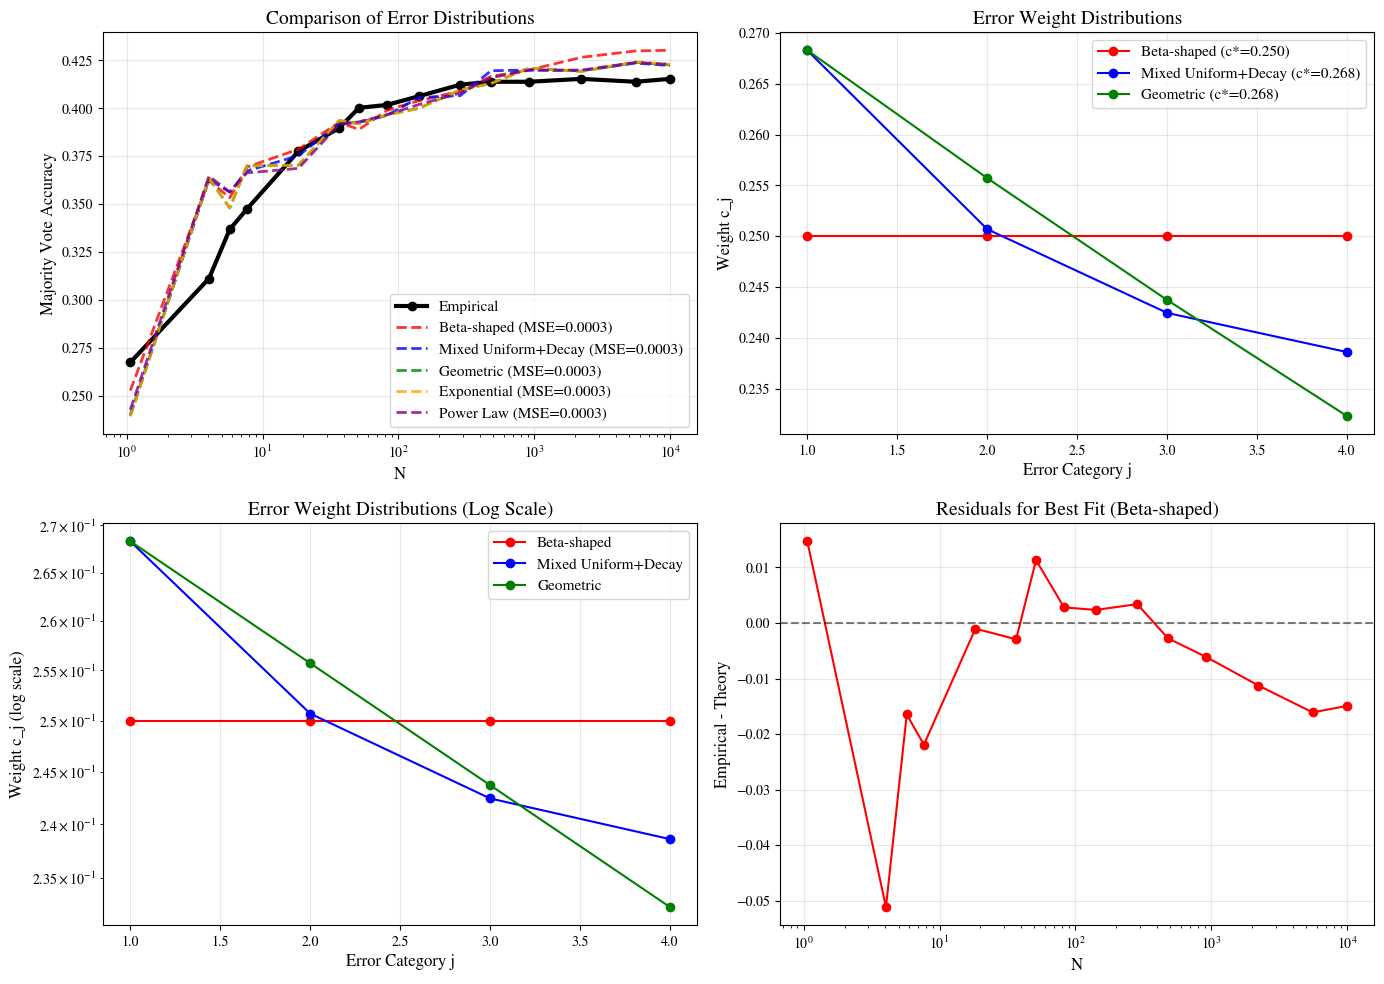

In [431]:
import numpy as np
from scipy.optimize import minimize_scalar, brentq
from scipy.special import betaincinv, gamma
import matplotlib.pyplot as plt

# ============================================================================
# ALTERNATIVE ERROR WEIGHT DISTRIBUTIONS
# ============================================================================

def power_law_weights(M, gamma):
    """
    Power law decay: c_j ∝ j^(-γ)
    Slower initial decay than geometric, good for more distributed errors
    """
    j = np.arange(1, M)
    unnorm = j**(-gamma)
    return unnorm / unnorm.sum()

def exponential_weights(M, rate):
    """
    Exponential decay: c_j ∝ exp(-rate * j)
    Similar to geometric but with different parameterization
    """
    j = np.arange(1, M)
    unnorm = np.exp(-rate * j)
    return unnorm / unnorm.sum()

def beta_shaped_weights(M, alpha_err, beta_err):
    """
    Beta-like distribution over error categories
    More flexible shape, can be U-shaped, bell-shaped, etc.
    """
    j = np.arange(1, M)
    # Map j to [0,1] interval
    x = (j - 1) / (M - 2) if M > 2 else np.array([0.5])
    # Beta PDF (unnormalized is fine since we normalize)
    unnorm = x**(alpha_err - 1) * (1 - x)**(beta_err - 1)
    return unnorm / unnorm.sum()

def zipf_weights(M, s):
    """
    Zipf distribution: c_j ∝ j^(-s)
    Heavy-tailed, good for very concentrated errors in first few categories
    """
    j = np.arange(1, M)
    unnorm = j**(-s)
    return unnorm / unnorm.sum()

def pareto_weights(M, alpha_par, scale=1):
    """
    Pareto distribution over error categories
    Very heavy-tailed, extreme concentration in first few categories
    """
    j = np.arange(1, M)
    # Pareto PDF: α * scale^α / x^(α+1) for x >= scale
    x = j + scale - 1  # Shift so minimum is scale
    unnorm = alpha_par * (scale**alpha_par) / (x**(alpha_par + 1))
    return unnorm / unnorm.sum()

def mixed_uniform_decay(M, uniform_frac, decay_rate):
    """
    Mixture: uniform component + exponential decay
    uniform_frac: fraction of weight that's uniform
    Good for models with both systematic and random errors
    """
    j = np.arange(1, M)
    uniform_part = np.ones(M-1) / (M-1)
    decay_part = np.exp(-decay_rate * j)
    decay_part = decay_part / decay_part.sum()
    
    weights = uniform_frac * uniform_part + (1 - uniform_frac) * decay_part
    return weights / weights.sum()

def log_normal_weights(M, mu, sigma):
    """
    Log-normal distribution over error categories
    Can produce various shapes depending on parameters
    """
    j = np.arange(1, M)
    unnorm = np.exp(-(np.log(j) - mu)**2 / (2 * sigma**2)) / (j * sigma * np.sqrt(2 * np.pi))
    return unnorm / unnorm.sum()

# ============================================================================
# FITTING FUNCTIONS FOR EACH DISTRIBUTION
# ============================================================================

def fit_power_law(M, target_c_star):
    """Find γ such that max(power_law_weights(M, γ)) = target_c_star"""
    def objective(gamma):
        weights = power_law_weights(M, gamma)
        return (weights.max() - target_c_star)**2
    
    result = minimize_scalar(objective, bounds=(0.1, 10), method='bounded')
    return result.x

def fit_exponential(M, target_c_star):
    """Find rate such that max(exponential_weights(M, rate)) = target_c_star"""
    def objective(rate):
        weights = exponential_weights(M, rate)
        return (weights.max() - target_c_star)**2
    
    result = minimize_scalar(objective, bounds=(0.01, 10), method='bounded')
    return result.x

def fit_zipf(M, target_c_star):
    """Find s such that max(zipf_weights(M, s)) = target_c_star"""
    def objective(s):
        weights = zipf_weights(M, s)
        return (weights.max() - target_c_star)**2
    
    result = minimize_scalar(objective, bounds=(0.1, 5), method='bounded')
    return result.x

def fit_mixed_uniform_decay(M, target_c_star):
    """Find uniform_frac and decay_rate for target c*"""
    def objective(params):
        uniform_frac, decay_rate = params
        if not (0 <= uniform_frac <= 1) or decay_rate <= 0:
            return 1e10
        weights = mixed_uniform_decay(M, uniform_frac, decay_rate)
        return (weights.max() - target_c_star)**2
    
    from scipy.optimize import minimize
    result = minimize(objective, [0.3, 1.0], 
                     bounds=[(0, 1), (0.01, 10)], method='L-BFGS-B')
    return result.x

# ============================================================================
# MAIN OPTIMIZATION FUNCTION
# ============================================================================

def test_alternative_distributions(N_emp, mv_emp, A, alpha, beta, P_inf, M_fixed=None):
    """
    Test different error weight distributions to find best fit
    """
    # Compute target c* from observed plateau
    c_star_target = compute_c_star(P_inf, A, alpha, beta)
    print(f"Target c* = {c_star_target:.4f}")
    
    distributions_to_test = [
        ("Geometric", "geometric"),
        ("Power Law", "power_law"), 
        ("Exponential", "exponential"),
        ("Zipf", "zipf"),
        ("Mixed Uniform+Decay", "mixed"),
        ("Beta-shaped", "beta_shaped"),
    ]
    
    results = []
    
    # Test different M values if not fixed
    M_values = [M_fixed] if M_fixed else [3, 5, 8, 10, 15, 20, 30, 50]
    
    for dist_name, dist_type in distributions_to_test:
        print(f"\nTesting {dist_name} distribution...")
        
        best_M = None
        best_mse = np.inf
        best_params = None
        
        for M in M_values:
            try:
                # Generate weights for this distribution type
                if dist_type == "geometric":
                    # Back-calculate lambda from c*
                    lambda_val = solve_lambda_from_c_star(c_star_target, M)
                    weights = geometric_weights(M, lambda_val)
                    params = {"lambda": lambda_val}
                    
                elif dist_type == "power_law":
                    gamma = fit_power_law(M, c_star_target)
                    weights = power_law_weights(M, gamma)
                    params = {"gamma": gamma}
                    
                elif dist_type == "exponential":
                    rate = fit_exponential(M, c_star_target)
                    weights = exponential_weights(M, rate)
                    params = {"rate": rate}
                    
                elif dist_type == "zipf":
                    s = fit_zipf(M, c_star_target)
                    weights = zipf_weights(M, s)
                    params = {"s": s}
                    
                elif dist_type == "mixed":
                    uniform_frac, decay_rate = fit_mixed_uniform_decay(M, c_star_target)
                    weights = mixed_uniform_decay(M, uniform_frac, decay_rate)
                    params = {"uniform_frac": uniform_frac, "decay_rate": decay_rate}
                    
                elif dist_type == "beta_shaped":
                    # Try a few different beta parameters
                    best_beta_mse = np.inf
                    best_beta_params = None
                    best_beta_weights = None
                    
                    for alpha_err in [0.5, 1.0, 2.0]:
                        for beta_err in [0.5, 1.0, 2.0, 5.0]:
                            test_weights = beta_shaped_weights(M, alpha_err, beta_err)
                            if abs(test_weights.max() - c_star_target) < 0.1:  # Reasonable c*
                                test_theory = compute_theoretical_curve(N_emp, test_weights, A, alpha, beta)
                                test_mse = np.mean((test_theory - mv_emp)**2)
                                if test_mse < best_beta_mse:
                                    best_beta_mse = test_mse
                                    best_beta_params = {"alpha_err": alpha_err, "beta_err": beta_err}
                                    best_beta_weights = test_weights
                    
                    if best_beta_weights is not None:
                        weights = best_beta_weights
                        params = best_beta_params
                    else:
                        continue
                
                # Compute theoretical curve
                theory_values = compute_theoretical_curve(N_emp, weights, A, alpha, beta)
                mse = np.mean((theory_values - mv_emp)**2)
                
                if mse < best_mse:
                    best_mse = mse
                    best_M = M
                    best_params = params
                    best_params["M"] = M
                    best_params["weights"] = weights
                    
                print(f"  M={M}: MSE={mse:.6f}, c*_actual={weights.max():.4f}")
                
            except Exception as e:
                print(f"  M={M}: Failed - {str(e)}")
                continue
        
        if best_M is not None:
            results.append((dist_name, dist_type, best_mse, best_params))
            print(f"  Best: M={best_M}, MSE={best_mse:.6f}")
        else:
            print(f"  Failed to fit {dist_name}")
    
    # Sort by MSE
    results.sort(key=lambda x: x[2])
    
    print(f"\n" + "="*60)
    print("RANKING OF DISTRIBUTIONS:")
    print("="*60)
    for i, (name, _, mse, params) in enumerate(results):
        print(f"{i+1}. {name}: MSE = {mse:.6f}")
        print(f"   Parameters: {params}")
        print()
    
    return results

def compute_theoretical_curve(N_values, c_vals, A, alpha, beta):
    """Compute theoretical curve given error weights"""
    theory_values = []
    for N in N_values:
        mv_est = estimate_P_MV_N_mc(N, A, alpha, beta, c_vals, num_samples=3000)
        theory_values.append(mv_est)
    return np.array(theory_values)

def plot_distribution_comparison(N_emp, mv_emp, results, A, alpha, beta):
    """Plot comparison of top distributions"""
    plt.figure(figsize=(14, 10))
    
    # Plot empirical data
    plt.subplot(2, 2, 1)
    plt.plot(N_emp, mv_emp, 'ko-', linewidth=3, markersize=6, label='Empirical')
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    # Plot top 5 distributions
    for i, (name, _, mse, params) in enumerate(results[:5]):
        weights = params["weights"]
        theory = compute_theoretical_curve(N_emp, weights, A, alpha, beta)
        
        plt.plot(N_emp, theory, '--', color=colors[i], linewidth=2, 
                label=f'{name} (MSE={mse:.4f})', alpha=0.8)
    
    plt.xscale('log')
    plt.xlabel('N')
    plt.ylabel('Majority Vote Accuracy')
    plt.title('Comparison of Error Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot weight distributions
    plt.subplot(2, 2, 2)
    for i, (name, _, _, params) in enumerate(results[:3]):
        weights = params["weights"] 
        plt.plot(range(1, len(weights)+1), weights, 'o-', color=colors[i], 
                label=f'{name} (c*={weights.max():.3f})')
    
    plt.xlabel('Error Category j')
    plt.ylabel('Weight c_j')
    plt.title('Error Weight Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot log-scale weights
    plt.subplot(2, 2, 3)
    for i, (name, _, _, params) in enumerate(results[:3]):
        weights = params["weights"]
        plt.semilogy(range(1, len(weights)+1), weights, 'o-', color=colors[i], 
                    label=f'{name}')
    
    plt.xlabel('Error Category j')
    plt.ylabel('Weight c_j (log scale)')
    plt.title('Error Weight Distributions (Log Scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot residuals for best fit
    plt.subplot(2, 2, 4)
    best_name, _, _, best_params = results[0]
    best_weights = best_params["weights"]
    best_theory = compute_theoretical_curve(N_emp, best_weights, A, alpha, beta)
    residuals = mv_emp - best_theory
    
    plt.plot(N_emp, residuals, 'ro-', label=f'Residuals ({best_name})')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xscale('log')
    plt.xlabel('N')
    plt.ylabel('Empirical - Theory')
    plt.title(f'Residuals for Best Fit ({best_name})')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Import required functions from previous code
def compute_c_star(P_inf, A, alpha, beta):
    """Compute c* from observed plateau"""
    Delta = 1 - P_inf / A
    if not (0 <= Delta <= 1):
        raise ValueError(f"Δ must lie in [0, 1], but got Δ = {Delta:.4f}")
    r_c = betaincinv(alpha, beta, Delta)
    return r_c / (1 - r_c)

def solve_lambda_from_c_star(c_star, M):
    """Find λ given c* and M"""
    f = lambda λ: (1 - λ) / (1 - λ**(M-1)) - c_star
    return brentq(f, 1e-8, 1 - 1e-8)

def geometric_weights(M, lambda_):
    """Generate geometric weights"""
    j = np.arange(1, M)
    norm = (1 - lambda_) / (1 - lambda_**(M-1))
    return norm * lambda_**(j - 1)

def estimate_P_MV_N_mc(N, A, alpha, beta, c_vals, num_samples=3000, random_seed=42):
    """Monte Carlo estimate"""
    np.random.seed(random_seed)
    r_samples = np.random.beta(alpha, beta, size=num_samples)
    M_minus1 = len(c_vals)
    M = 1 + M_minus1
    
    probs = np.empty((num_samples, M))
    probs[:, 0] = r_samples
    probs[:, 1:] = (1 - r_samples)[:, None] * c_vals[None, :]
    
    counts = np.array([np.random.multinomial(N, p) for p in probs])
    correct = counts[:, 0] >= counts[:, 1:].max(axis=1)
    return A * correct.mean()

# Your data
alpha_fitted = 0.4089
beta_fitted = 0.4882
mathcal_A = 1.0000
P_inf = 0.5779
N_emp = results_370BInstruct_maj['N_emp']
mv_emp = results_370BInstruct_maj['mv_emp']

# Test all distributions
results = test_alternative_distributions(N_emp, mv_emp, mathcal_A, alpha_fitted, beta_fitted, P_inf)

# Plot comparison
plot_distribution_comparison(N_emp, mv_emp, results, mathcal_A, alpha_fitted, beta_fitted)

# Get best distribution
best_name, best_type, best_mse, best_params = results[0]
print(f"Best distribution: {best_name}")
print(f"Best parameters: {best_params}")

# Use for your plot
best_M = best_params["M"]
# Update your plot with the best distribution type and parameters

alpha_fitted = 0.3797
beta_fitted = 1.1336
mathcal_A = 1.0000
P_inf = 0.4154

# Your empirical data
N_emp = results_38BInstruct_maj['N_emp']
mv_emp = results_38BInstruct_maj['mv_emp']

# Test all distributions for Llama-3-8B-Instruct
results = test_alternative_distributions(N_emp, mv_emp, mathcal_A, alpha_fitted, beta_fitted, P_inf)
# Plot comparison for Llama-3-8B-Instruct
plot_distribution_comparison(N_emp, mv_emp, results, mathcal_A, alpha_fitted, beta_fitted)


In [648]:
results = {
    "Llama-3-8B": {
        "N": 8e9,
        "D": 1.5e13,
        "L": 1.9485,           # loss = 1.69 + 406.4*N^(-0.34) + 410.7*D^(-0.28)
        "output_budget": 8192,
        "k": 327.68,           # = 8192 / 25
        "Beta_A": 1.00,
        "Beta_alpha": 0.39,
        "Beta_beta": 2.71
    },
    "Gemma-2B": {
        "N": 2e9,
        "D": 2e12,
        "L": 2.1173,
        "output_budget": 8192,
        "k": 327.68,
        "Beta_A": 1.00,
        "Beta_alpha": 0.36,
        "Beta_beta": 4.65
    },
    "Pythia-2.8B": {
        "N": 2.8e9,
        "D": 3e11,
        "L": 2.1906,
        "output_budget": 2048,
        "k": 81.92,
        "Beta_A": 0.93,
        "Beta_alpha": 0.32,
        "Beta_beta": 18.00
    },
    "Llama-3-8B-Instruct": {
        "N": 8e9,
        "D": 1.5e13,
        "L": 1.9485,
        "output_budget": 8192,
        "k": 327.68,
        "Beta_A": 1.00,
        "Beta_alpha": 0.38,
        "Beta_beta": 1.13
    },
    "Llama-3-70B-Instruct": {
        "N": 70e9,
        "D": 1.5e13,
        "L": 1.8575,
        "output_budget": 8192,
        "k": 327.68,
        "Beta_A": 1.00,
        "Beta_alpha": 0.41,
        "Beta_beta": 0.49
    }
}

In [705]:
# The notebook reset between cells; re-run quickly and print score
import numpy as np
from scipy.special import expit, betainc, beta as beta_fn
from scipy.optimize import minimize
from scipy.special import expit, betainc, betainc as betacdf, beta as beta_fn
import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution                        # global search


model_specs = {
    "Llama-3-8B":            (1.9485, 8192/25, (1.00, 0.39,  2.71)),
    "Gemma-2B":              (2.1173, 8192/25, (1.00, 0.36,  4.65)),
    "Pythia-2.8B":           (2.1906, 2048/25, (0.93, 0.32, 18.00)),
    "Llama-3-8B-Instruct":   (1.9485, 8192/25, (1.00, 0.38,  1.13)),
    "Llama-3-70B-Instruct":  (1.8575, 8192/25, (1.00, 0.41,  0.49)),
}

rng = np.random.default_rng(0)

# ---------- Helper functions ----------
def sample_L0(m, n, mu1, sigma1, muH, sigmaH, rng):
    mu, sig = (mu1, sigma1) if m==1 else (muH, sigmaH)
    return rng.normal(mu, sig, size=n)

def simulate_tasks(model_key, params, n_tasks=30000, rng=None):
    a,b,d,mu1,lns1,muH,lnsH,iota = params
    sigma1, sigmaH = np.exp(lns1), np.exp(lnsH)
    L, k, _ = model_specs[model_key]
    
    # m distribution
    m_samples = rng.choice([1,100], size=n_tasks, p=[0.93,0.07])
    L0 = np.empty(n_tasks)
    idx1 = m_samples==1
    idxH = ~idx1
    L0[idx1] = sample_L0(1, idx1.sum(), mu1,sigma1,muH,sigmaH, rng)
    L0[idxH] = sample_L0(100, idxH.sum(), mu1,sigma1,muH,sigmaH, rng)
    
    xi = iota * (a * expit(b*(L0 - L)) + d)
    xi = np.clip(xi, 1e-9, 1-1e-9)
    r = betainc(m_samples, k - m_samples + 1, xi)
    return r, m_samples

def beta_cdf(x, alpha, beta):
    return betacdf(alpha, beta, x)  # SciPy betainc gives CDF when first args (a,b)

def beta_cdf_vec(x, alpha, beta):
    # SciPy's betainc signature betainc(a,b,z)
    return betainc(alpha, beta, x)

def beta_mean_var(alpha,beta):
    mu = alpha/(alpha+beta)
    var = alpha*beta/((alpha+beta)**2*(alpha+beta+1))
    return mu,var

def sample_L0_given_m(m, n, mu1, sigma1, muH, sigmaH):
    return np.random.normal(mu1 if m==1 else muH,
                            sigma1 if m==1 else sigmaH,
                            size=n)

def simulate_r(model_key, shared_params, n_tasks=20000, seed=None):
    if seed is not None:
        np.random.seed(seed)
    a,b,d,mu1,ln_sig1,muH,ln_sigH,iota = shared_params
    sigma1, sigmaH = np.exp(ln_sig1), np.exp(ln_sigH)
    L, k, _ = model_specs[model_key]
    
    A_t, _, _ = model_specs[model_key][2]    # get the target mixture weight

    # sample point masses
    is_zero = np.random.rand(n_tasks) > A_t
    n_nonzero = np.sum(~is_zero)

    m_samples = np.where(np.random.rand(n_nonzero) < 0.93, 1, 100)
    L0_easy = sample_L0_given_m(1, (m_samples==1).sum(), mu1, sigma1, muH, sigmaH)
    L0_hard = sample_L0_given_m(100, (m_samples==100).sum(), mu1, sigma1, muH, sigmaH)
    L0_full = np.empty(n_nonzero)
    L0_full[m_samples==1] = L0_easy
    L0_full[m_samples==100] = L0_hard

    xi = iota * (a * expit(b * (L0_full - L)) + d)
    xi = np.clip(xi, 1e-9, 1-1e-9)
    r_nonzero = betainc(m_samples, k - m_samples + 1, xi)

    # reassemble full array with injected zeros
    r = np.zeros(n_tasks)
    r[~is_zero] = r_nonzero
    return r

def simulate_tasks_with_spike(model_key, params, n_tasks=30000, rng=None):
    a,b,d,mu1,lns1,muH,lnsH,iota = params
    sigma1, sigmaH = np.exp(lns1), np.exp(lnsH)
    L, k, _ = model_specs[model_key]
    A_t, _, _ = model_specs[model_key][2]

    # 1) Decide which tasks are “spike” (r=0)
    is_zero = rng.random(n_tasks) > A_t

    # 2) For the remaining tasks, simulate as before:
    nonzero_indices = np.where(~is_zero)[0]
    m_samples = rng.choice([1,100], size=len(nonzero_indices), p=[0.93,0.07])
    L0 = np.empty(len(nonzero_indices))
    idx1 = m_samples==1
    L0[idx1] = rng.normal(mu1, sigma1, size=idx1.sum())
    L0[~idx1] = rng.normal(muH, sigmaH, size=(~idx1).sum())

    xi = iota * (a * expit(b*(L0 - L)) + d)
    xi = np.clip(xi, 1e-9, 1-1e-9)
    r_nonzero = np.where(k - m_samples + 1 > 0,
                    betainc(m_samples, k - m_samples + 1, xi), 
                    0.0)

    # 3) Build the full r array
    r = np.zeros(n_tasks)
    r[nonzero_indices] = r_nonzero
    return r

def beta_mom(alpha,beta):
    m = alpha/(alpha+beta)
    v = alpha*beta/((alpha+beta)**2*(alpha+beta+1))
    return m,v

def objective(theta):
    a = 1/(1+np.exp(-theta[0]))
    b=np.exp(theta[1])
    d=np.tanh(theta[2])
    mu1,lns1,muH,lnsH = theta[3:7]
    iotas_raw = theta[7:]
    shared_base=(a,b,d,mu1,lns1,muH,lnsH)
    loss=0
    for idx,key in enumerate(model_specs):
        iota=1/(1+np.exp(-iotas_raw[idx]))
        params=shared_base+(iota,)
        r=simulate_r(key,params,n_tasks=4000)
        A_t,alph,bet = model_specs[key][2]
        frac0=(r==0).mean()
        A_emp=1-frac0
        r_cont=r[r>0]
        mean_r,var_r=r_cont.mean(),r_cont.var()
        mean_t,var_t=beta_mom(alph,bet)
        loss+=(A_emp-A_t)**2+(mean_r-mean_t)**2+(var_r-var_t)**2
    return loss

# bounds in the *original* scale we optimise over
bounds  = [(-4, 4),           # a: sigmoid => (0.018, 0.982)
           (-4, 4),           # log b => b in (0.02, 54)
           (-3, 3),           # d: tanh  => approx (-0.995, 0.995)
           (-2,  2),          # mu1
           (-3,  1),          # ln sigma1  => sigma1 in (0.05, 2.7)
           (-2,  2),          # mu100
           (-3,  1)]          # ln sigma100
bounds += [(-4,4)]*len(model_specs)   # 5 free iota params

result = differential_evolution(objective, bounds, maxiter=500, popsize=25,
                                polish=True, seed=0)
opt_theta  = result.x
print("final loss", result.fun)

final loss 4.4173761751530207e-05


Checking for potential parameter issues:
Fitted iotas: [0.11673243 0.12609869 0.14587174 0.28803477 0.52591231]
Llama-3-8B: xi range ≈ [-0.001806, 0.014686]
Gemma-2B: xi range ≈ [-0.001951, 0.015865]
Pythia-2.8B: xi range ≈ [-0.002256, 0.018352]
Llama-3-8B-Instruct: xi range ≈ [-0.004456, 0.036238]
Llama-3-70B-Instruct: xi range ≈ [-0.008135, 0.066166]
Shared parameters:
a=0.141, b=1.354, d=-0.015
mu1=0.529, sigma1=0.288
mu100=1.718, sigma100=0.148

Per-model iota:
Llama-3-8B: iota=0.117
Gemma-2B: iota=0.126
Pythia-2.8B: iota=0.146
Llama-3-8B-Instruct: iota=0.288
Llama-3-70B-Instruct: iota=0.526


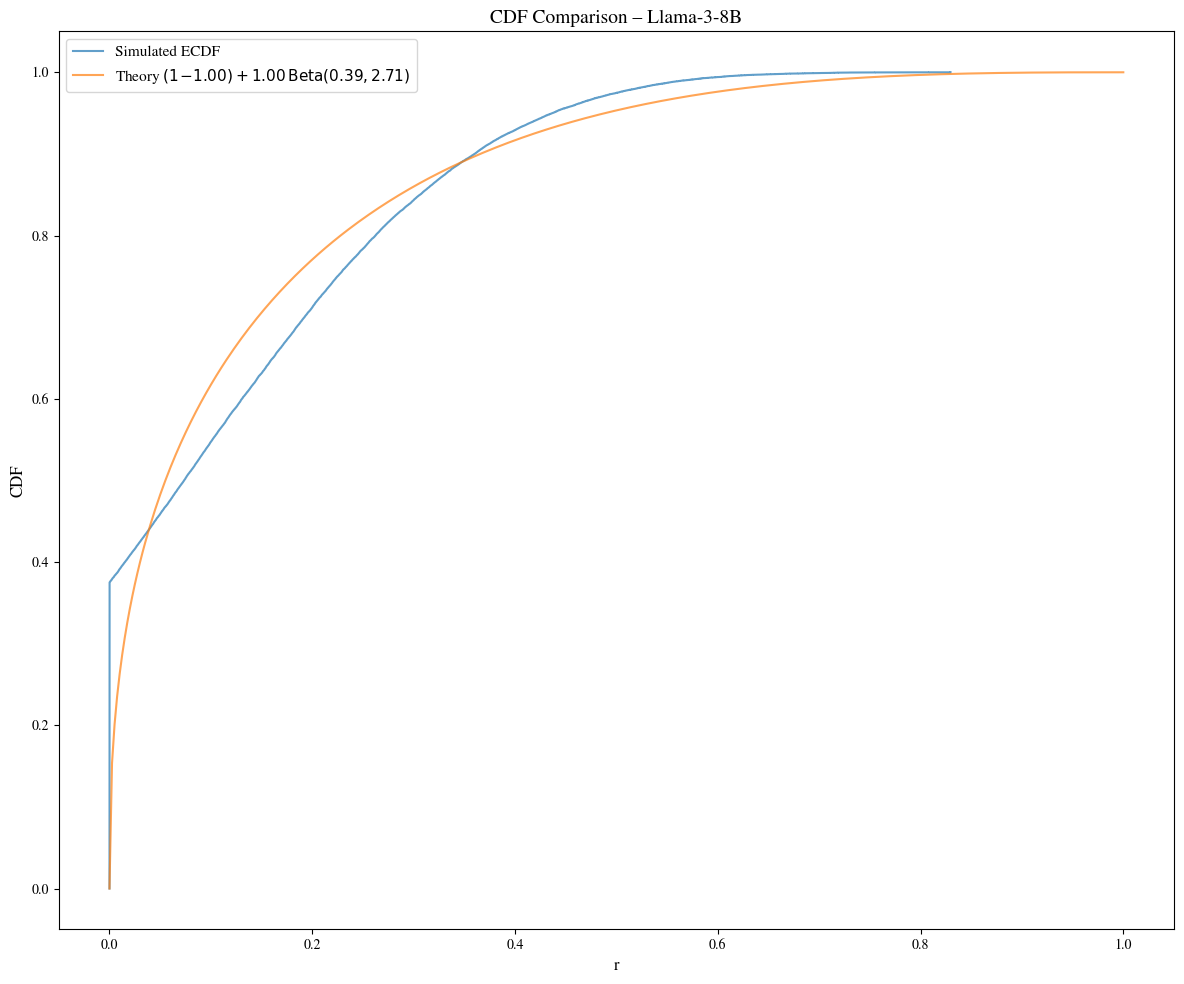

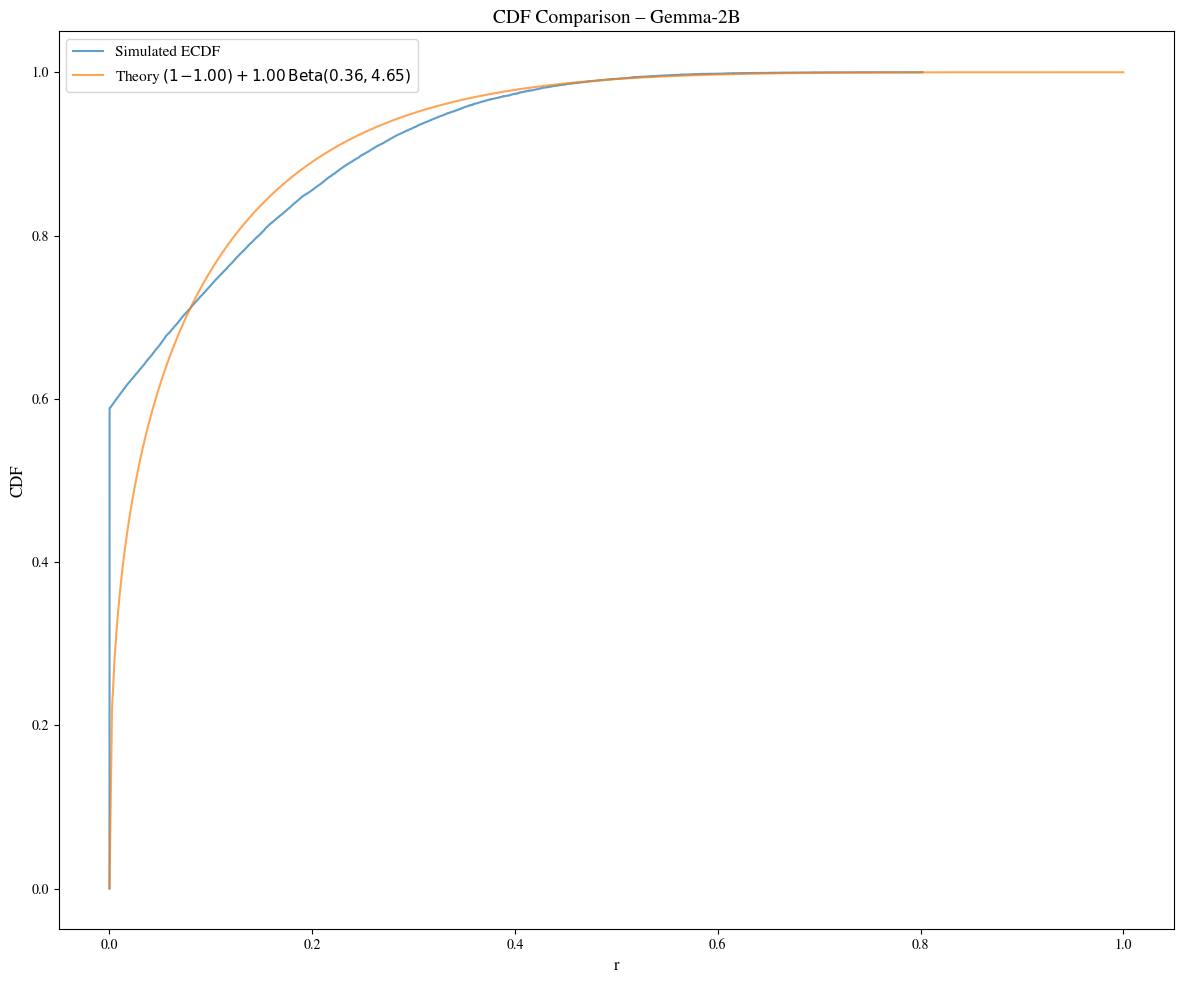

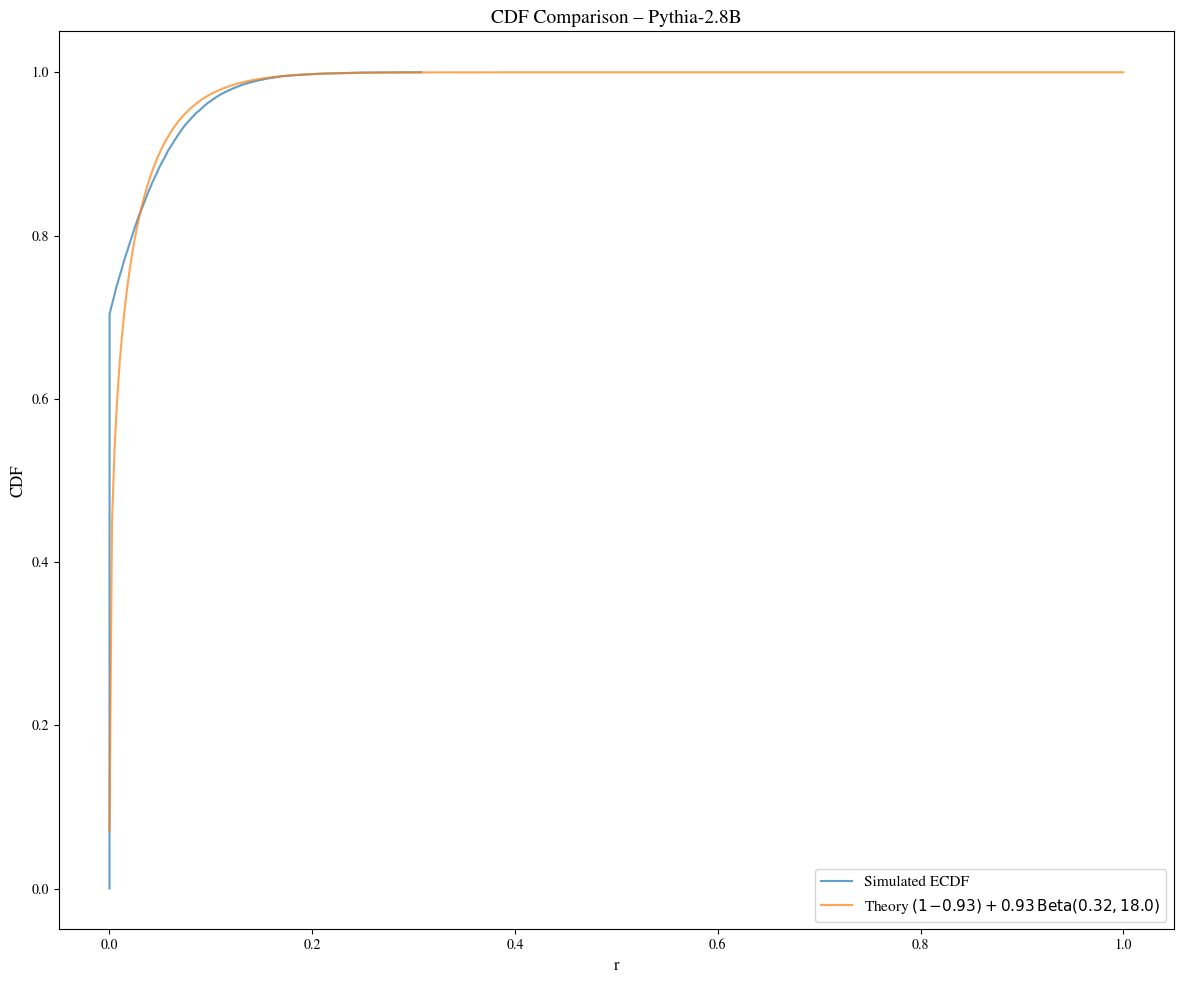

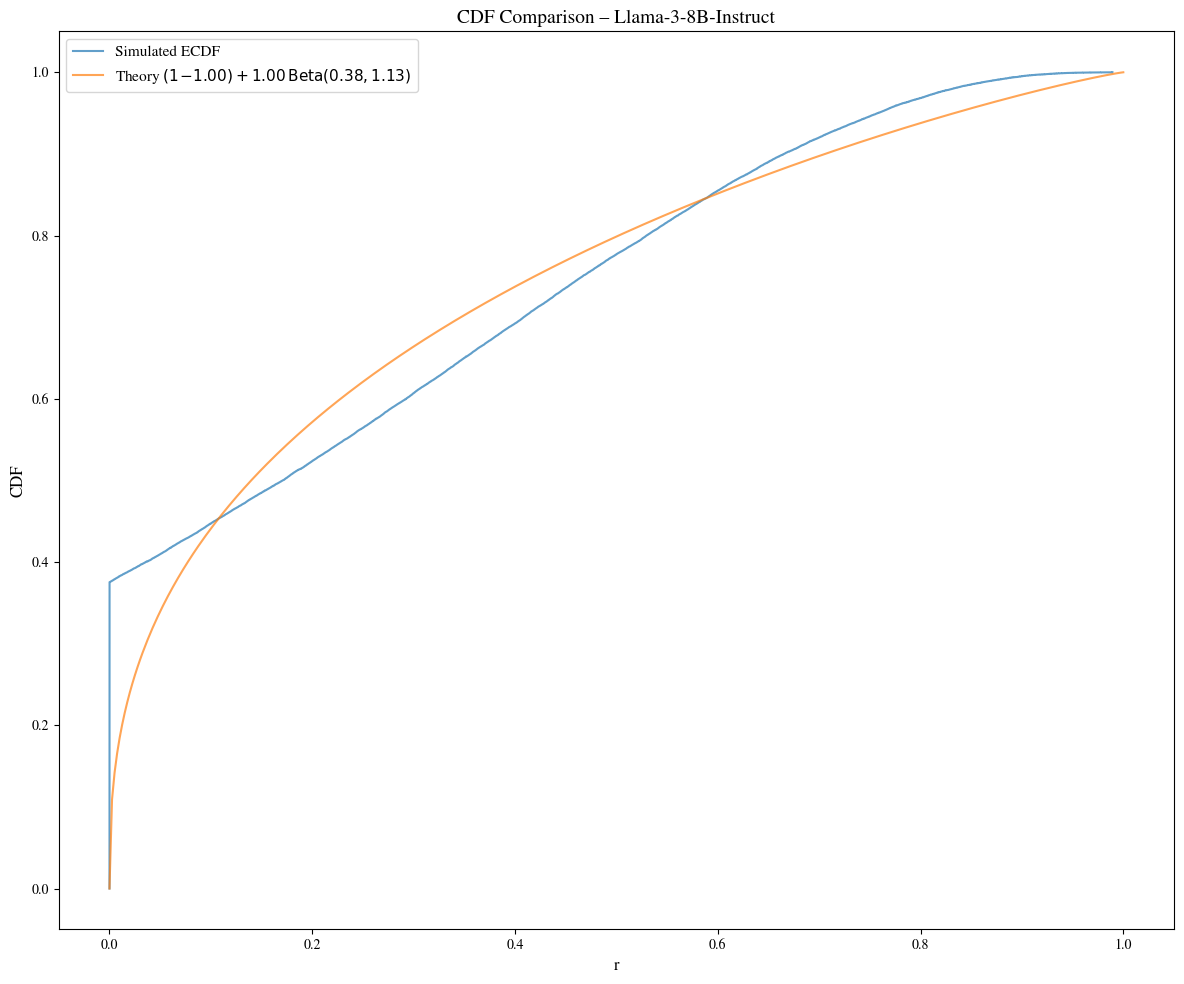

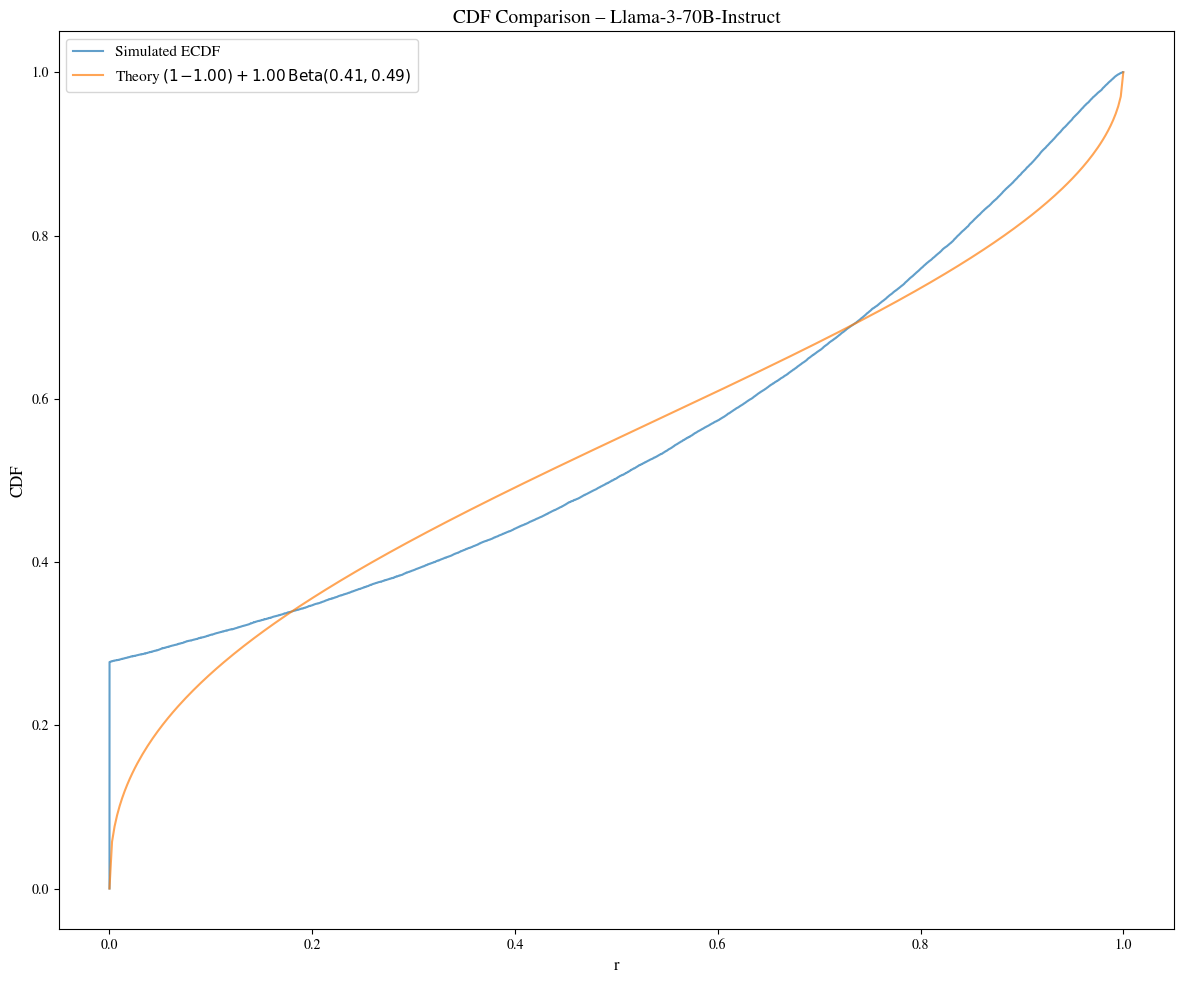

In [706]:
# Decode parameters
a = 1/(1+np.exp(-opt_theta[0]))
b = np.exp(opt_theta[1])
d = np.tanh(opt_theta[2])
mu1, lnSig1, muH, lnSigH = opt_theta[3:7]
sig1, sigH = np.exp(lnSig1), np.exp(lnSigH)
iotas = 1/(1+np.exp(-opt_theta[7:]))

# Add this after decoding your fitted parameters to check for issues:

print("Checking for potential parameter issues:")
print(f"Fitted iotas: {iotas}")

# Check if any iota is extremely small
for key, iota in zip(model_specs.keys(), iotas):
    if iota < 0.01:
        print(f"WARNING: {key} has very small iota = {iota:.6f}")
    
    # Check what xi range this would produce
    L, k, _ = model_specs[key]
    # Rough estimate of xi range
    xi_min = iota * (a * 0 + d)  # when sigmoid is ~0
    xi_max = iota * (a * 1 + d)  # when sigmoid is ~1
    print(f"{key}: xi range ≈ [{xi_min:.6f}, {xi_max:.6f}]")
    
    # For betainc(m, k-m+1, xi), if xi is very small, result will be ~0
    # If xi is very large, result will be ~1
    if xi_max < 0.001:
        print(f"  WARNING: xi_max is very small - betainc will return ~0")
    if xi_min > 0.999:
        print(f"  WARNING: xi_min is very large - betainc will return ~1")

# Display fitted shared parameters
print("Shared parameters:")
print(f"a={a:.3f}, b={b:.3f}, d={d:.3f}")
print(f"mu1={mu1:.3f}, sigma1={sig1:.3f}")
print(f"mu100={muH:.3f}, sigma100={sigH:.3f}")
print("\nPer-model iota:")
for key, val in zip(model_specs.keys(), iotas):
    print(f"{key}: iota={val:.3f}")

x_vals = np.linspace(0, 1, 400)
for key, iota in zip(model_specs.keys(), iotas):
    params = (a, b, d, mu1, lnSig1, muH, lnSigH, iota)

    # simulate once with the correct spike
    r_sim = simulate_tasks_with_spike(key, params, n_tasks=50000, rng=rng)
    
    # Empirical CDF (includes the zeros from simulate_tasks_with_spike)
    r_sorted = np.sort(r_sim)
    ecdf     = np.arange(1, len(r_sorted) + 1) / len(r_sorted)

    # Theoretical mixture CDF
    A_t, α_t, β_t = model_specs[key][2]
    beta_cdf_vals = beta_cdf_vec(x_vals, α_t, β_t)
    mix_cdf       = (1 - A_t) + A_t * beta_cdf_vals

    plt.figure()
    plt.step(r_sorted, ecdf, where='post', label='Simulated ECDF', alpha=0.7)
    plt.plot(x_vals, mix_cdf,
             label=fr"Theory $(1\!-\!{A_t:.2f}) + {A_t:.2f}\,\mathrm{{Beta}}({α_t},{β_t})$",
             alpha=0.7)
    plt.title(f"CDF Comparison – {key}")
    plt.xlabel("r"); plt.ylabel("CDF")
    plt.legend(); plt.tight_layout(); plt.show()


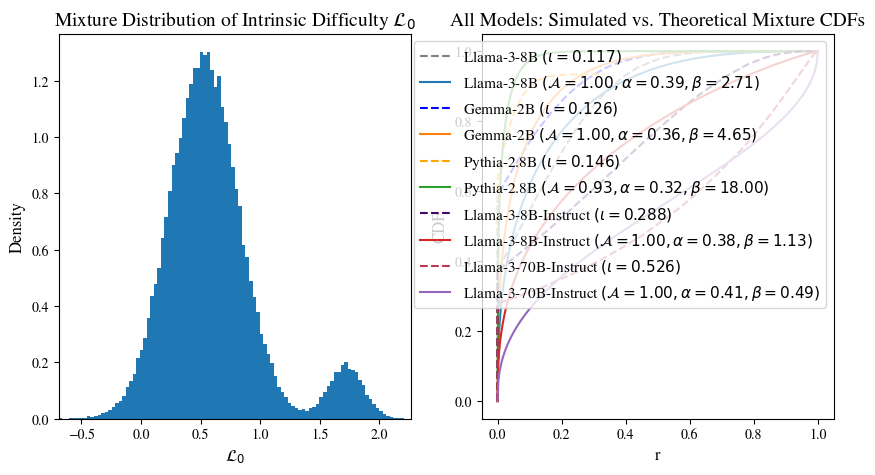

In [712]:
PRIMARY_COLOR = 'blue' # Gemma-2B
SECONDARY_COLOR = 'orange' # Pythia-2.8B
TERTIARY_COLOR = 'grey' # Llama-3-8B

# Get more colors from the inferno colormap
cmap = plt.get_cmap('inferno').copy()
COLOR4 = cmap(0.2)  # Llama-3-8B-Instruct
COLOR5 = cmap(0.35)  # Llama-3-8B-Instruct Majority
COLOR6 = cmap(0.5)  # Llama-3-70B-Instruct
COLOR7 = cmap(0.6)  # Llama-3-70B-Instruct Majority

# ========== Combined CDF + L0 Distribution ==========
# Combined CDF plot
# Get two subplots in a figure
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

x_vals = np.linspace(0, 1, 400)

for key, iota in zip(model_specs, iotas):
    # Re-simulate r for this model
    params = (a, b, d, mu1, lnSig1, muH, lnSigH, iota)
    r_sim, _ = simulate_tasks(key, params, n_tasks=50000, rng=rng)
    
    # Inject the (1-A) spike at zero
    A_t, alpha_t, beta_t = model_specs[key][2]
    mask_zero = rng.random(len(r_sim)) > A_t
    r_sim[mask_zero] = 0.0
    
    # Get color for each model
    for (_, model_name, color, data, _) in fitted_configs:
        if model_name == key:
            color = color
            break

    # (Approximated Distribution from Simple and Shared $(\mathcal{{L}}_0,\ m)$ Distribution)
    # Empirical mixture ECDF
    r_sorted = np.sort(r_sim)
    ecdf = np.arange(1, len(r_sorted) + 1) / len(r_sorted)
    ax2.step(r_sorted, ecdf, '--', color=color, where='post', label=fr"{key} $(\iota={iota:.3f})$")
    
    # Theoretical mixture CDF
    theory = np.where(
        x_vals == 0,
        1 - A_t,
        (1 - A_t) + A_t * beta_cdf_vec(x_vals, alpha_t, beta_t)
    )
    ax2.plot(x_vals, theory, label=fr"{key} $(\mathcal{{A}}={A_t:.2f}, \alpha={alpha_t:.2f}, \beta={beta_t:.2f})$")

ax2.set_xlabel("r")
ax2.set_ylabel("CDF")
ax2.set_title("All Models: Simulated vs. Theoretical Mixture CDFs")
ax2.legend()

# Distribution over L0
n = 100000
m_sample = rng.choice([1, 100], size=n, p=[0.93, 0.07])
L0_vals = np.where(
    m_sample == 1,
    rng.normal(mu1, np.exp(lnSig1), size=n),
    rng.normal(muH, np.exp(lnSigH), size=n)
)
ax1.hist(L0_vals, bins=100, density=True)
ax1.set_xlim(np.min(L0_vals), np.max(L0_vals))
ax1.set_xlabel(r"$\mathcal{{L}}_0$")
ax1.set_ylabel("Density")
ax1.set_title(r"Mixture Distribution of Sigmoid Difficulty Parameter $\mathcal{{L}}_0$")
plt.show()

In [744]:
# Beautiful plotting with proper colors and fixed simulation
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import betainc

# First, fix the simulate_tasks_with_spike function
def simulate_tasks_with_spike_fixed(model_key, params, n_tasks=30000, rng=None):
    a,b,d,mu1,lns1,muH,lnsH,iota = params
    sigma1, sigmaH = np.exp(lns1), np.exp(lnsH)
    L, k, _ = model_specs[model_key]
    A_t, _, _ = model_specs[model_key][2]

    # 1) Decide which tasks are "spike" (r=0)
    is_zero = rng.random(n_tasks) > A_t

    # 2) For the remaining tasks, simulate as before:
    nonzero_indices = np.where(~is_zero)[0]
    if len(nonzero_indices) == 0:
        return np.zeros(n_tasks)
    
    m_samples = rng.choice([1,100], size=len(nonzero_indices), p=[0.93,0.07])
    L0 = np.empty(len(nonzero_indices))
    idx1 = m_samples==1
    L0[idx1] = rng.normal(mu1, sigma1, size=idx1.sum())
    L0[~idx1] = rng.normal(muH, sigmaH, size=(~idx1).sum())

    xi = iota * (a * expit(b*(L0 - L)) + d)
    xi = np.clip(xi, 1e-9, 1-1e-9)
    
    # FIX: Handle k < m case properly
    r_nonzero = np.where(k - m_samples + 1 > 0,
                        betainc(m_samples, k - m_samples + 1, xi), 
                        0.0)

    # 3) Build the full r array
    r = np.zeros(n_tasks)
    r[nonzero_indices] = r_nonzero
    return r

# Color scheme
model_colors = {
    'Gemma-2B': 'blue',
    'Pythia-2.8B': 'orange', 
    'Llama-3-8B': 'grey',
    'Llama-3-8B-Instruct': plt.get_cmap('inferno')(0.2),
    'Llama-3-70B-Instruct': plt.get_cmap('inferno')(0.35)
}

# Set up the beautiful plot
plt.style.use('default')
fig = plt.figure(figsize=(16, 8))
fig.patch.set_facecolor('white')

# Create subplots with nice spacing
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# ========== Left Panel: L0 Distribution ==========
n_sample = 100000
m_sample = rng.choice([1, 100], size=n_sample, p=[0.93, 0.07])
L0_vals = np.where(
    m_sample == 1,
    rng.normal(mu1, np.exp(lnSig1), size=n_sample),
    rng.normal(muH, np.exp(lnSigH), size=n_sample)
)

# Create beautiful histogram
ax1.hist(L0_vals, bins=80, density=True, alpha=0.7, color='lightblue', 
         edgecolor='darkblue', linewidth=0.5)

# Add vertical lines for model L values
for i, (model_key, (L, k, _)) in enumerate(model_specs.items()):
    color = model_colors[model_key]
    ax1.axvline(L, color=color, linestyle=':', alpha=0.9, linewidth=2.5,
                label=f'{model_key} (L={L:.2f})')

ax1.set_xlabel(r'Sigmoid Input $\mathcal{L}_0$', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title(r'Distribution of $\mathcal{L}_0$ with Model Thresholds', 
              fontsize=14, fontweight='bold', pad=20)

# Add text box with distribution info
textstr = f'$p(m=1) = 0.93$\n$p(m=100) = 0.07$\n\n$\\mu_1 = {mu1:.3f}$\n$\\sigma_1 = {np.exp(lnSig1):.3f}$\n$\\mu_{{100}} = {muH:.3f}$\n$\\sigma_{{100}} = {np.exp(lnSigH):.3f}$'
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

ax1.legend(loc='upper center', fontsize=10, ncol=2)
ax1.grid(True, alpha=0.3)

# ========== Right Panel: CDF Comparison ==========
x_vals = np.linspace(0, 1, 1000)

for model_key, iota in zip(model_specs.keys(), iotas):
    # Get model parameters
    A_t, alpha_t, beta_t = model_specs[model_key][2]
    color = model_colors[model_key]
    
    # Simulate with fixed function
    params = (a, b, d, mu1, lnSig1, muH, lnSigH, iota)
    r_sim = simulate_tasks_with_spike_fixed(model_key, params, n_tasks=50000, rng=rng)
    
    # Empirical CDF
    r_sorted = np.sort(r_sim)
    ecdf = np.arange(1, len(r_sorted) + 1) / len(r_sorted)
    
    # Plot simulated (dashed line)
    ax2.step(r_sorted, ecdf, '--', color=color, where='post', alpha=0.8, linewidth=2,
             label=f'{model_key} Simulated (budget={iota:.3f})')
    
    # Theoretical CDF (solid line)
    beta_cdf_vals = beta_cdf_vec(x_vals, alpha_t, beta_t)
    theory_cdf = (1 - A_t) + A_t * beta_cdf_vals
    ax2.plot(x_vals, theory_cdf, '-', color=color, alpha=0.9, linewidth=2,
             label=f'{model_key} Target ($A$={A_t:.2f})')

ax2.set_xlabel('Success Rate $r$', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance: Simulated vs Target CDFs', 
              fontsize=14, fontweight='bold', pad=20)

# Add sigmoid parameters in a text box
sigmoid_str = f'$\\xi = \\iota \\cdot [a \\cdot \\sigma(b(\\mathcal{{L}}_0 - L)) + d]$\n$r_{{\\mathcal{{L}}_0,m}} = I_\\xi(m, k-m+1)$\n\n$a = {a:.3f}$\n$b = {b:.3f}$\n$d = {d:.3f}$'

ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), fontsize=9, ncol=2)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.01, 1.01)
ax2.set_ylim(-0.01, 1.01)

# Overall title
fig.suptitle('Mixture Model Analysis: Sigmoid Parameterization with Point Mass at Zero', 
             fontsize=16, fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()

# Print summary stats
print("\\n" + "="*60)
print("FITTED MODEL SUMMARY")
print("="*60)
print(f"Sigmoid Parameters: a={a:.3f}, b={b:.3f}, d={d:.3f}")
print(f"Task Distribution: p(m=1)=0.93, p(m=100)=0.07") 
print(f"L0 Easy Tasks: μ={mu1:.3f}, σ={np.exp(lnSig1):.3f}")
print(f"L0 Hard Tasks: μ={muH:.3f}, σ={np.exp(lnSigH):.3f}")
print("\\nPer-Model Parameters:")
for model_key, iota in zip(model_specs.keys(), iotas):
    L, k, _ = model_specs[model_key]
    A_t, alpha_t, beta_t = model_specs[model_key][2]
    print(f"  {model_key}: L={L:.2f}, k={k:.1f}, token_budget={iota:.3f}, A={A_t:.2f}")

props2 = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
ax2.text(0.98, 0.02, sigmoid_str, transform=ax2.transAxes, fontsize=10,
         verticalalignment='bottom', horizontalalignment='right', bbox=props2)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# Overall title
fig.suptitle('Mixture Model Analysis: Sigmoid Parameterization with Point Mass at Zero', 
             fontsize=16, fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()

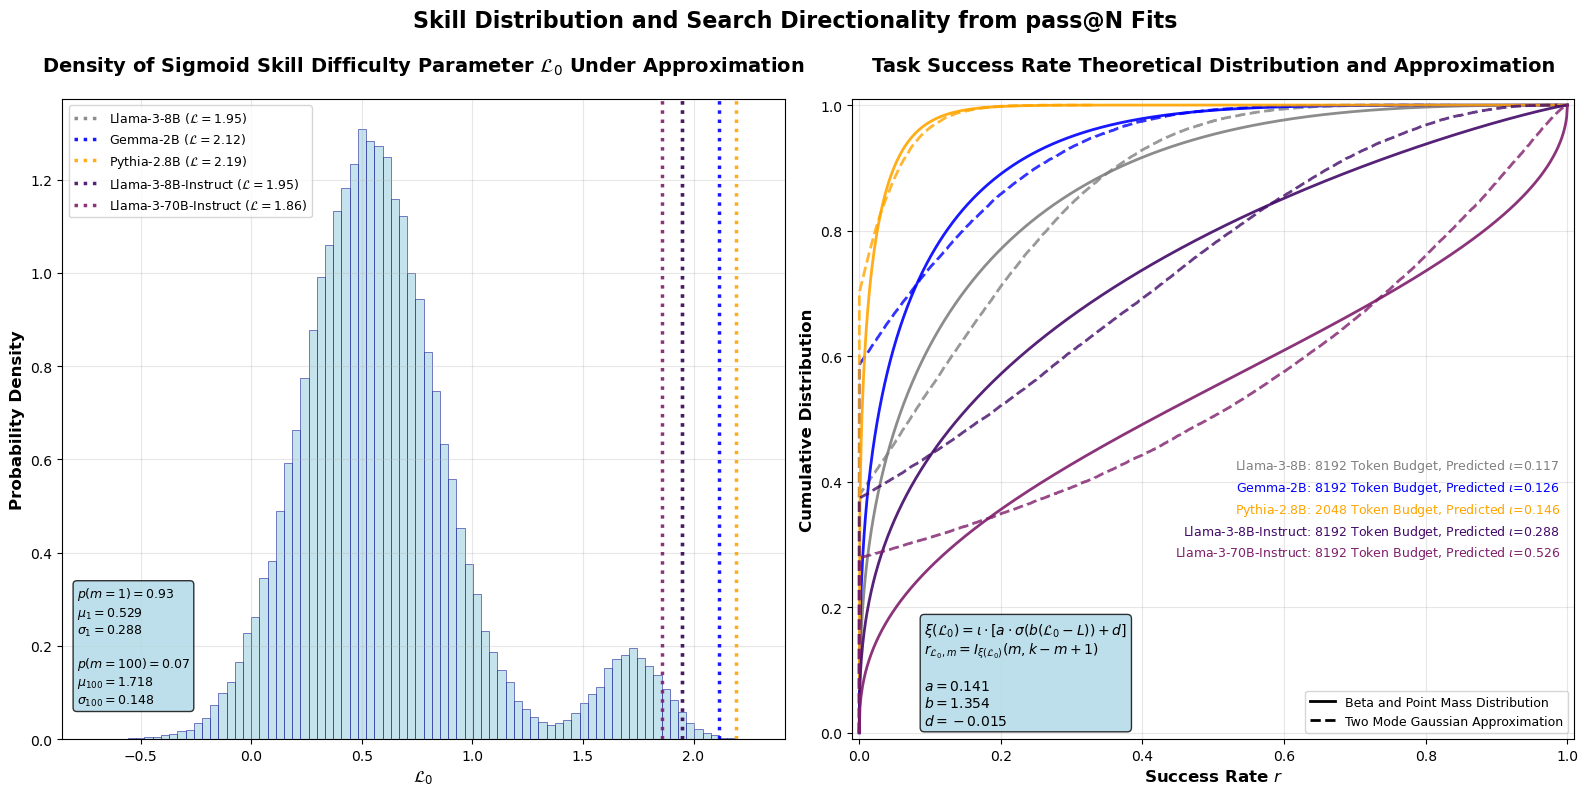


FITTED MODEL SUMMARY
Sigmoid Parameters: a=0.141, b=1.354, d=-0.015
Task Distribution: p(m=1)=0.93, p(m=100)=0.07
L0 Easy Tasks: μ=0.529, σ=0.288
L0 Hard Tasks: μ=1.718, σ=0.148

Per-Model Parameters:
  Llama-3-8B: L=1.95, k=327.7, Token Budget=8192, ι=0.117
  Gemma-2B: L=2.12, k=327.7, Token Budget=8192, ι=0.126
  Pythia-2.8B: L=2.19, k=81.9, Token Budget=2048, ι=0.146
  Llama-3-8B-Instruct: L=1.95, k=327.7, Token Budget=8192, ι=0.288
  Llama-3-70B-Instruct: L=1.86, k=327.7, Token Budget=8192, ι=0.526


In [778]:
# Updated beautiful plotting with minimized legend size, improved math formatting,
# and integrated token budget + iota display per model

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import betainc

# Simulate tasks with fixed structure and point mass at r = 0
def simulate_tasks_with_spike_fixed(model_key, params, n_tasks=30000, rng=None):
    a, b, d, mu1, lns1, muH, lnsH, iota = params
    sigma1, sigmaH = np.exp(lns1), np.exp(lnsH)
    L, k, _ = model_specs[model_key]
    A_t, _, _ = model_specs[model_key][2]

    is_zero = rng.random(n_tasks) > A_t
    nonzero_indices = np.where(~is_zero)[0]
    if len(nonzero_indices) == 0:
        return np.zeros(n_tasks)

    m_samples = rng.choice([1, 100], size=len(nonzero_indices), p=[0.93, 0.07])
    L0 = np.empty(len(nonzero_indices))
    idx1 = m_samples == 1
    L0[idx1] = rng.normal(mu1, sigma1, size=idx1.sum())
    L0[~idx1] = rng.normal(muH, sigmaH, size=(~idx1).sum())

    xi = iota * (a * 1 / (1 + np.exp(-b * (L0 - L))) + d)
    xi = np.clip(xi, 1e-9, 1 - 1e-9)
    r_nonzero = np.where(k - m_samples + 1 > 0,
                         betainc(m_samples, k - m_samples + 1, xi),
                         0.0)

    r = np.zeros(n_tasks)
    r[nonzero_indices] = r_nonzero
    return r

# Helper function
from scipy.stats import beta as beta_dist
def beta_cdf_vec(x, a, b):
    return beta_dist.cdf(x, a, b)

# Color scheme
model_colors = {
    'Gemma-2B': 'blue',
    'Pythia-2.8B': 'orange',
    'Llama-3-8B': 'grey',
    'Llama-3-8B-Instruct': plt.get_cmap('inferno')(0.2),
    'Llama-3-70B-Instruct': plt.get_cmap('inferno')(0.35)
}

# Plotting setup
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.patch.set_facecolor('white')

# ========== L0 DISTRIBUTION ==========
n_sample = 100000
m_sample = rng.choice([1, 100], size=n_sample, p=[0.93, 0.07])
L0_vals = np.where(
    m_sample == 1,
    rng.normal(mu1, np.exp(lnSig1), size=n_sample),
    rng.normal(muH, np.exp(lnSigH), size=n_sample)
)

ax1.hist(L0_vals, bins=80, density=True, alpha=0.7, color='lightblue',
         edgecolor='darkblue', linewidth=0.5)

for model_key, (L, k, _) in model_specs.items():
    ax1.axvline(L, color=model_colors[model_key], linestyle=':', alpha=0.9, linewidth=2.5,
                label=fr'{model_key} ($\mathcal{{L}} = {L:.2f}$)')

ax1.set_xlabel(r'$\mathcal{L}_0$', fontsize=12, fontweight='bold')
ax1.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax1.set_title(r'Density of Sigmoid Skill Difficulty Parameter $\mathcal{L}_0$ Under Approximation', fontsize=14, fontweight='bold', pad=20)

textstr = fr'''$p(m=1) = 0.93$
$\mu_1 = {mu1:.3f}$
$\sigma_1 = {np.exp(lnSig1):.3f}$

$p(m=100) = 0.07$
$\mu_{{100}} = {muH:.3f}$
$\sigma_{{100}} = {np.exp(lnSigH):.3f}$'''
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax1.text(0.02, 0.24, textstr, transform=ax1.transAxes, fontsize=9,
         verticalalignment='top', bbox=props)
ax1.legend(loc='upper left', fontsize=9, ncol=1)
ax1.grid(True, alpha=0.3)

# ========== CDF PANEL ==========
x_vals = np.linspace(0, 1, 1000)

iota_labels = ''
for idx, (model_key, iota) in enumerate(zip(model_specs.keys(), iotas)):
    A_t, alpha_t, beta_t = model_specs[model_key][2]
    color = model_colors[model_key]
    params = (a, b, d, mu1, lnSig1, muH, lnSigH, iota)
    r_sim = simulate_tasks_with_spike_fixed(model_key, params, n_tasks=50000, rng=rng)

    r_sorted = np.sort(r_sim)
    ecdf = np.arange(1, len(r_sorted) + 1) / len(r_sorted)

    ax2.step(r_sorted, ecdf, '--', color=color, where='post', alpha=0.8, linewidth=2)
    beta_cdf_vals = beta_cdf_vec(x_vals, alpha_t, beta_t)
    theory_cdf = (1 - A_t) + A_t * beta_cdf_vals
    ax2.plot(x_vals, theory_cdf, '-', color=color, alpha=0.9, linewidth=2)

    ax2.text(0.98, 0.44 - 0.034 * idx, fr'{model_key}: {results[model_key]["output_budget"]} Token Budget, Predicted $\iota$={iota:.3f}',
             transform=ax2.transAxes, fontsize=9, color=color,
             verticalalignment='top', horizontalalignment='right')

ax2.set_xlabel(r'Success Rate $r$', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Distribution', fontsize=12, fontweight='bold')
ax2.set_title('Task Success Rate Theoretical Distribution and Approximation',
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlim(-.01, 1.01)
ax2.set_ylim(-.01, 1.01)
ax2.grid(True, alpha=0.3)

# Legend using dummy handles
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], color='black', linestyle='-', lw=2, label='Beta and Point Mass Distribution'),
    Line2D([0], [0], color='black', linestyle='--', lw=2, label='Two Mode Gaussian Approximation')
]
ax2.legend(handles=handles, loc='lower right', fontsize=9)

# Parameter box
sigmoid_str = fr'''$\xi(\mathcal{{L}}_0) = \iota \cdot [a \cdot \sigma(b(\mathcal{{L}}_0 - L)) + d]$
$r_{{\mathcal{{L}}_0,m}} = I_{{\xi(\mathcal{{L}}_0)}}(m, k-m+1)$

$a = {a:.3f}$
$b = {b:.3f}$
$d = {d:.3f}$'''
props2 = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax2.text(0.1, 0.185, sigmoid_str, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='left', bbox=props2)

# Main title
fig.suptitle('Skill Distribution and Search Directionality from pass@N Fits',
             fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()

# Summary print
print("\n" + "=" * 60)
print("FITTED MODEL SUMMARY")
print("=" * 60)
print(f"Sigmoid Parameters: a={a:.3f}, b={b:.3f}, d={d:.3f}")
print(f"Task Distribution: p(m=1)=0.93, p(m=100)=0.07")
print(f"L0 Easy Tasks: μ={mu1:.3f}, σ={np.exp(lnSig1):.3f}")
print(f"L0 Hard Tasks: μ={muH:.3f}, σ={np.exp(lnSigH):.3f}")
print("\nPer-Model Parameters:")
for model_key, iota in zip(model_specs.keys(), iotas):
    L, k, _ = model_specs[model_key]
    A_t, alpha_t, beta_t = model_specs[model_key][2]
    output_budget = results[model_key]['output_budget']
    print(f"  {model_key}: L={L:.2f}, k={k:.1f}, Token Budget={output_budget}, ι={iota:.3f}")
